# About the dataset
It is a public set of comments collected for spam research. It has five datasets composed by 1,956 real messages extracted from five videos that were among the 10 most viewed on the collection period.

In [4]:
import html
import os
import nltk
import string
import emoji

import seaborn as sns
import plotly.express as px
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.pyplot import figure
from wordcloud import WordCloud
from PIL import Image
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import KFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)
from sklearn.model_selection import cross_validate, cross_val_predict, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from tabulate import tabulate
from scipy.stats import wilcoxon

# Needed by nltk
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("averaged_perceptron_tagger")
nltk.download("words")
nltk.download("wordnet")

[nltk_data] Downloading package punkt to /home/kalex/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /home/kalex/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/kalex/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package words to /home/kalex/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package wordnet to /home/kalex/nltk_data...


True

In [5]:
# Import the dataset
dataset_dir = "./dataset/"

data = []
for f in os.listdir(dataset_dir):
    data.append(pd.read_csv(dataset_dir + f))

# Ignore index so that we get rows indexed correctly from 0 to 1955
df = pd.concat(data, ignore_index=True)
df

COMMENT_ID                AUTHOR  \
0     LZQPQhLyRh80UYxNuaDWhIGQYNQ96IuCg-AYWqNPjpU             Julius NM   
1     LZQPQhLyRh_C2cTtd9MvFRJedxydaVW-2sNg5Diuo4A           adam riyati   
2     LZQPQhLyRh9MSZYnf8djyk0gEF9BHDPYrrK-qCczIY8      Evgeny Murashkin   
3             z13jhp0bxqncu512g22wvzkasxmvvzjaz04       ElNino Melendez   
4             z13fwbwp1oujthgqj04chlngpvzmtt3r3dw                GsMega   
...                                           ...                   ...   
1951  _2viQ_Qnc6-bMSjqyL1NKj57ROicCSJV5SwTrw-RFFA          Katie Mettam   
1952  _2viQ_Qnc6-pY-1yR6K2FhmC5i48-WuNx5CumlHLDAI  Sabina Pearson-Smith   
1953  _2viQ_Qnc6_k_n_Bse9zVhJP8tJReZpo8uM2uZfnzDs         jeffrey jules   
1954  _2viQ_Qnc6_yBt8UGMWyg3vh0PulTqcqyQtdE7d4Fl0        Aishlin Maciel   
1955  _2viQ_Qnc685RPw1aSa1tfrIuHXRvAQ2rPT9R06KTqA           Latin Bosch   

                            DATE  \
0            2013-11-07T06:20:48   
1            2013-11-07T12:37:15   
2            2013-11-08T17:34:21   
3            2013-11-09T08:28:43   
4            2013-11-10T16:05:38   
...                          ...   
1951  2013-07-13T13:27:39.441000   
1952  2013-07-13T13:14:30.021000   
1953  2013-07-13T12:09:31.188000   
1954  2013-07-13T11:17:52.308000   
1955  2013-07-12T22:33:27.916000   

                                                CONTENT  CLASS  
0     Huh, anyway check out this you[tube] channel: ...      1  
1     Hey guys check out my new channel and our firs...      1  
2                just for test I have to say murdev.com      1  
3      me shaking my sexy ass on my channel enjoy ^_^ ﻿      1  
4               watch?v=vtaRGgvGtWQ   Check this out .﻿      1  
...                                                 ...    ...  
1951  I love this song because we sing it at Camp al...      0  
1952  I love this song for two reasons: 1.it is abou...      0  
1953                                                wow      0  
1954                            Shakira u are so wiredo      0  
1955                         Shakira is the best dancer      0  

[1956 rows x 5 columns]

In [6]:
df.tail(10)

COMMENT_ID                AUTHOR  \
1946  _2viQ_Qnc69MEEHHJxZ427KX8MlljJPnUC2YBbvbWwY           ThirdDegr3e   
1947  _2viQ_Qnc6_RKHVetk9kLzx8ZC62_J7y73FWFSBTe8Q           ThirdDegr3e   
1948  _2viQ_Qnc68TufyXKiTwky80ewSPbhRiD5XFHrJH9lg      Ysobel Schofield   
1949  _2viQ_Qnc689m-WiwOwvrQU7LvkLAgspnfXL8ovE0ME       TheHotChocolate   
1950  _2viQ_Qnc6_1Hq9MGlefkBIszt9rYD3S_CozADvMhQ4         Dinova Sharon   
1951  _2viQ_Qnc6-bMSjqyL1NKj57ROicCSJV5SwTrw-RFFA          Katie Mettam   
1952  _2viQ_Qnc6-pY-1yR6K2FhmC5i48-WuNx5CumlHLDAI  Sabina Pearson-Smith   
1953  _2viQ_Qnc6_k_n_Bse9zVhJP8tJReZpo8uM2uZfnzDs         jeffrey jules   
1954  _2viQ_Qnc6_yBt8UGMWyg3vh0PulTqcqyQtdE7d4Fl0        Aishlin Maciel   
1955  _2viQ_Qnc685RPw1aSa1tfrIuHXRvAQ2rPT9R06KTqA           Latin Bosch   

                            DATE  \
1946  2013-07-13T20:48:06.033000   
1947  2013-07-13T20:47:40.793000   
1948  2013-07-13T20:17:25.181000   
1949  2013-07-13T18:26:37.017000   
1950  2013-07-13T14:44:00.700000   
1951  2013-07-13T13:27:39.441000   
1952  2013-07-13T13:14:30.021000   
1953  2013-07-13T12:09:31.188000   
1954  2013-07-13T11:17:52.308000   
1955  2013-07-12T22:33:27.916000   

                                                CONTENT  CLASS  
1946  **CHECK OUT MY NEW MIXTAPE**** **CHECK OUT MY ...      1  
1947  **CHECK OUT MY NEW MIXTAPE**** **CHECK OUT MY ...      1  
1948                                Waka waka she rules      0  
1949                           she is sooooo beautiful!      0  
1950                                  well done shakira      0  
1951  I love this song because we sing it at Camp al...      0  
1952  I love this song for two reasons: 1.it is abou...      0  
1953                                                wow      0  
1954                            Shakira u are so wiredo      0  
1955                         Shakira is the best dancer      0

In [7]:
# Only DATE contains null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1956 entries, 0 to 1955
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   COMMENT_ID  1956 non-null   object
 1   AUTHOR      1956 non-null   object
 2   DATE        1711 non-null   object
 3   CONTENT     1956 non-null   object
 4   CLASS       1956 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 76.5+ KB


In [8]:
# Check descriptive statistics
# Not much to see here as we are working with NLP
df.describe(include="all")

COMMENT_ID AUTHOR  \
count                                          1956   1956   
unique                                         1953   1792   
top     _2viQ_Qnc68fX3dYsfYuM-m4ELMJvxOQBmBOFHqGOk0  M.E.S   
freq                                              2      8   
mean                                            NaN    NaN   
std                                             NaN    NaN   
min                                             NaN    NaN   
25%                                             NaN    NaN   
50%                                             NaN    NaN   
75%                                             NaN    NaN   
max                                             NaN    NaN   

                              DATE                            CONTENT  \
count                         1711                               1956   
unique                        1709                               1760   
top     2013-10-05T00:57:25.078000  Check out this video on YouTube:﻿   
freq                             2                                 97   
mean                           NaN                                NaN   
std                            NaN                                NaN   
min                            NaN                                NaN   
25%                            NaN                                NaN   
50%                            NaN                                NaN   
75%                            NaN                                NaN   
max                            NaN                                NaN   

              CLASS  
count   1956.000000  
unique          NaN  
top             NaN  
freq            NaN  
mean       0.513804  
std        0.499937  
min        0.000000  
25%        0.000000  
50%        1.000000  
75%        1.000000  
max        1.000000

In [9]:
# Check for null values
# Confirms that only DATE contains some null values
df.isna().sum()

COMMENT_ID      0
AUTHOR          0
DATE          245
CONTENT         0
CLASS           0
dtype: int64

In [10]:
# Check if the dataset is balanced
# Not perfectly balanced, but still balanced enough to consider it balanced
df.CLASS.value_counts()

1    1005
0     951
Name: CLASS, dtype: int64

In [11]:
# Remove duplicates
# 3 rows have been removed, which doesn't affect balancing at all
df.drop_duplicates(inplace=True)

# We can safely drop features we don't need for analysis
# Keep AUTHOR, may be used to identify a particular AUTHOR that spams
# On the other hand, COMMENT_ID, DATE and AUTHOR are not relevant
to_drop = ["COMMENT_ID", "DATE", "AUTHOR"]
df.drop(labels=to_drop, axis=1, inplace=True)
df

CONTENT  CLASS
0     Huh, anyway check out this you[tube] channel: ...      1
1     Hey guys check out my new channel and our firs...      1
2                just for test I have to say murdev.com      1
3      me shaking my sexy ass on my channel enjoy ^_^ ﻿      1
4               watch?v=vtaRGgvGtWQ   Check this out .﻿      1
...                                                 ...    ...
1951  I love this song because we sing it at Camp al...      0
1952  I love this song for two reasons: 1.it is abou...      0
1953                                                wow      0
1954                            Shakira u are so wiredo      0
1955                         Shakira is the best dancer      0

[1953 rows x 2 columns]

In [12]:
# Comments contain HTML entities, so we decode them

df.CONTENT = df.CONTENT.apply(html.unescape)
df

CONTENT  CLASS
0     Huh, anyway check out this you[tube] channel: ...      1
1     Hey guys check out my new channel and our firs...      1
2                just for test I have to say murdev.com      1
3      me shaking my sexy ass on my channel enjoy ^_^ ﻿      1
4               watch?v=vtaRGgvGtWQ   Check this out .﻿      1
...                                                 ...    ...
1951  I love this song because we sing it at Camp al...      0
1952  I love this song for two reasons: 1.it is abou...      0
1953                                                wow      0
1954                            Shakira u are so wiredo      0
1955                         Shakira is the best dancer      0

[1953 rows x 2 columns]

In [13]:
# Comments contain some <br /> tags
# Replace then with newlines
df.CONTENT = df.CONTENT.apply(lambda s: s.replace("<br />", "\n"))

In [14]:
df

CONTENT  CLASS
0     Huh, anyway check out this you[tube] channel: ...      1
1     Hey guys check out my new channel and our firs...      1
2                just for test I have to say murdev.com      1
3      me shaking my sexy ass on my channel enjoy ^_^ ﻿      1
4               watch?v=vtaRGgvGtWQ   Check this out .﻿      1
...                                                 ...    ...
1951  I love this song because we sing it at Camp al...      0
1952  I love this song for two reasons: 1.it is abou...      0
1953                                                wow      0
1954                            Shakira u are so wiredo      0
1955                         Shakira is the best dancer      0

[1953 rows x 2 columns]

In [15]:
# Check if a given comment contains a link, which may indicate spam (e.g. links to other youtube channels)
def contains_link(s):
    return (
        1
        if any(
            fragment in s.lower()
            for fragment in ["http://", "https://", "www.", ".com"]
        )
        else 0
    )


def contains_yt_link(s):
    return 1 if "www.youtube.com" in s.lower() or "watch?v=" in s.lower() else 0


# Check if a given comment contains non-ASCII characters
def contains_non_ascii_chars(s):
    return 1 if not s.isascii() else 0


# Additionally, get the number of chars, words and sentences
def count_words(s):
    return len(nltk.word_tokenize(s))


def count_sentences(s):
    return len(nltk.sent_tokenize(s))


# Spam comments may use a lot of upper cases
def count_uppercase(s):
    return sum(1 for c in s if c.isupper())


# Most comments contain non-ASCII characters
# Recognize how many are emojis, which may be useful to tell apart ham/spam
def count_emojis(s):
    return emoji.emoji_count(s)


# Add everything to the dataset
df["HAS_LINKS"] = df.CONTENT.apply(contains_link)
df["HAS_YT_LINKS"] = df.CONTENT.apply(contains_yt_link)
df["HAS_NON_ASCII_CHARS"] = df.CONTENT.apply(contains_non_ascii_chars)
df["CHAR_COUNT"] = df.CONTENT.apply(len)
df["WORD_COUNT"] = df.CONTENT.apply(count_words)
df["SENTENCE_COUNT"] = df.CONTENT.apply(count_sentences)
df["UPPERCASE_COUNT"] = df.CONTENT.apply(count_uppercase)
df["EMOJI_COUNT"] = df.CONTENT.apply(count_emojis)

df

CONTENT  CLASS  HAS_LINKS  \
0     Huh, anyway check out this you[tube] channel: ...      1          0   
1     Hey guys check out my new channel and our firs...      1          0   
2                just for test I have to say murdev.com      1          1   
3      me shaking my sexy ass on my channel enjoy ^_^ ﻿      1          0   
4               watch?v=vtaRGgvGtWQ   Check this out .﻿      1          0   
...                                                 ...    ...        ...   
1951  I love this song because we sing it at Camp al...      0          0   
1952  I love this song for two reasons: 1.it is abou...      0          0   
1953                                                wow      0          0   
1954                            Shakira u are so wiredo      0          0   
1955                         Shakira is the best dancer      0          0   

      HAS_YT_LINKS  HAS_NON_ASCII_CHARS  CHAR_COUNT  WORD_COUNT  \
0                0                    0          56          13   
1                0                    0         166          40   
2                0                    0          38           8   
3                0                    1          48          11   
4                1                    1          39           7   
...            ...                  ...         ...         ...   
1951             0                    0          58          15   
1952             0                    0          93          19   
1953             0                    0           3           1   
1954             0                    0          23           5   
1955             0                    0          26           5   

      SENTENCE_COUNT  UPPERCASE_COUNT  EMOJI_COUNT  
0                  1                1            0  
1                  3               20            0  
2                  1                1            0  
3                  1                0            0  
4                  1                6            0  
...              ...              ...          ...  
1951               2                2            0  
1952               1                3            0  
1953               1                0            0  
1954               1                1            0  
1955               1                1            0  

[1953 rows x 10 columns]

In [16]:
df.describe(include="all")

CONTENT        CLASS    HAS_LINKS  \
count                                1953  1953.000000  1953.000000   
unique                               1760          NaN          NaN   
top     Check out this video on YouTube:﻿          NaN          NaN   
freq                                   97          NaN          NaN   
mean                                  NaN     0.513569     0.125960   
std                                   NaN     0.499944     0.331889   
min                                   NaN     0.000000     0.000000   
25%                                   NaN     0.000000     0.000000   
50%                                   NaN     1.000000     0.000000   
75%                                   NaN     1.000000     0.000000   
max                                   NaN     1.000000     1.000000   

        HAS_YT_LINKS  HAS_NON_ASCII_CHARS   CHAR_COUNT   WORD_COUNT  \
count    1953.000000          1953.000000  1953.000000  1953.000000   
unique           NaN                  NaN          NaN          NaN   
top              NaN                  NaN          NaN          NaN   
freq             NaN                  NaN          NaN          NaN   
mean        0.011777             0.809012    92.958525    19.865847   
std         0.107907             0.393180   125.244911    30.528380   
min         0.000000             0.000000     2.000000     1.000000   
25%         0.000000             1.000000    29.000000     6.000000   
50%         0.000000             1.000000    47.000000    10.000000   
75%         0.000000             1.000000    95.000000    20.000000   
max         1.000000             1.000000  1117.000000   697.000000   

        SENTENCE_COUNT  UPPERCASE_COUNT  EMOJI_COUNT  
count      1953.000000      1953.000000   1953.00000  
unique             NaN              NaN          NaN  
top                NaN              NaN          NaN  
freq               NaN              NaN          NaN  
mean          1.825397         9.151050      0.27701  
std           2.111330        26.021177      3.59439  
min           1.000000         0.000000      0.00000  
25%           1.000000         1.000000      0.00000  
50%           1.000000         2.000000      0.00000  
75%           2.000000         6.000000      0.00000  
max          25.000000       351.000000     87.00000

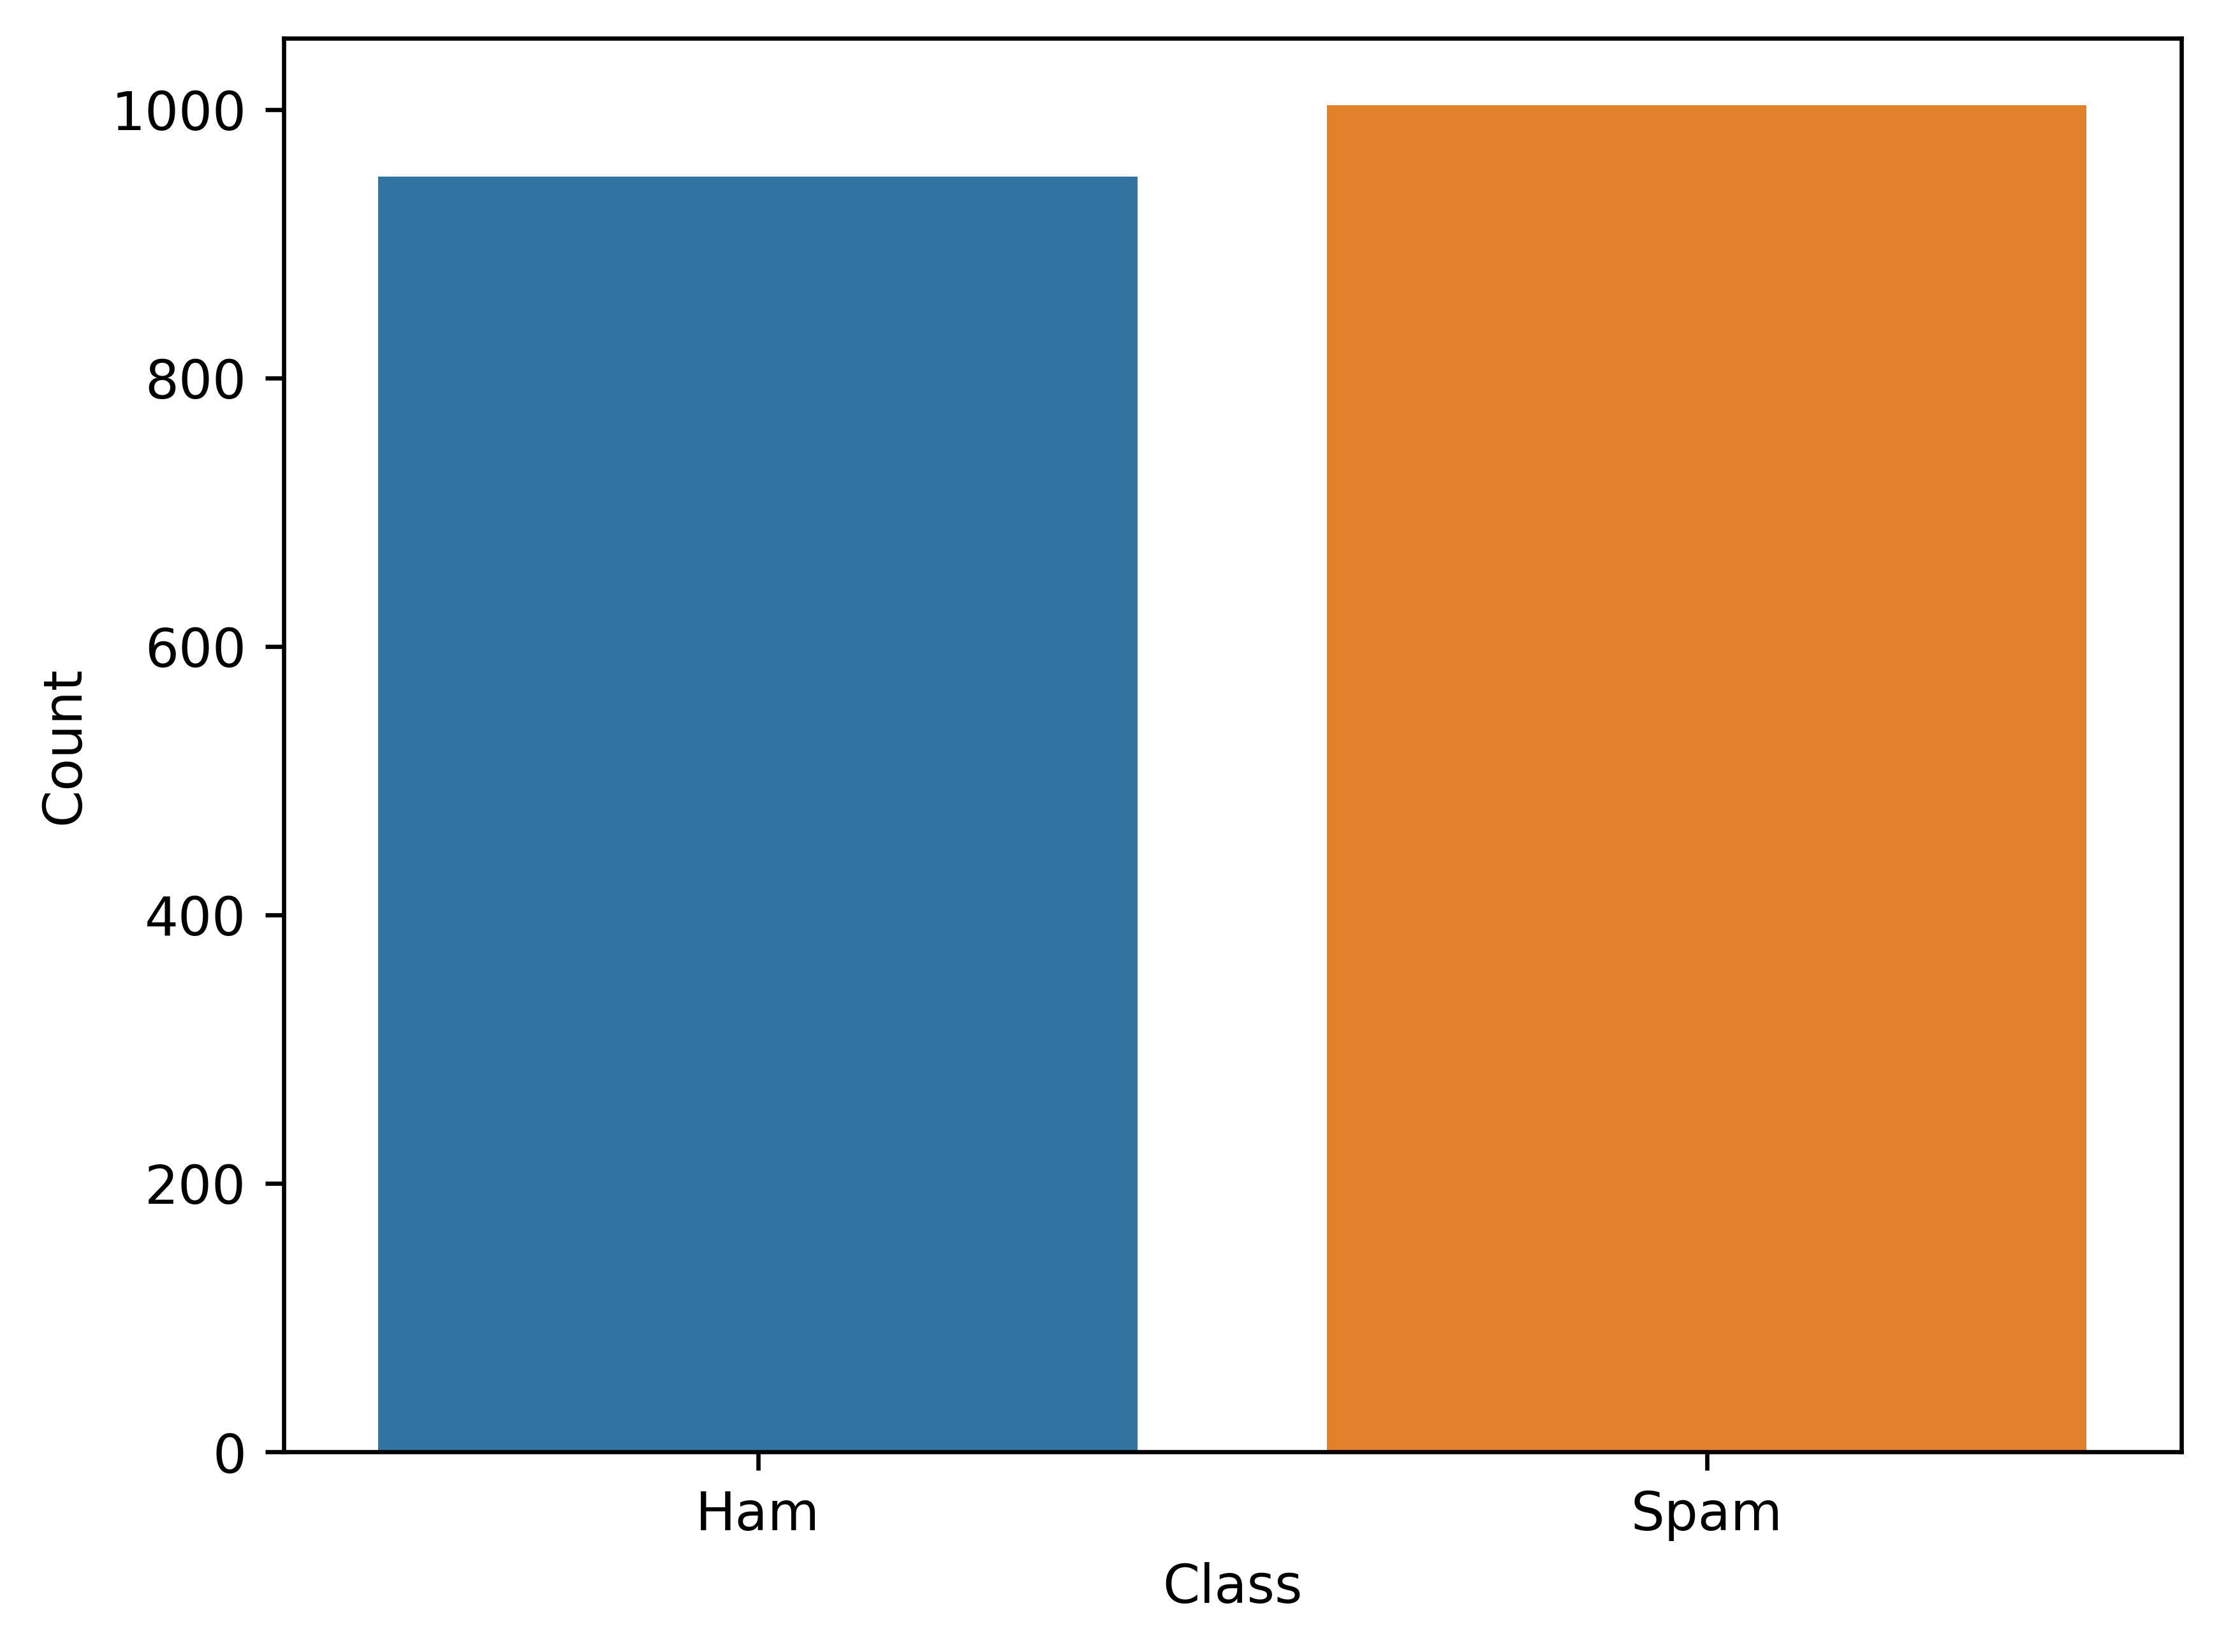

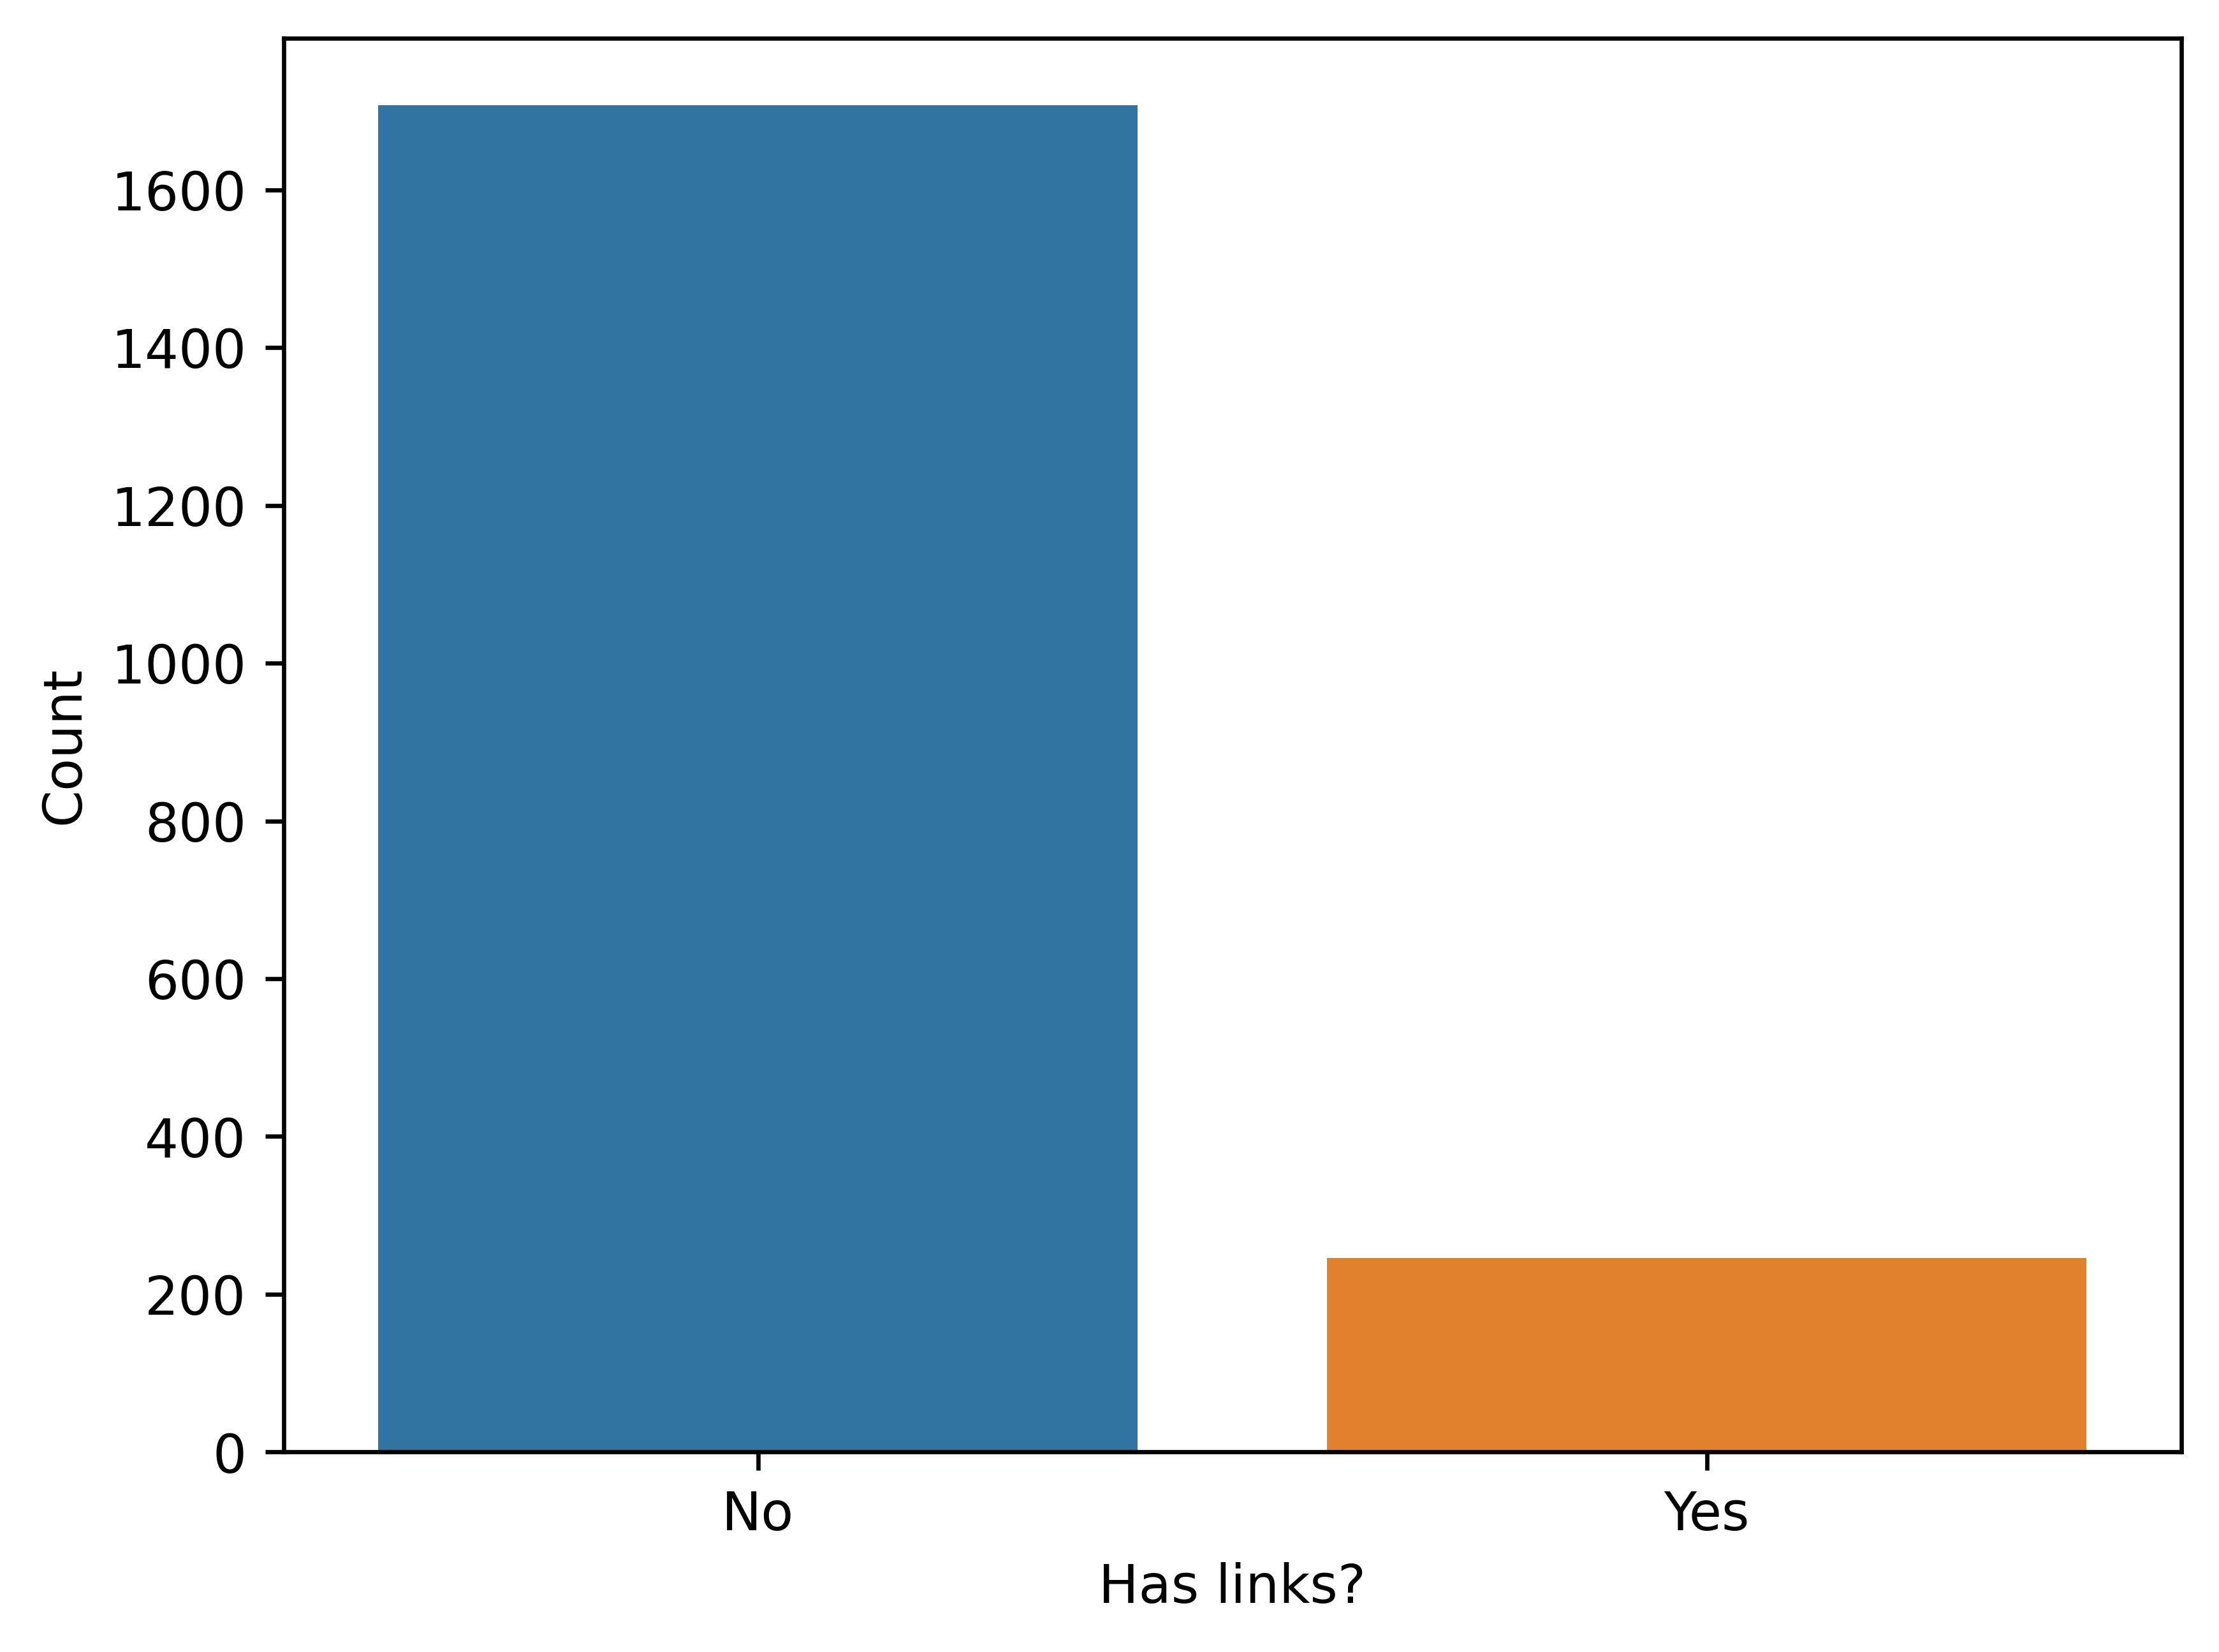

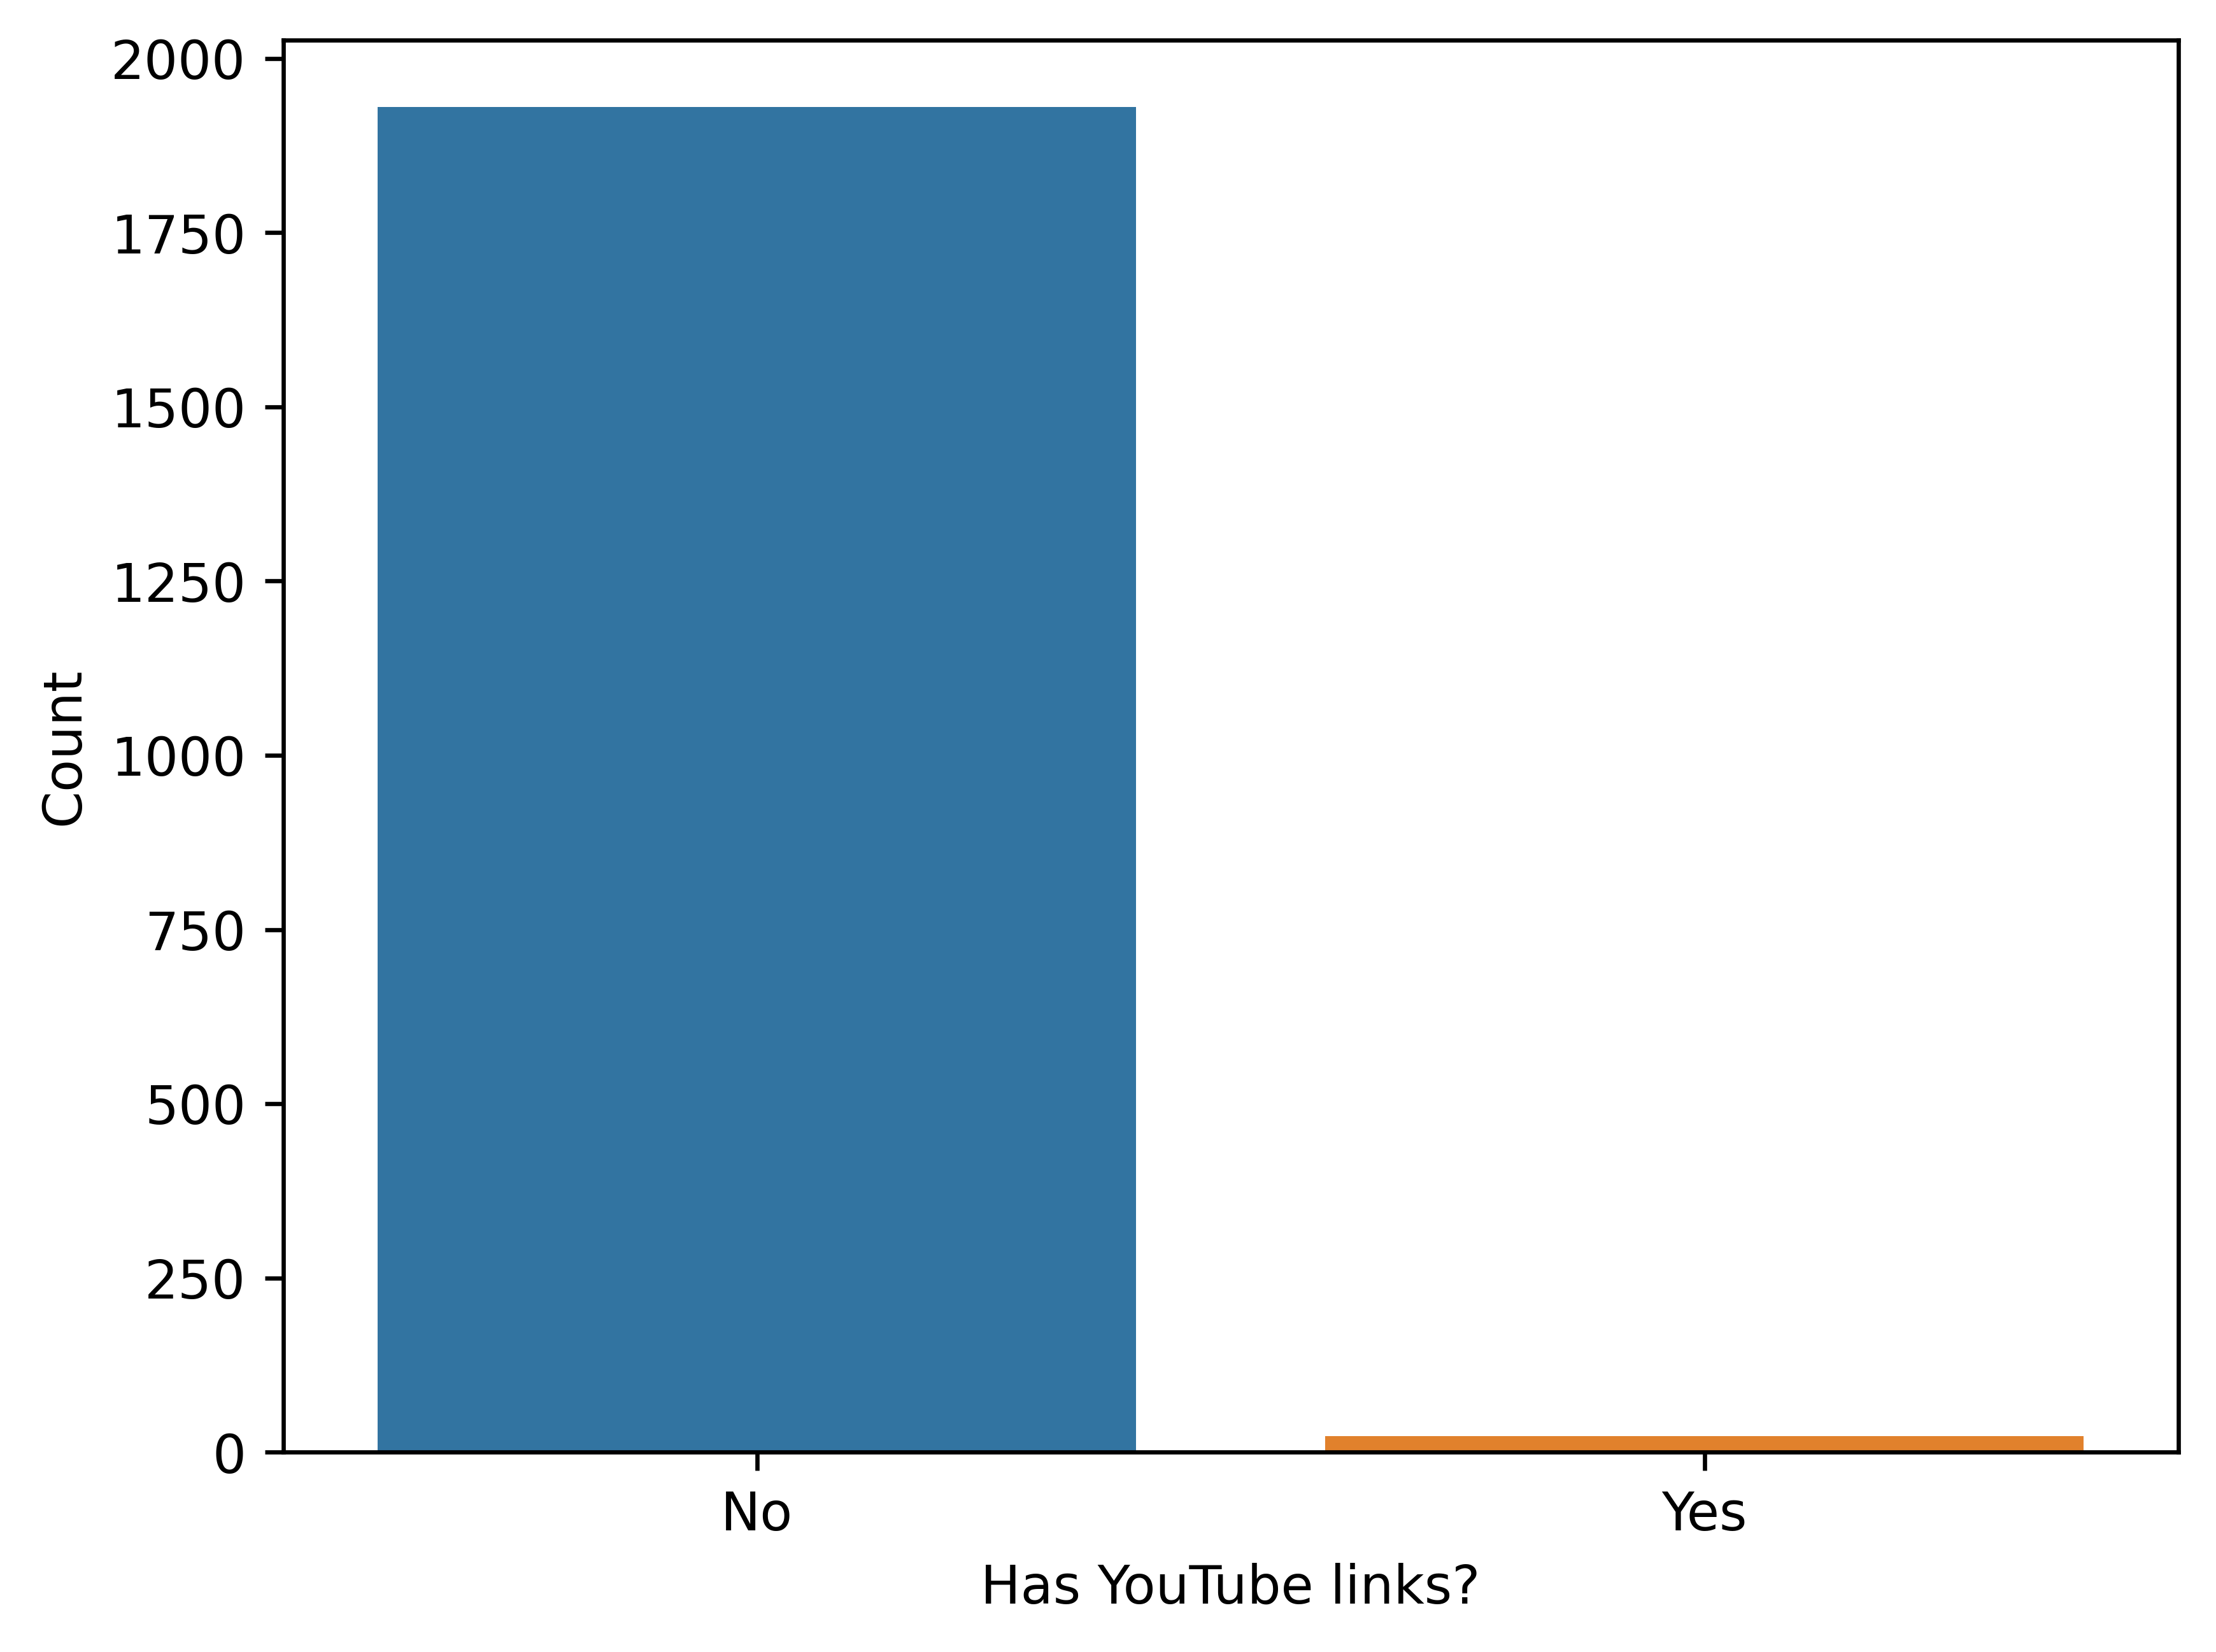

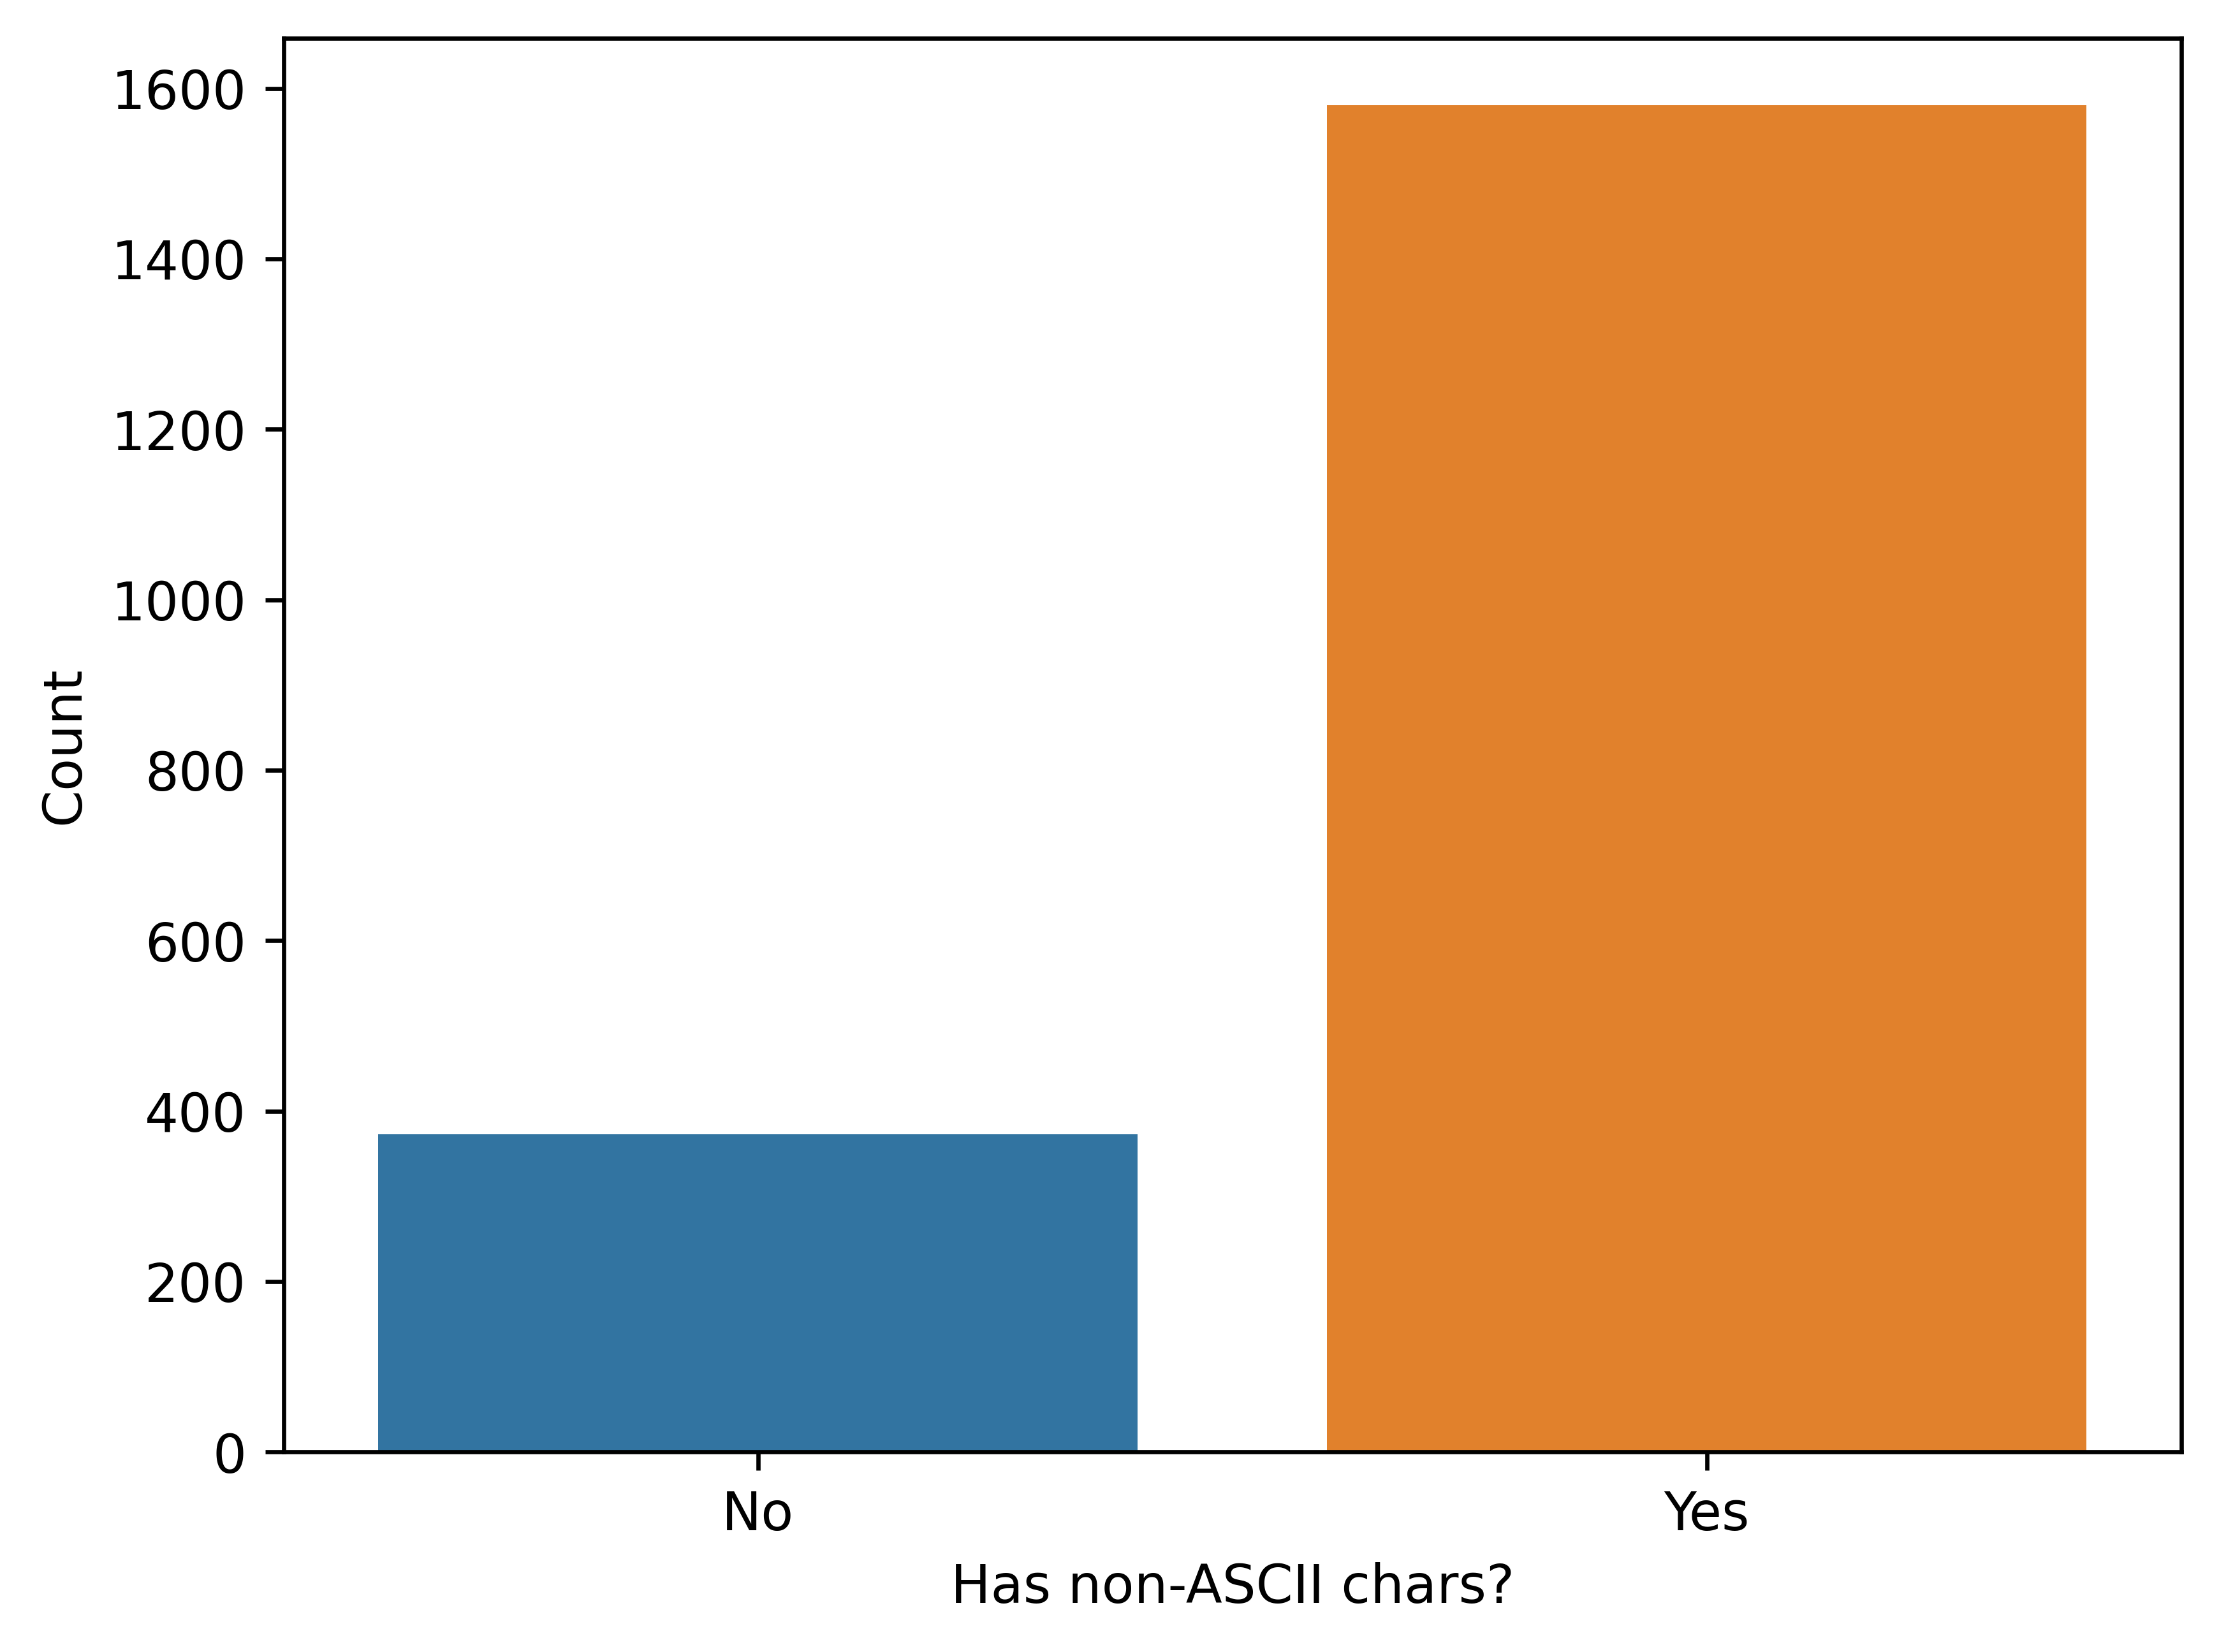

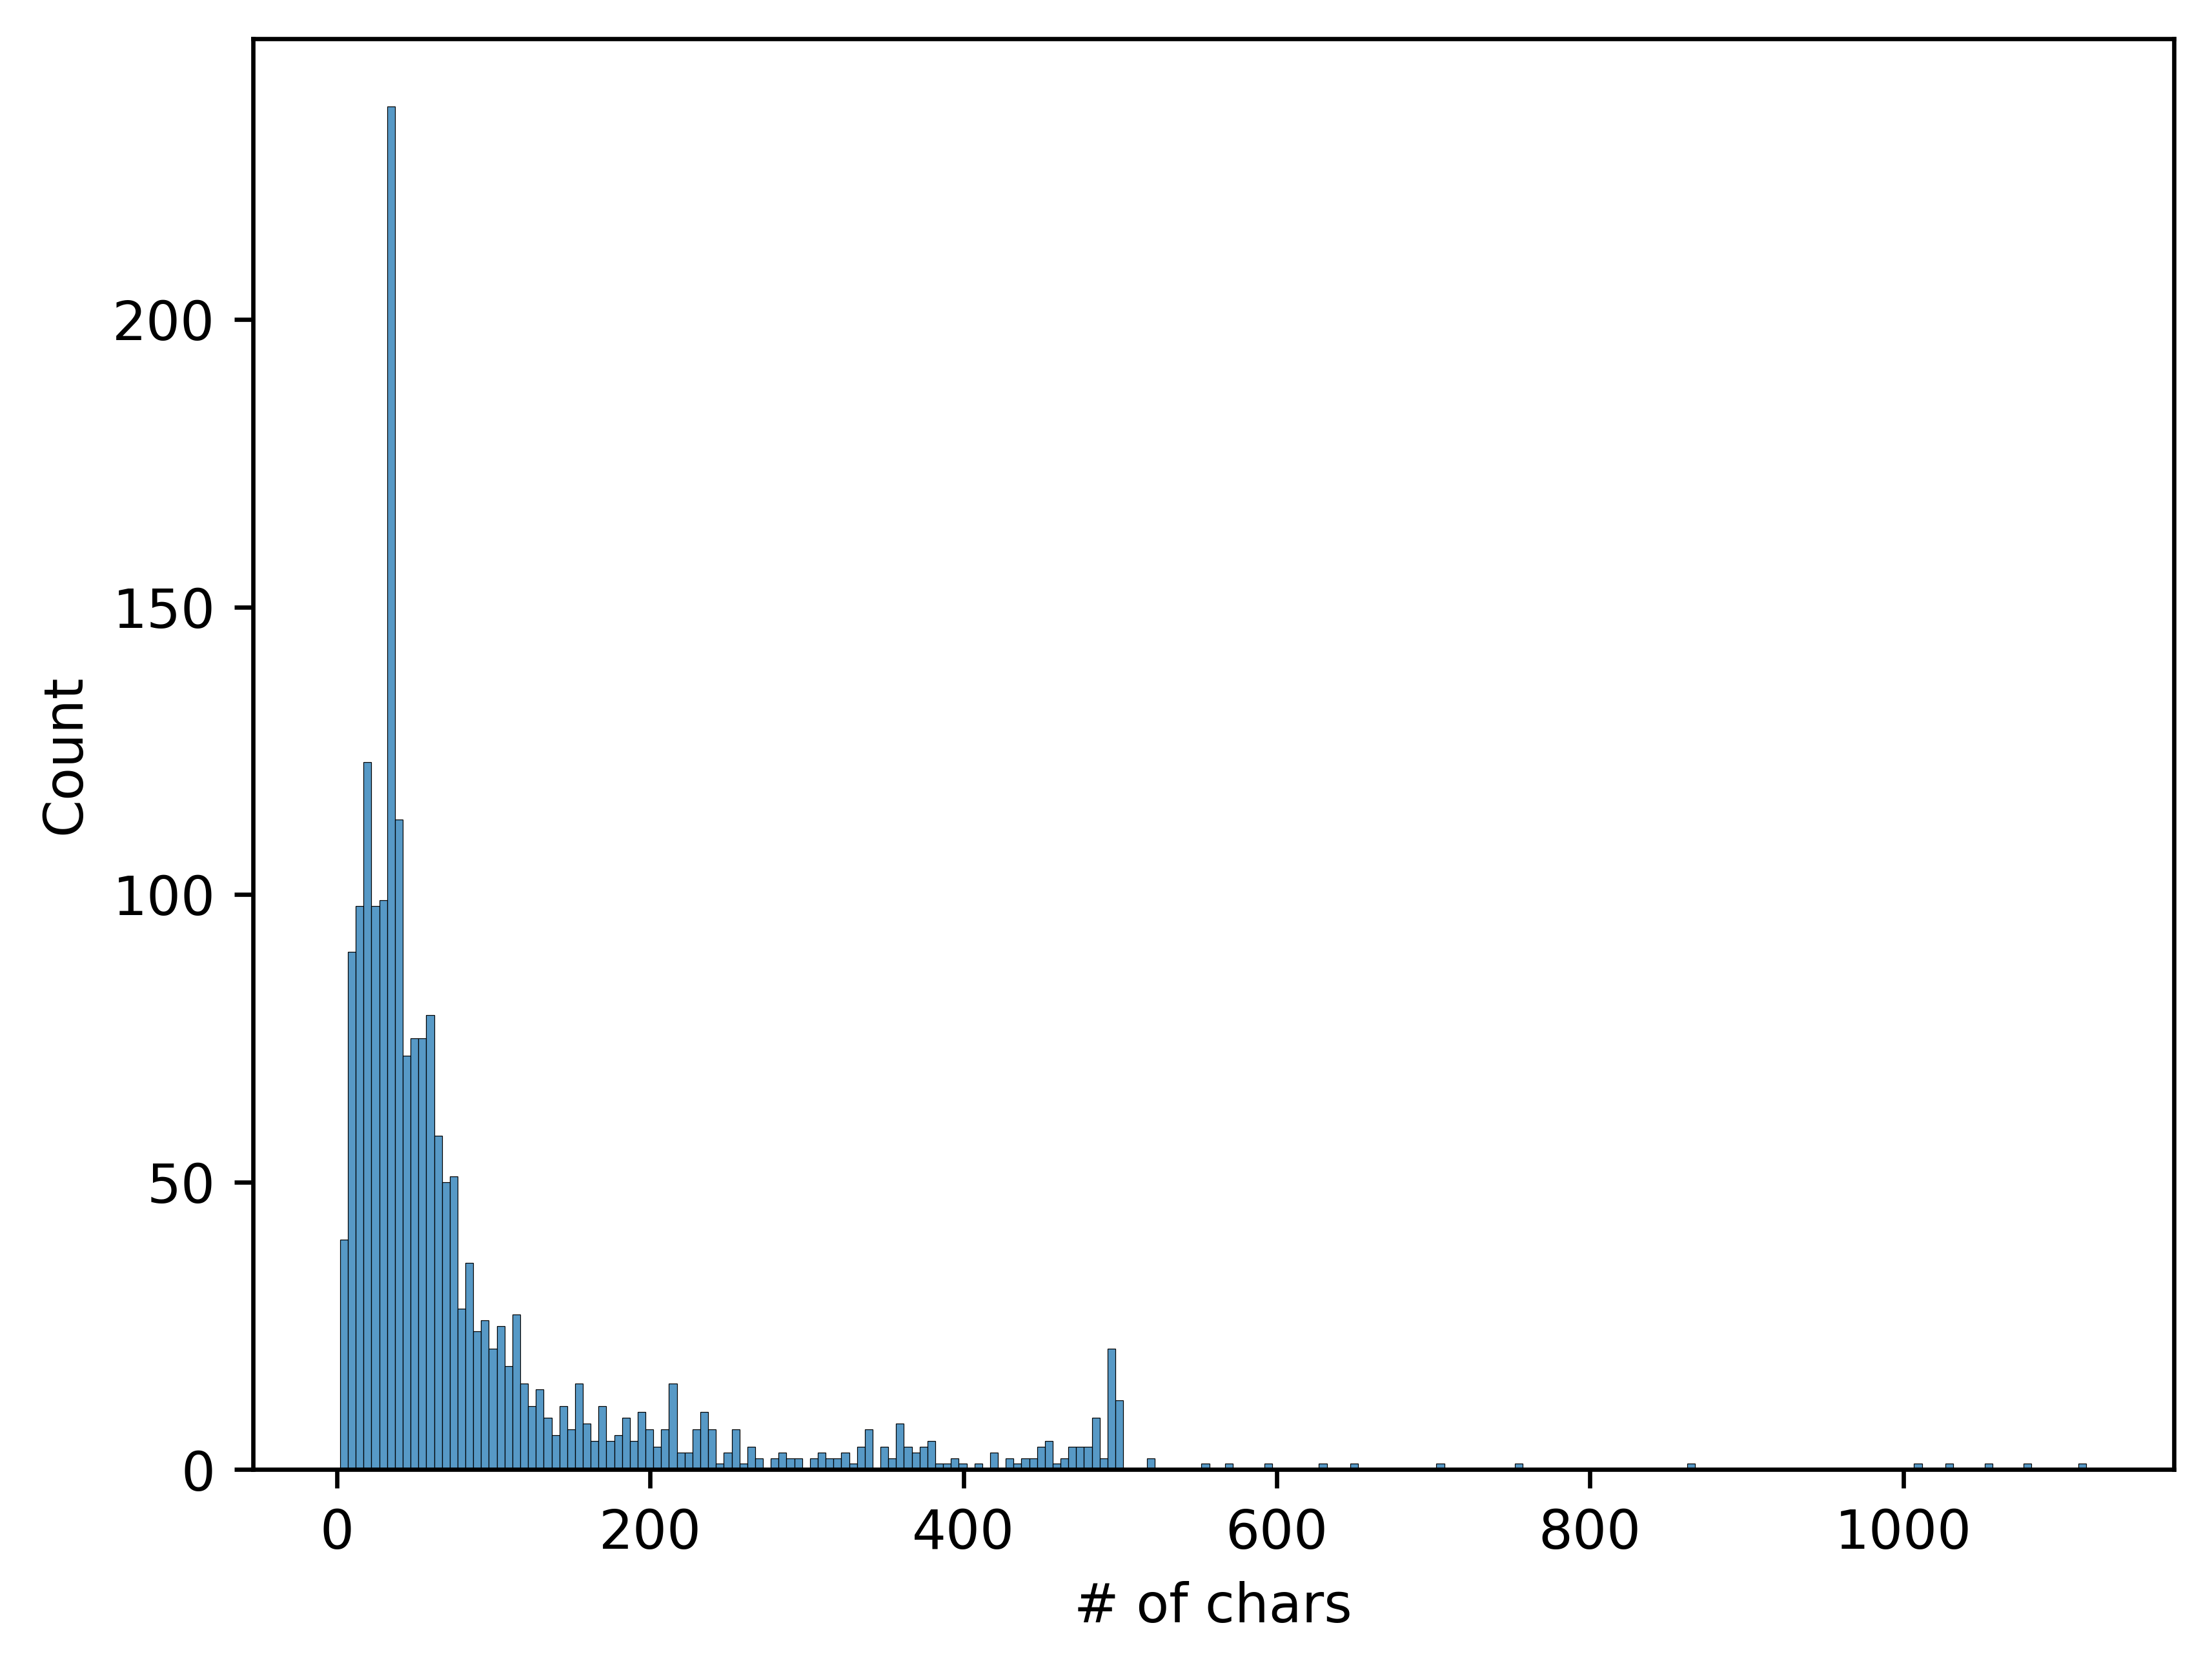

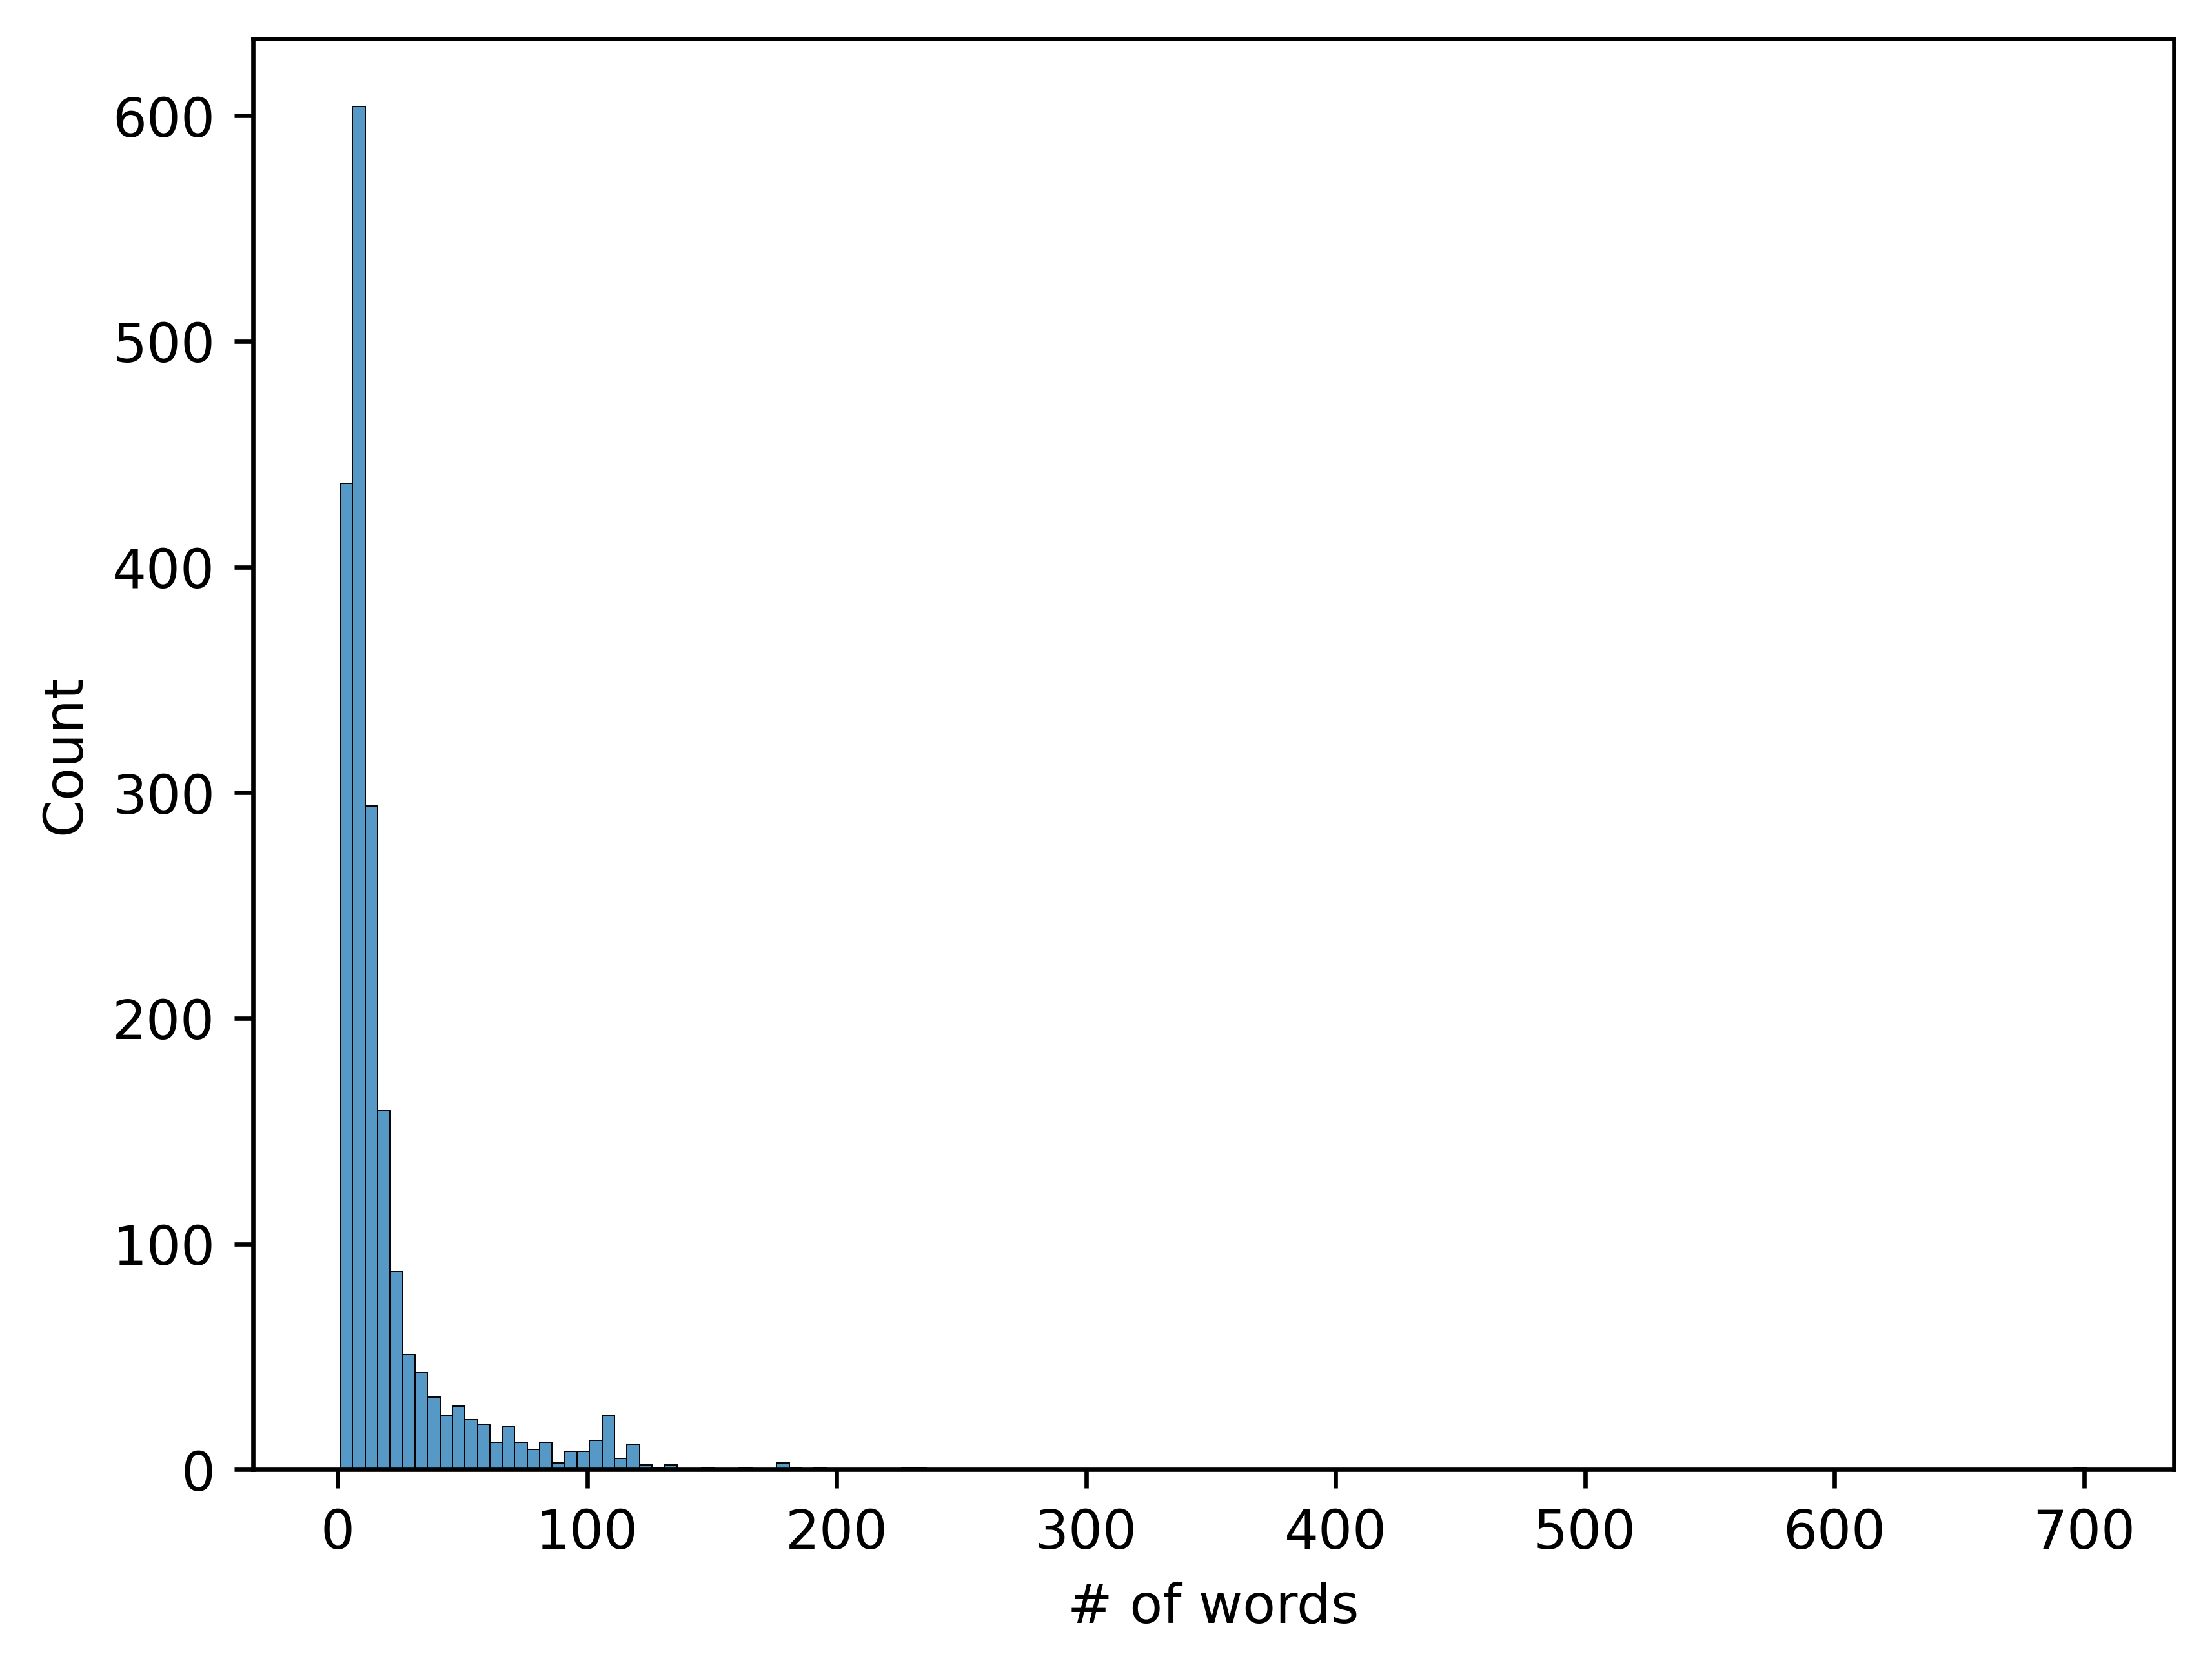

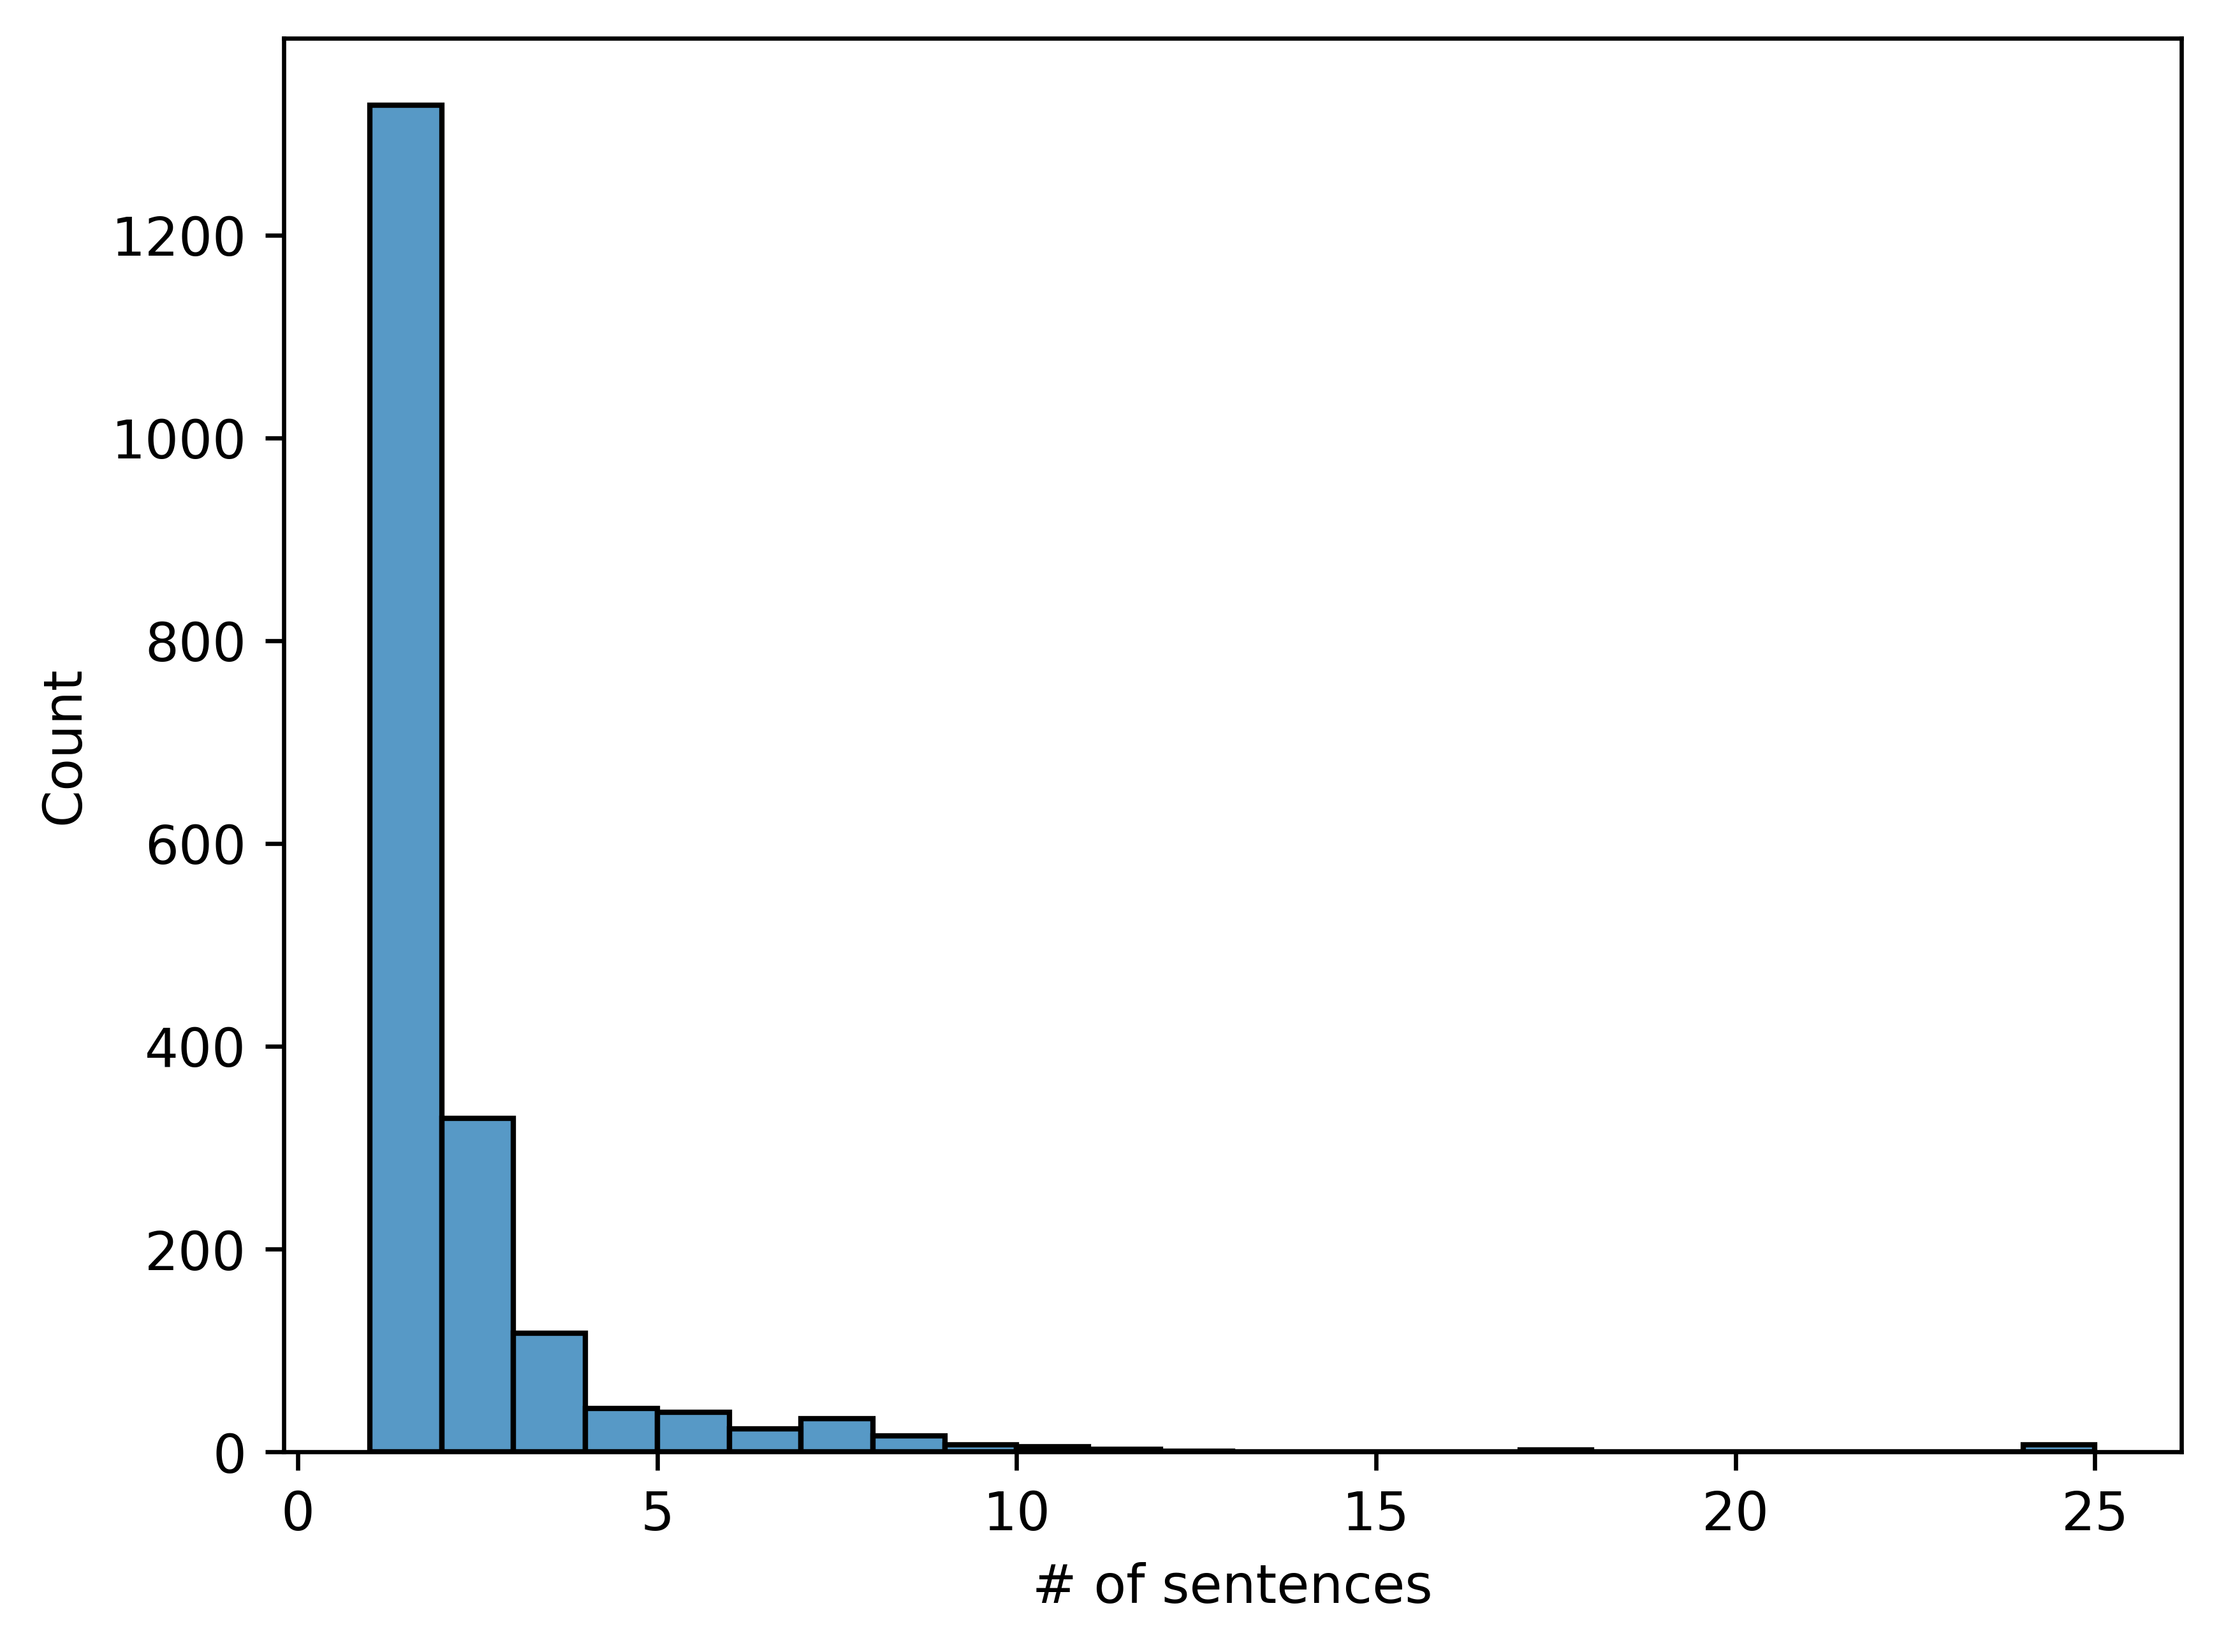

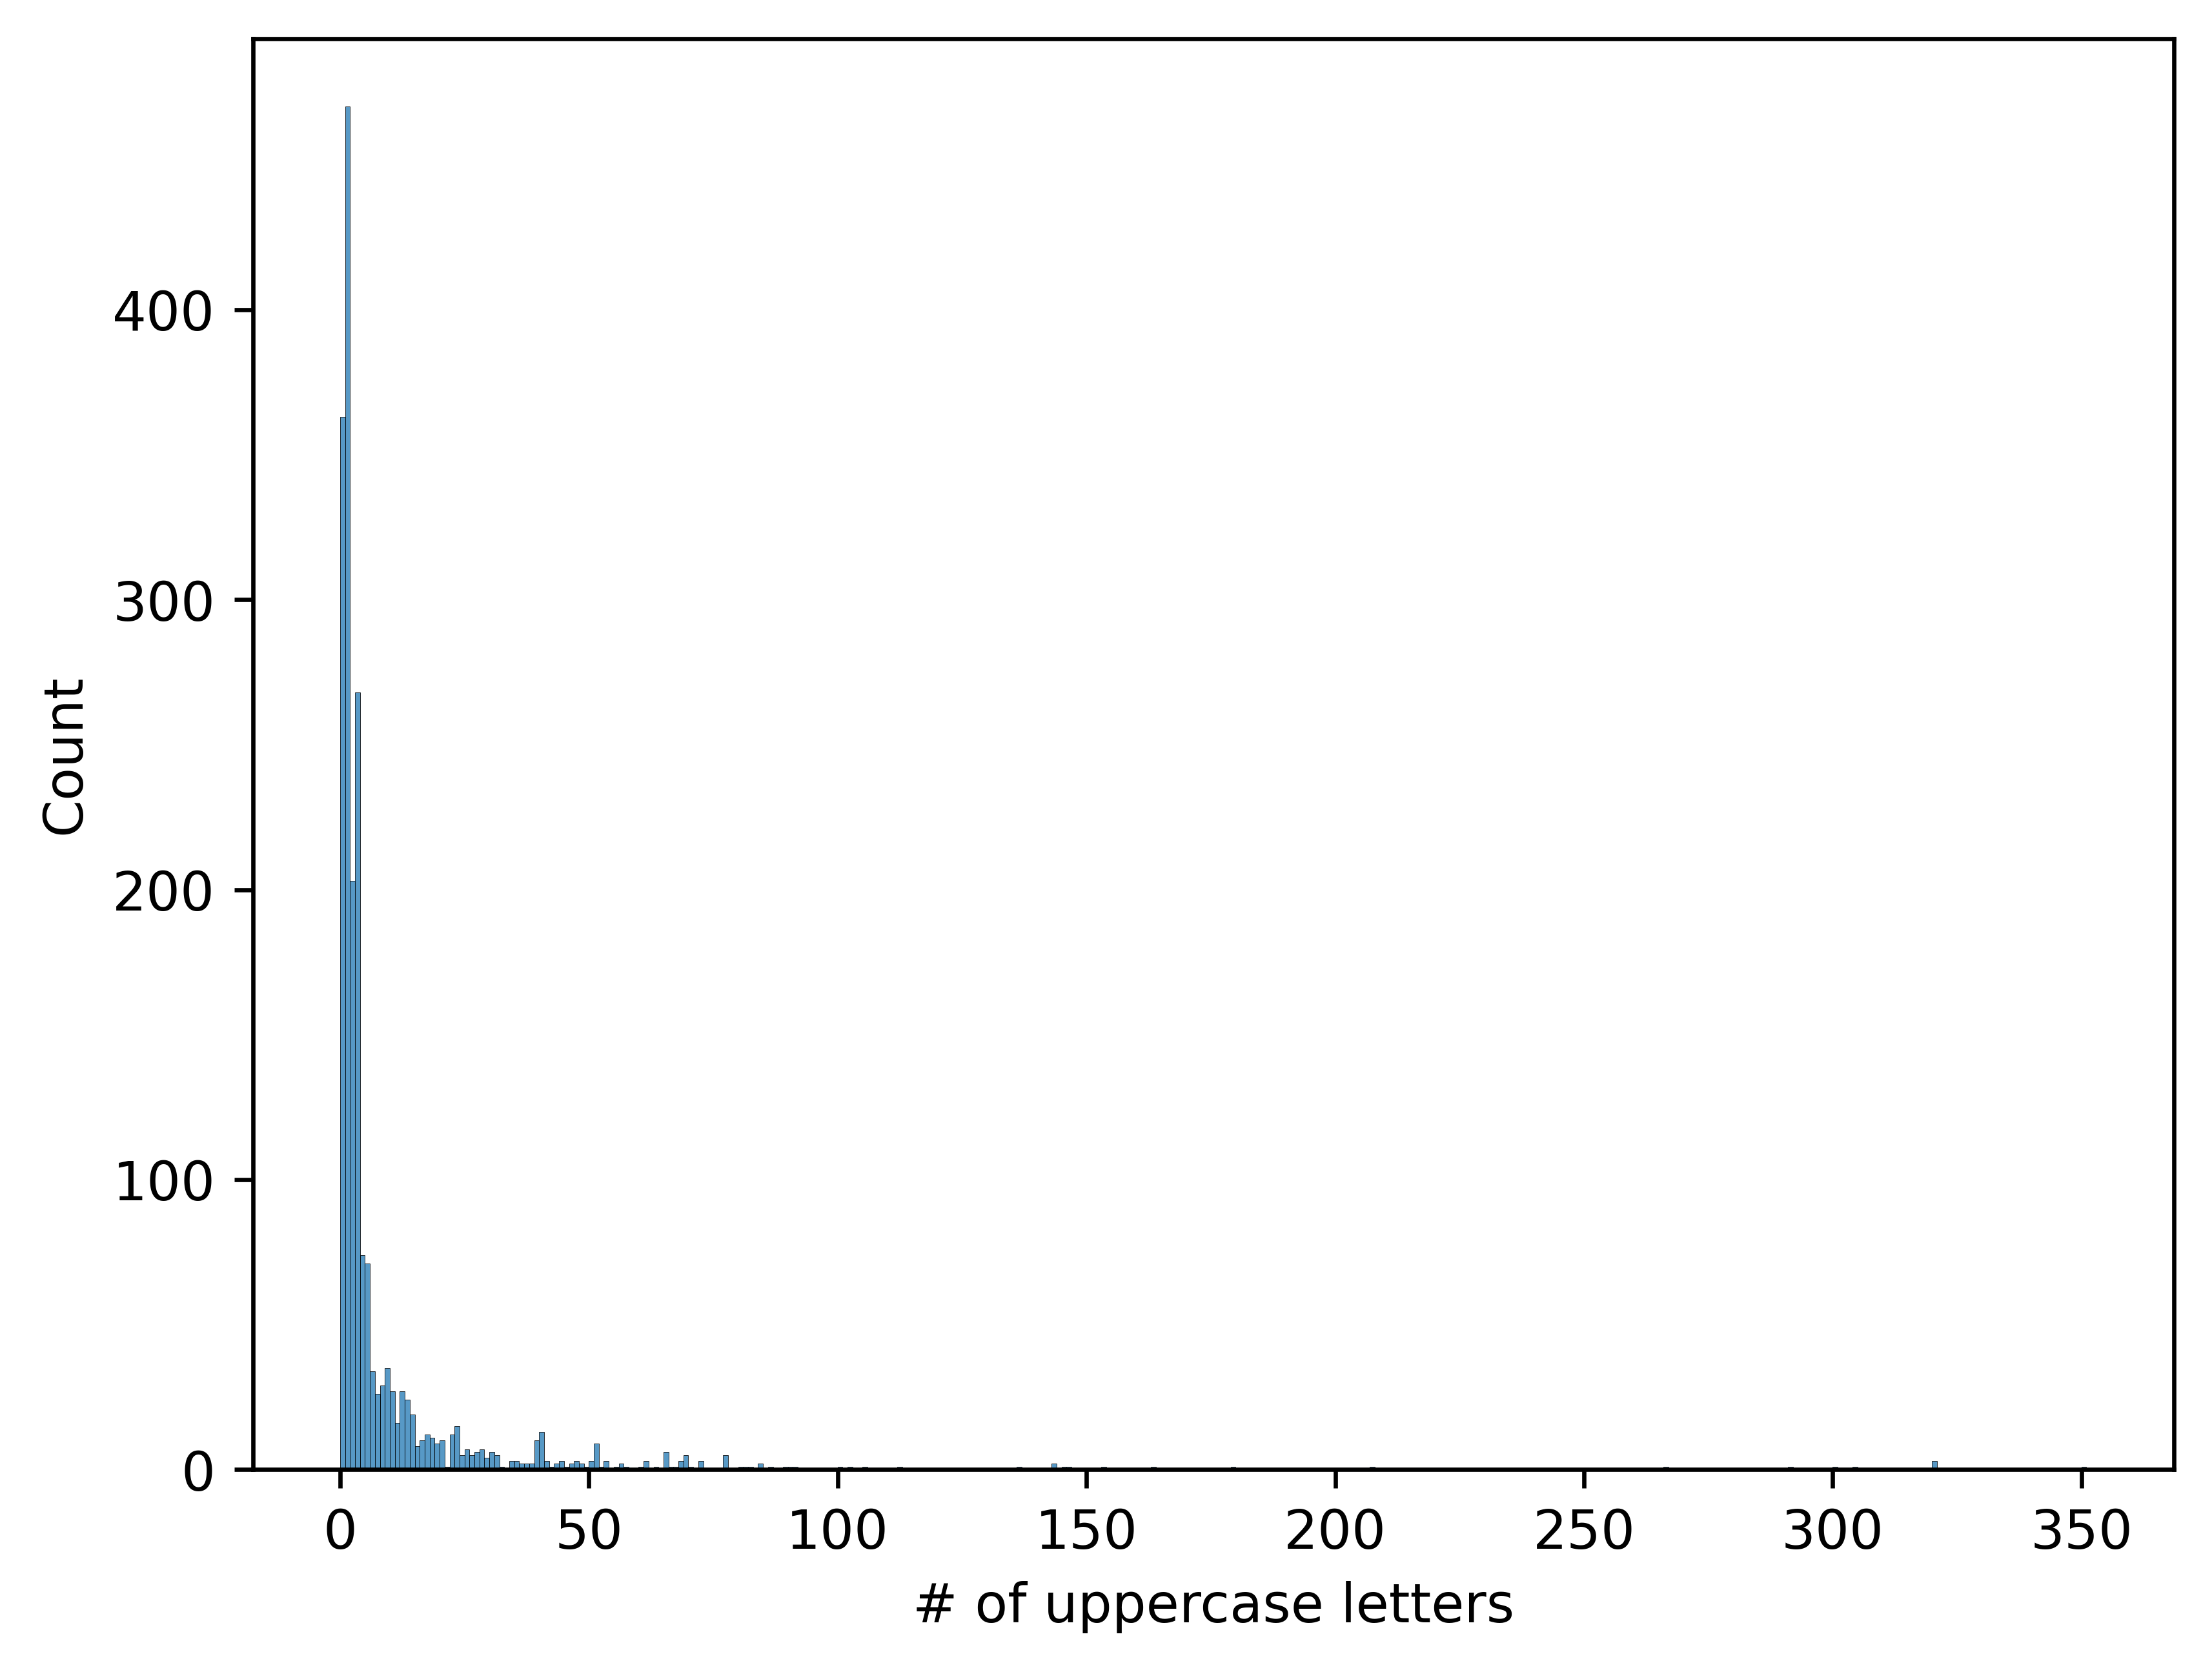

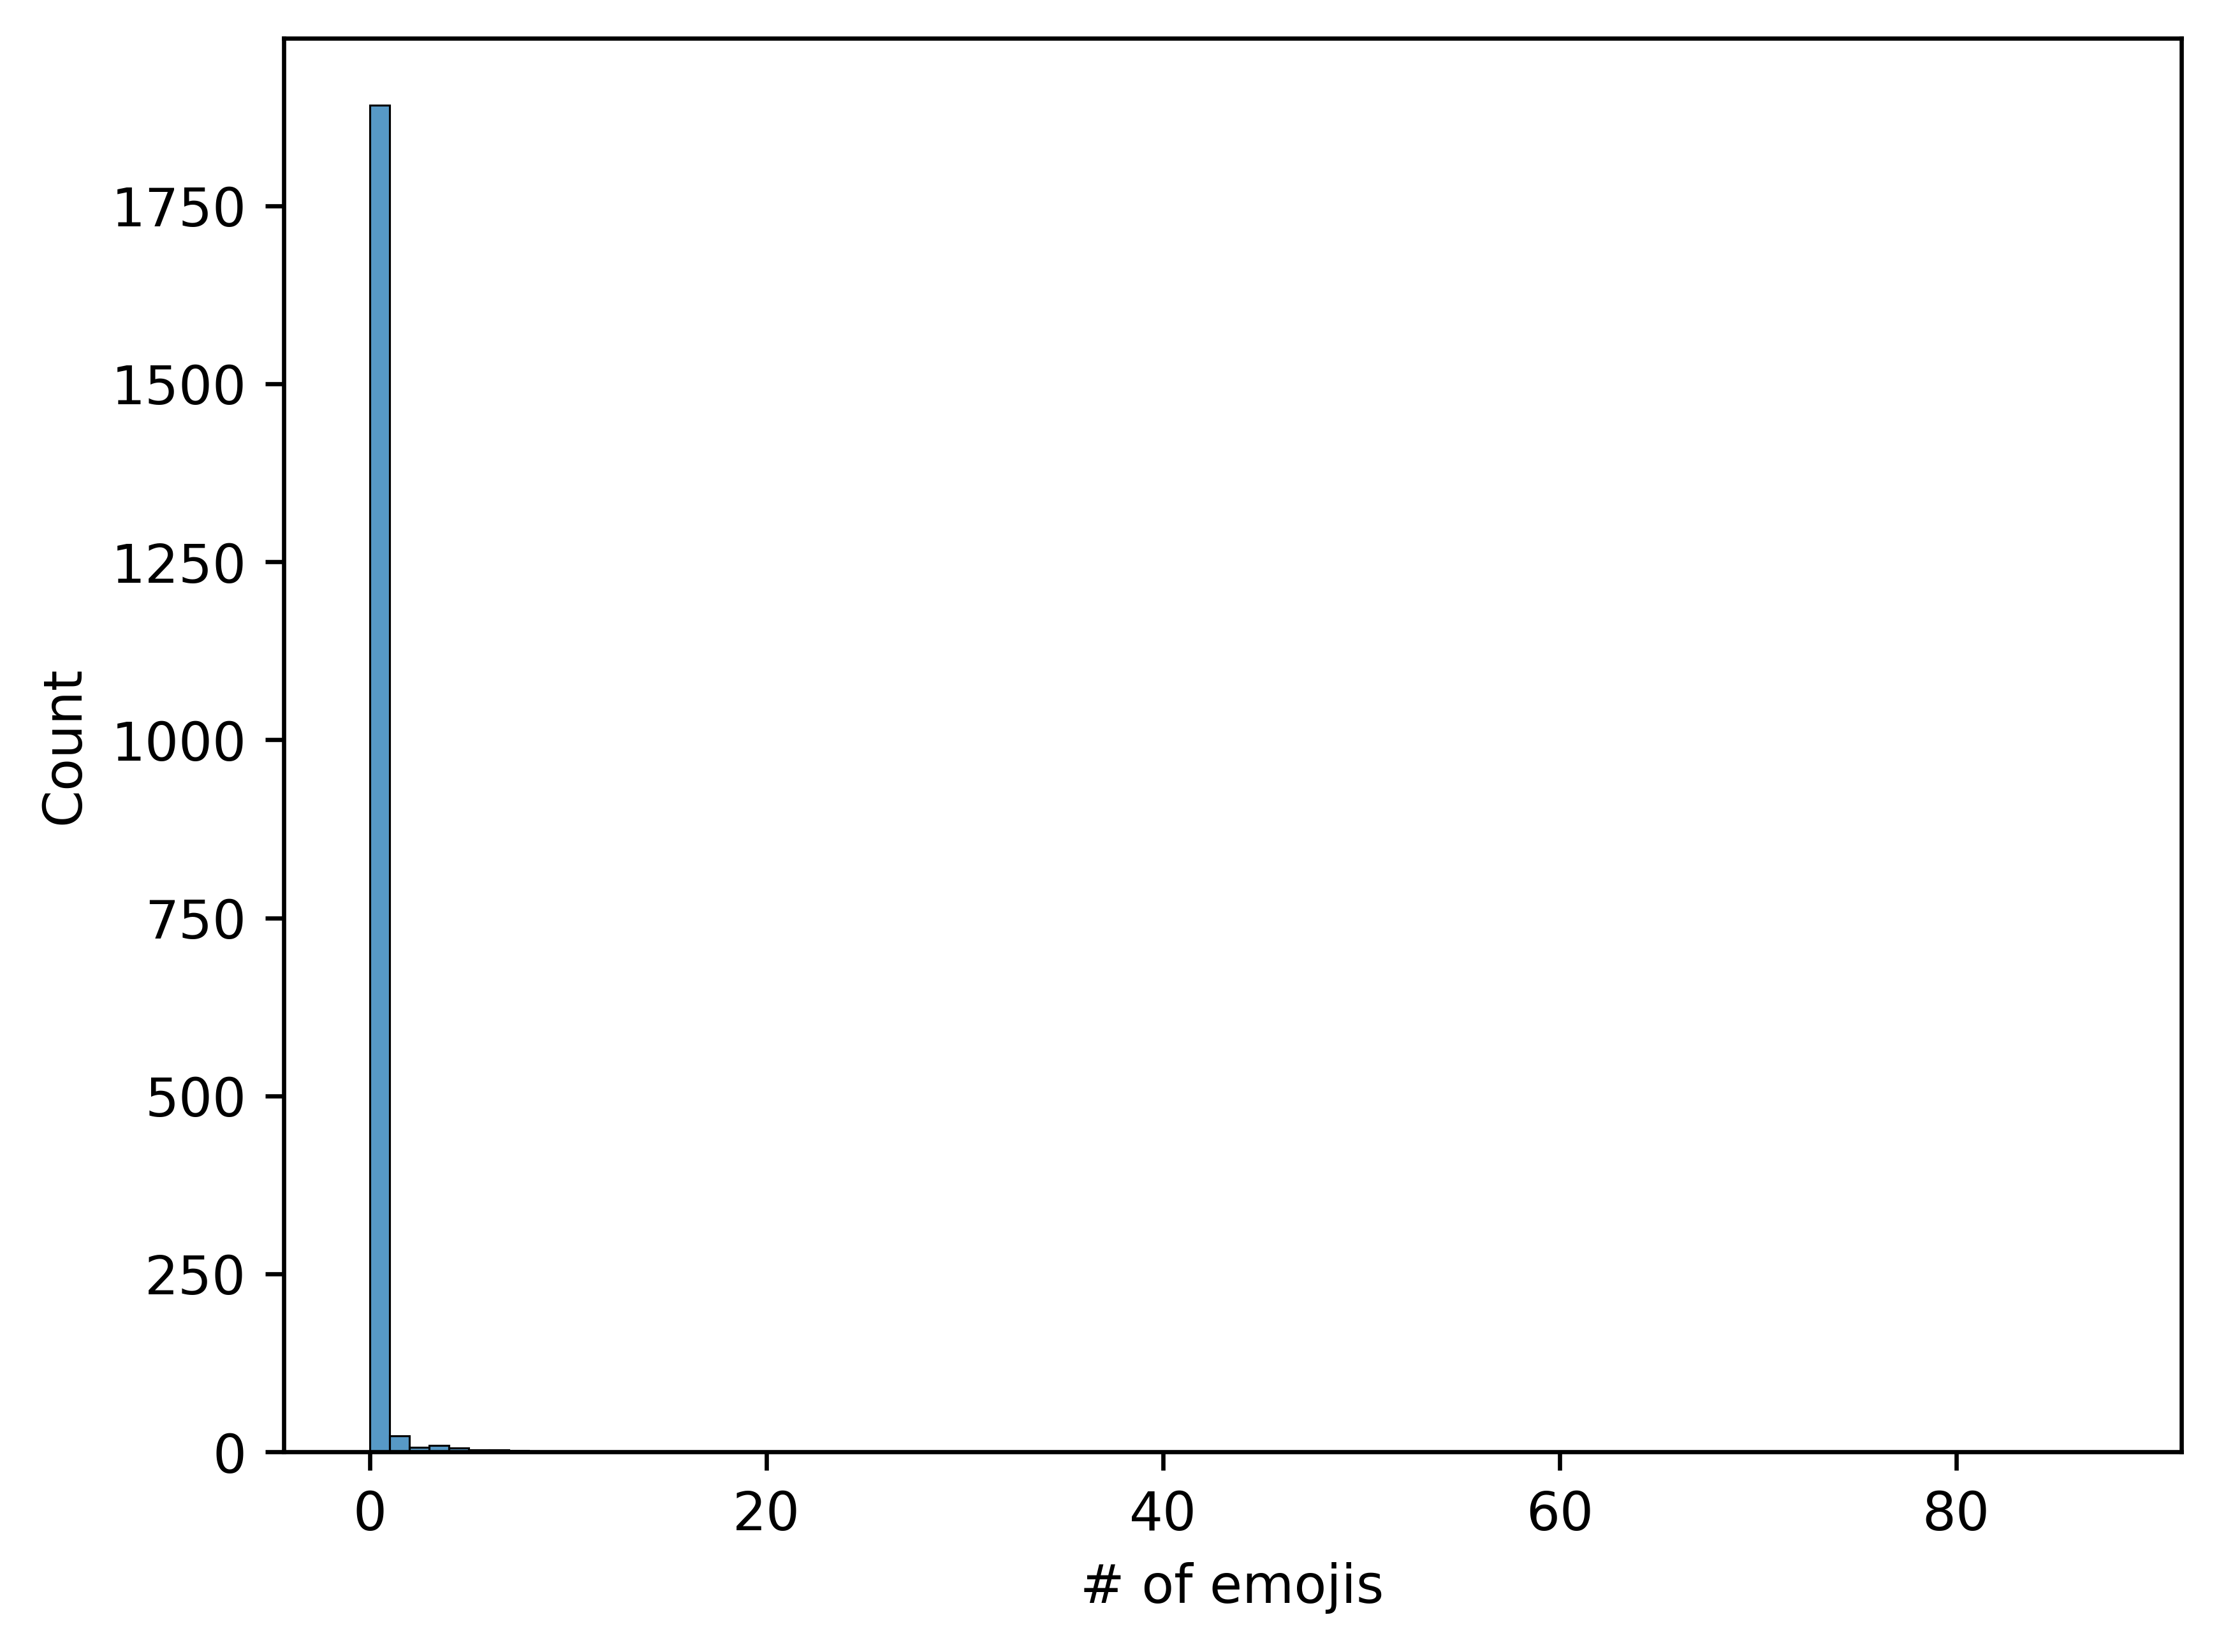

In [17]:
# Plot barplot/histogram of extracted features

copy = df.copy()

# sns.set(rc={'figure.facecolor':(0,0,0,0)})
plt.figure(dpi=600)

g = sns.countplot(x=copy.CLASS)
g.set_xticklabels(["Ham", "Spam"])
g.set_xlabel("Class")
g.set_ylabel("Count")
plt.savefig("figures/class_countplot", transparent=True)
plt.show()

plt.figure(dpi=600)
g = sns.countplot(
    x=copy.HAS_LINKS,
)
g.set_xticklabels(["No", "Yes"])
g.set_xlabel("Has links?")
g.set_ylabel("Count")
plt.savefig("figures/links_countplot", transparent=True)
plt.show()

plt.figure(dpi=600)
g = sns.countplot(x=copy.HAS_YT_LINKS)
g.set_xticklabels(["No", "Yes"])
g.set_xlabel("Has YouTube links?")
g.set_ylabel("Count")
plt.savefig("figures/yt_links_countplot", transparent=True)
plt.show()

plt.figure(dpi=600)
g = sns.countplot(x=copy.HAS_NON_ASCII_CHARS)
g.set_xticklabels(["No", "Yes"])
g.set_xlabel("Has non-ASCII chars?")
g.set_ylabel("Count")
plt.savefig("figures/non_ascii_countplot", transparent=True)
plt.show()

plt.figure(dpi=600)
g = sns.histplot(x=copy.CHAR_COUNT, binwidth=5)
g.set_xlabel("# of chars")
g.set_ylabel("Count")
plt.savefig("figures/chars_histplot", transparent=True)
plt.show()

plt.figure(dpi=600)
g = sns.histplot(x=copy.WORD_COUNT, binwidth=5)
g.set_xlabel("# of words")
g.set_ylabel("Count")
plt.savefig("figures/words_histplot", transparent=True)
plt.show()

plt.figure(dpi=600)
g = sns.histplot(x=copy.SENTENCE_COUNT, binwidth=1)
g.set_xlabel("# of sentences")
g.set_ylabel("Count")
plt.savefig("figures/sentences_histplot", transparent=True)
plt.show()

plt.figure(dpi=600)
g = sns.histplot(x=copy.UPPERCASE_COUNT, binwidth=1)
g.set_xlabel("# of uppercase letters")
g.set_ylabel("Count")
plt.savefig("figures/uppercases_histplot", transparent=True)
plt.show()

plt.figure(dpi=600)
g = sns.histplot(x=copy.EMOJI_COUNT, binwidth=1)
g.set_xlabel("# of emojis")
g.set_ylabel("Count")
plt.savefig("figures/emojis_histplot", transparent=True)
plt.show()

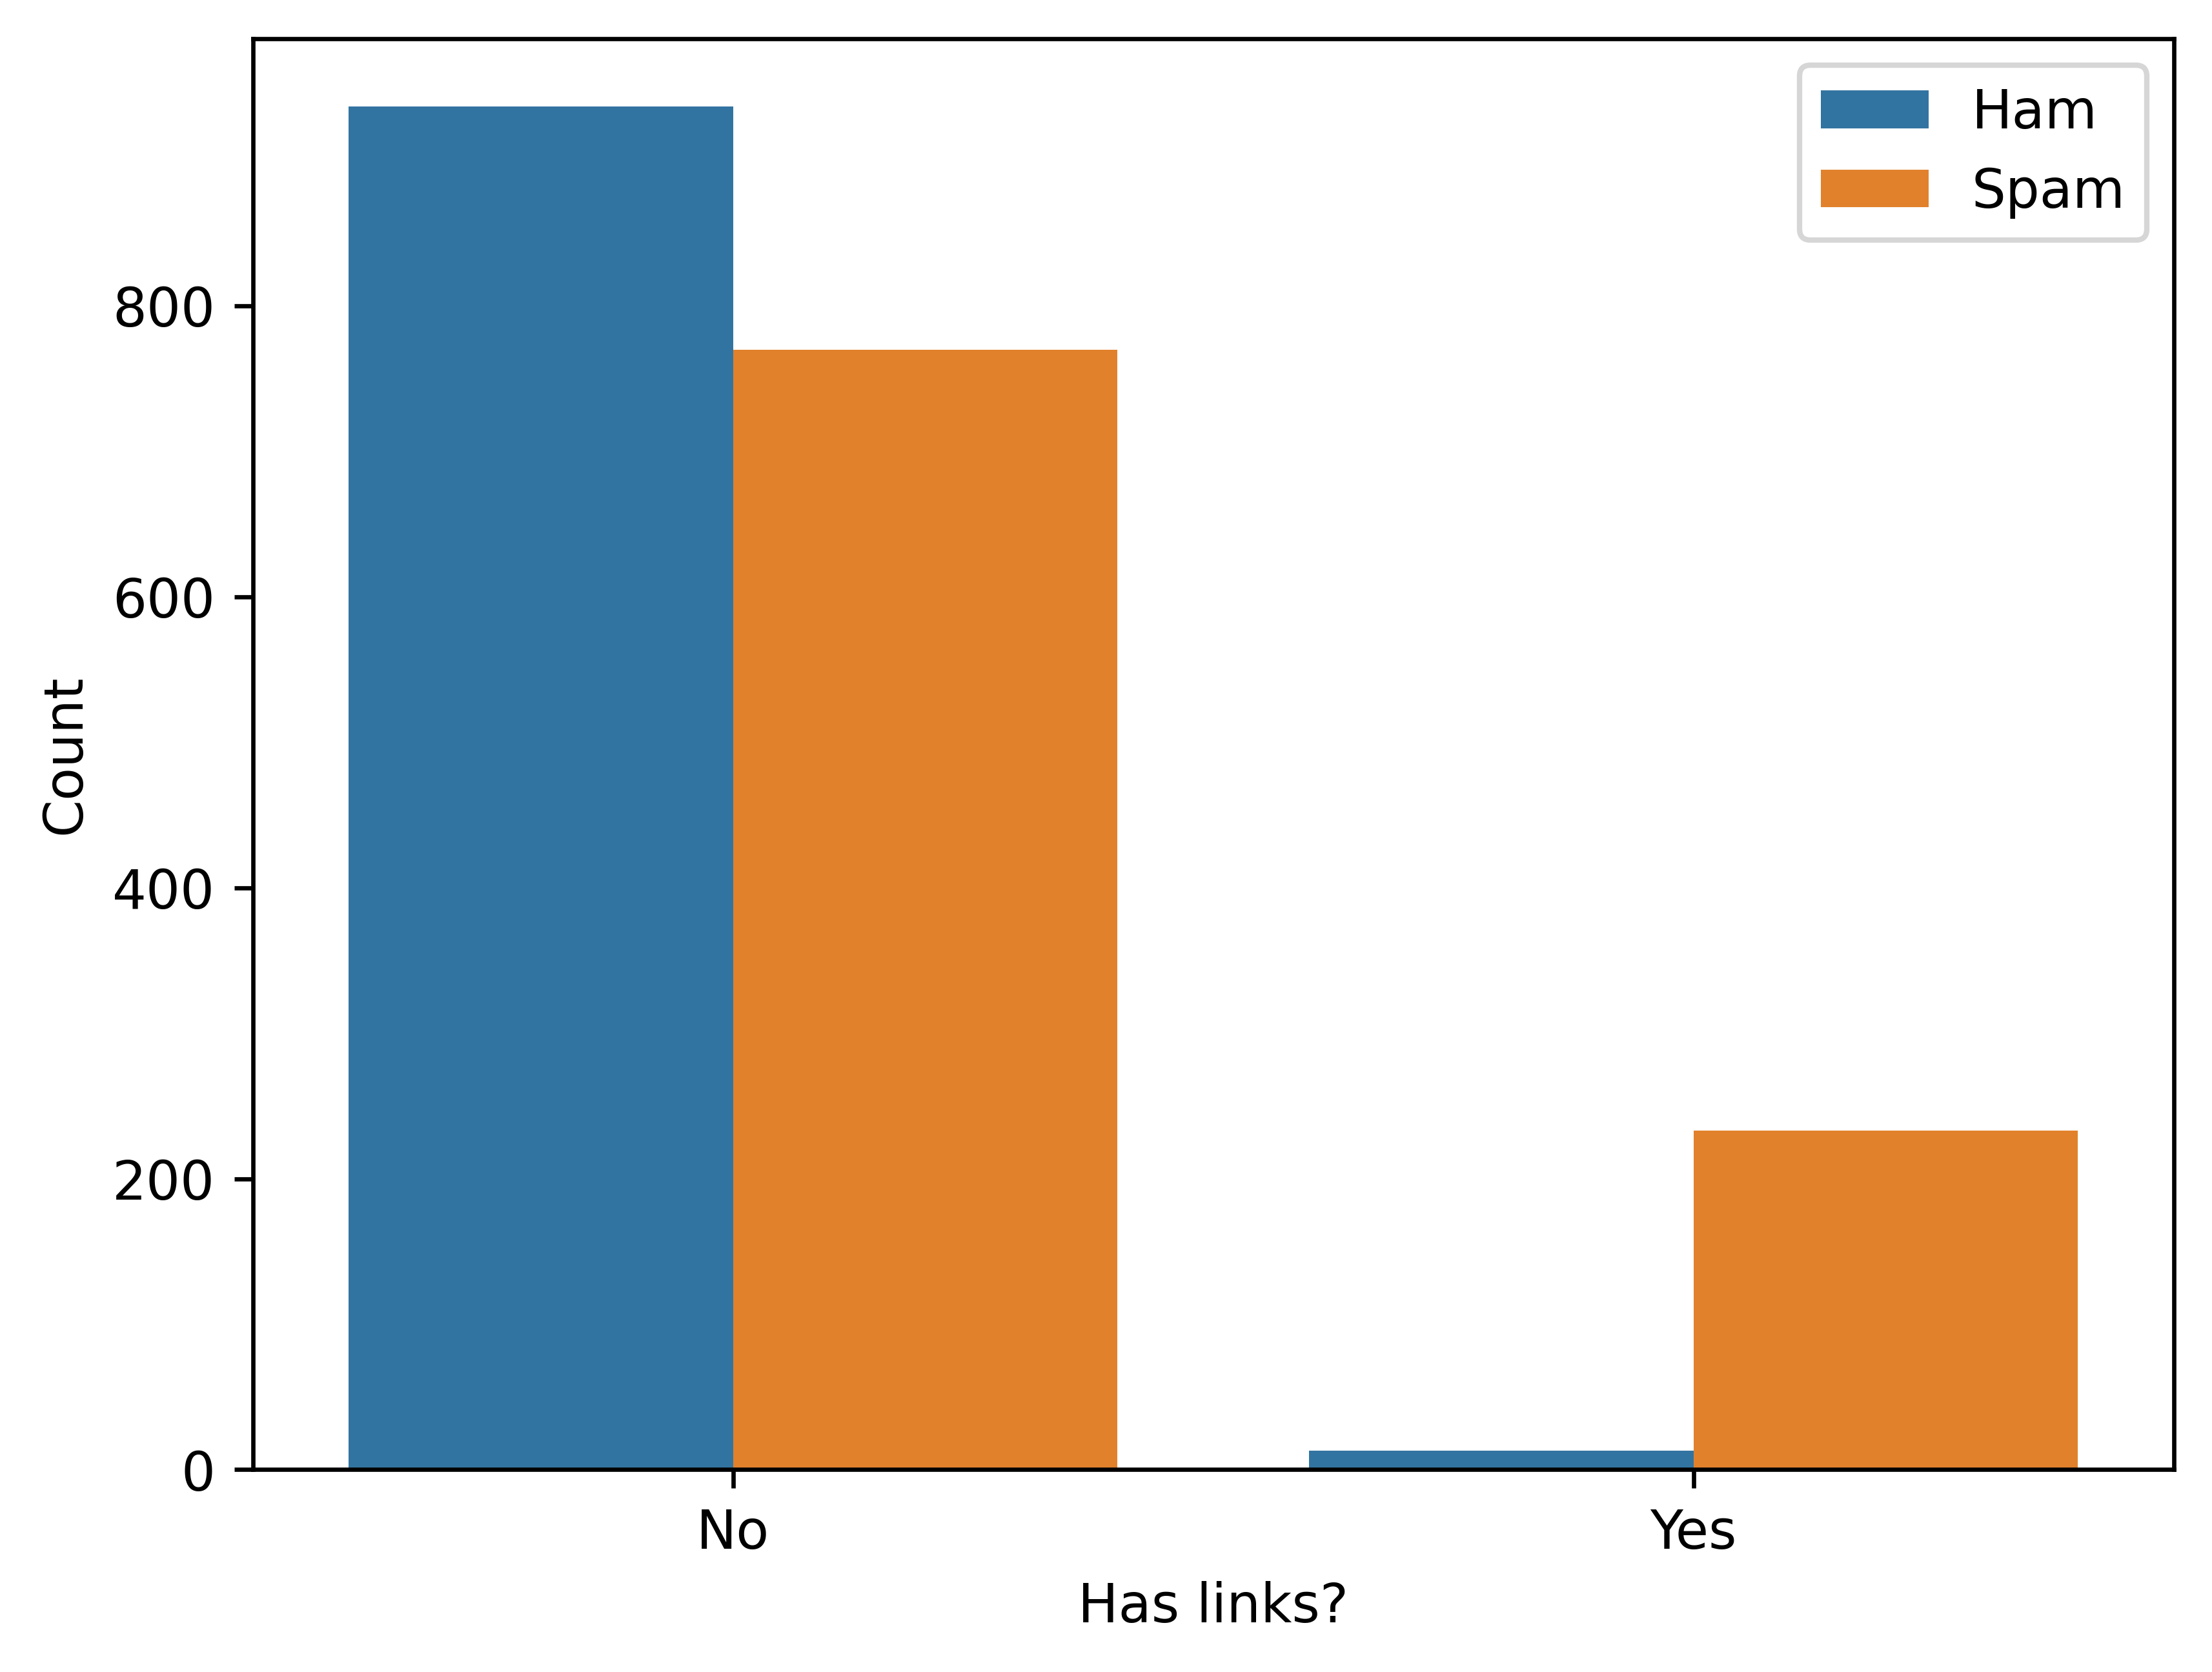

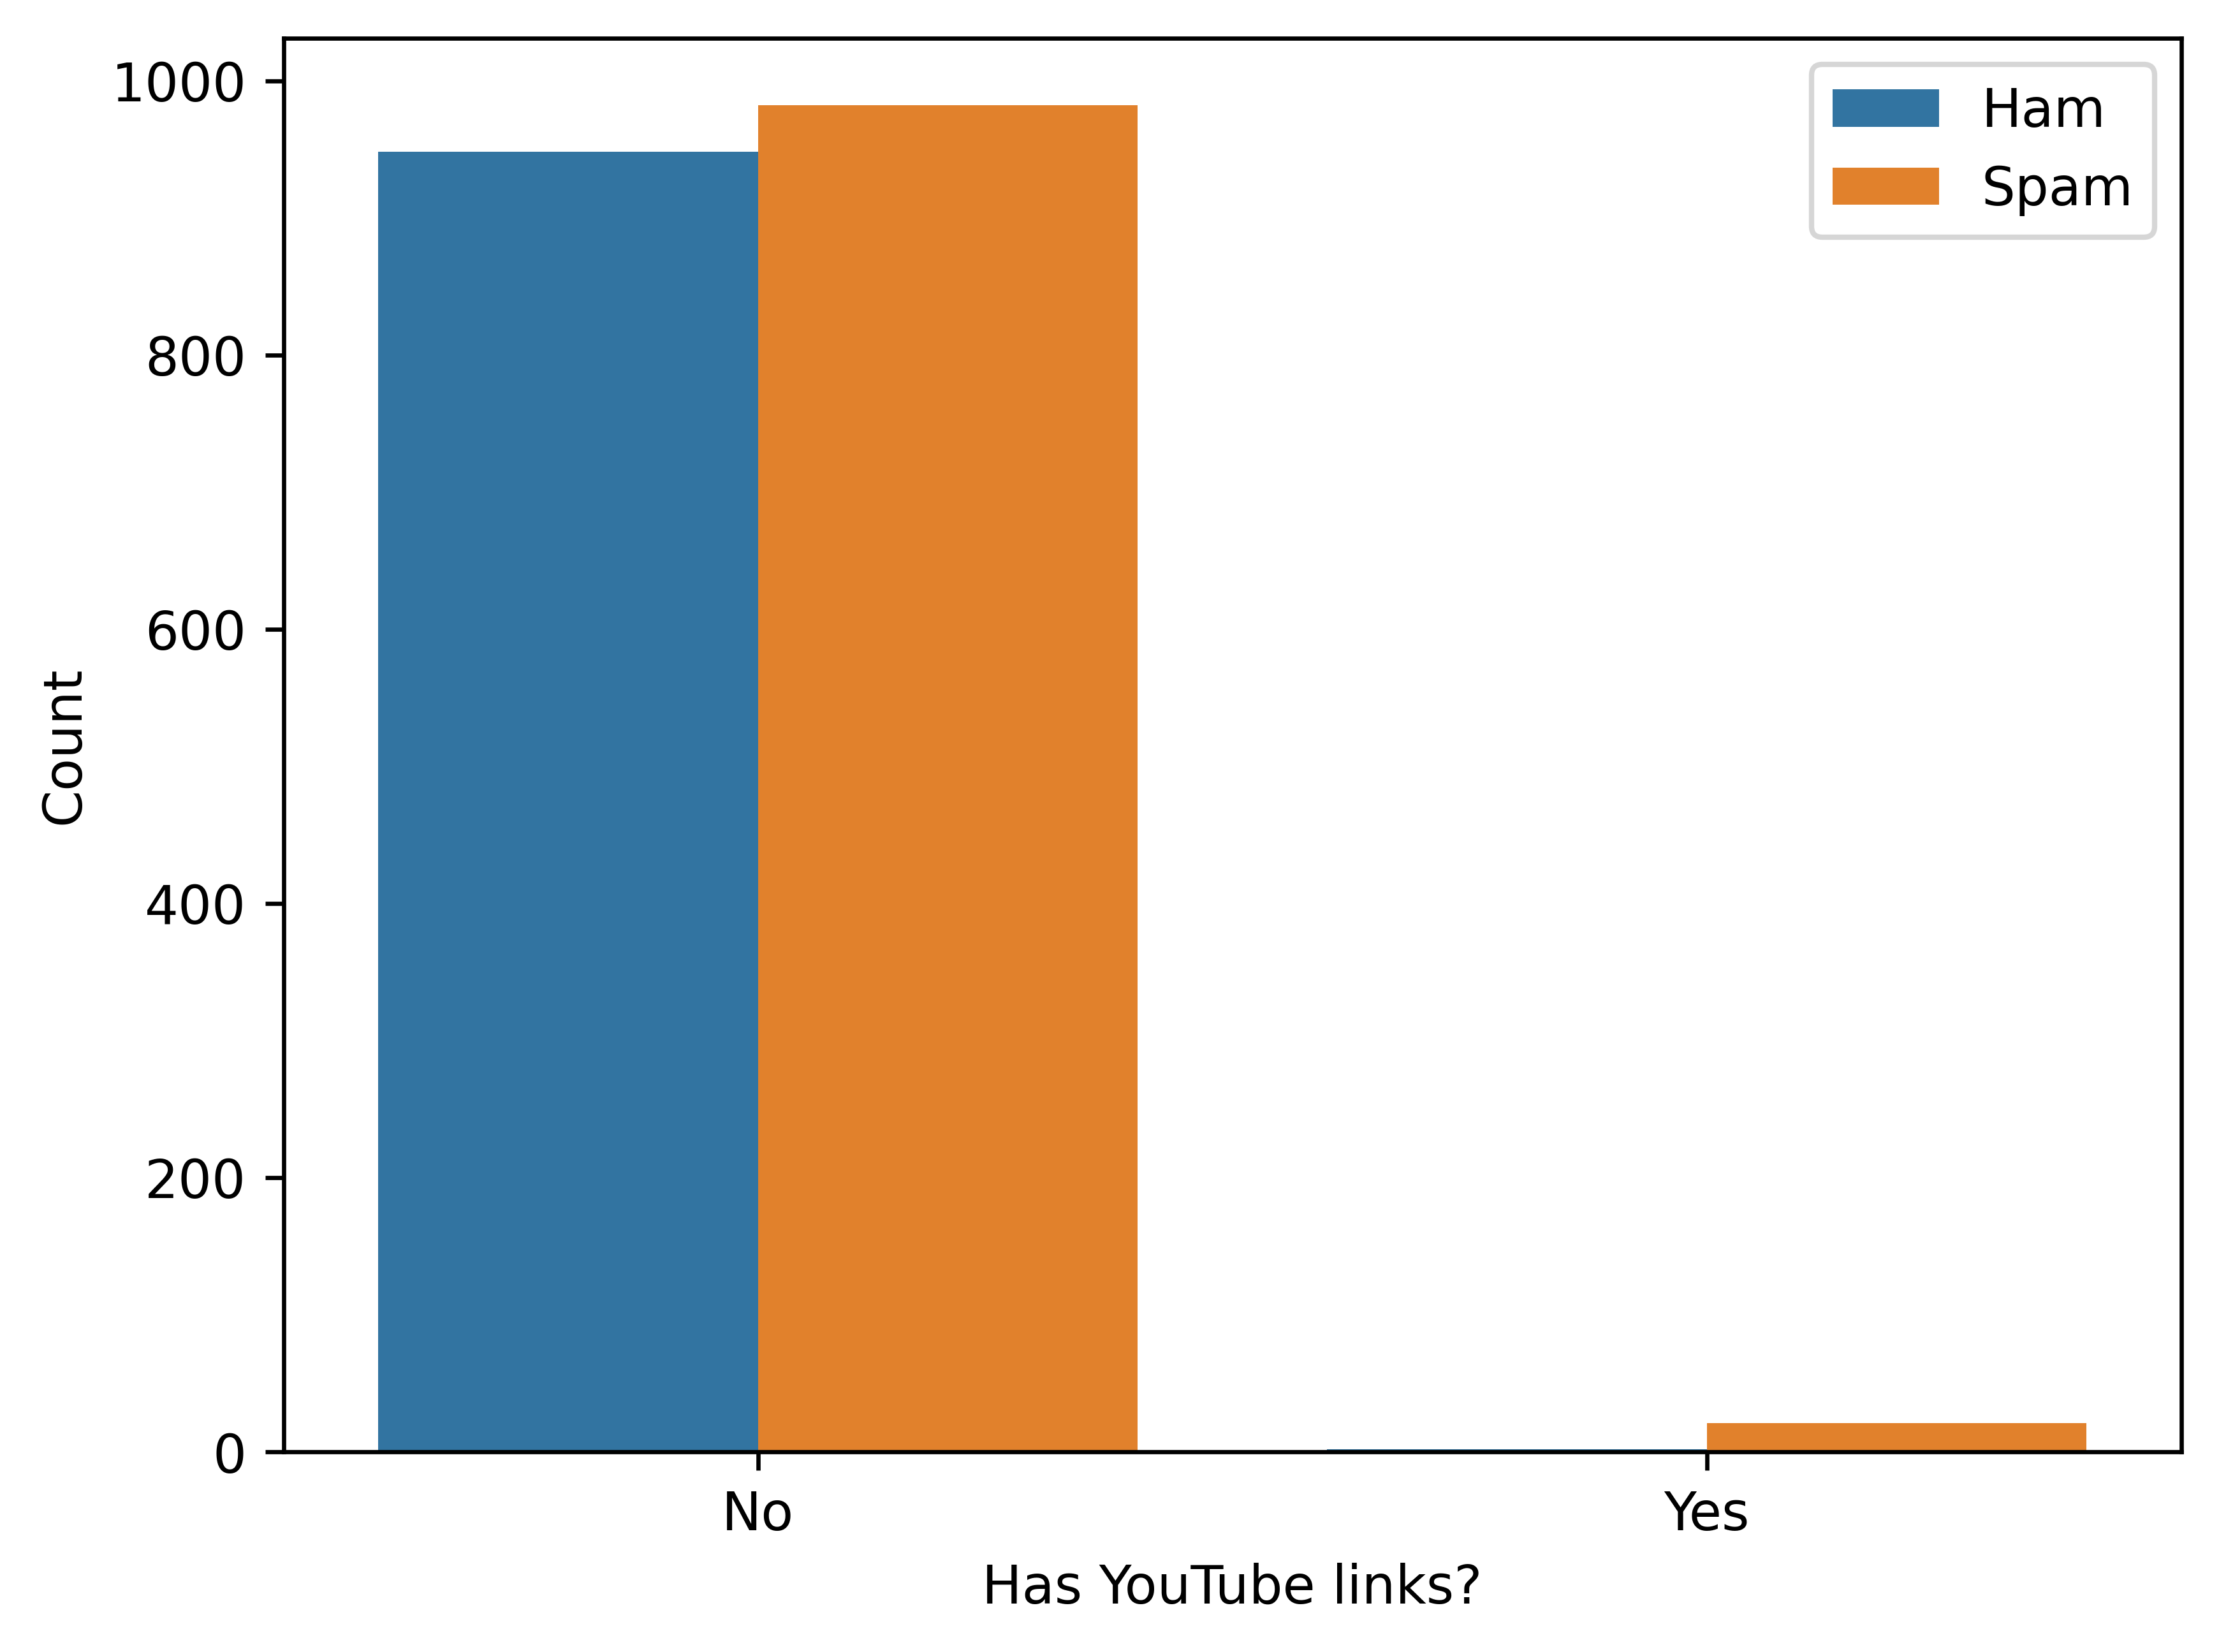

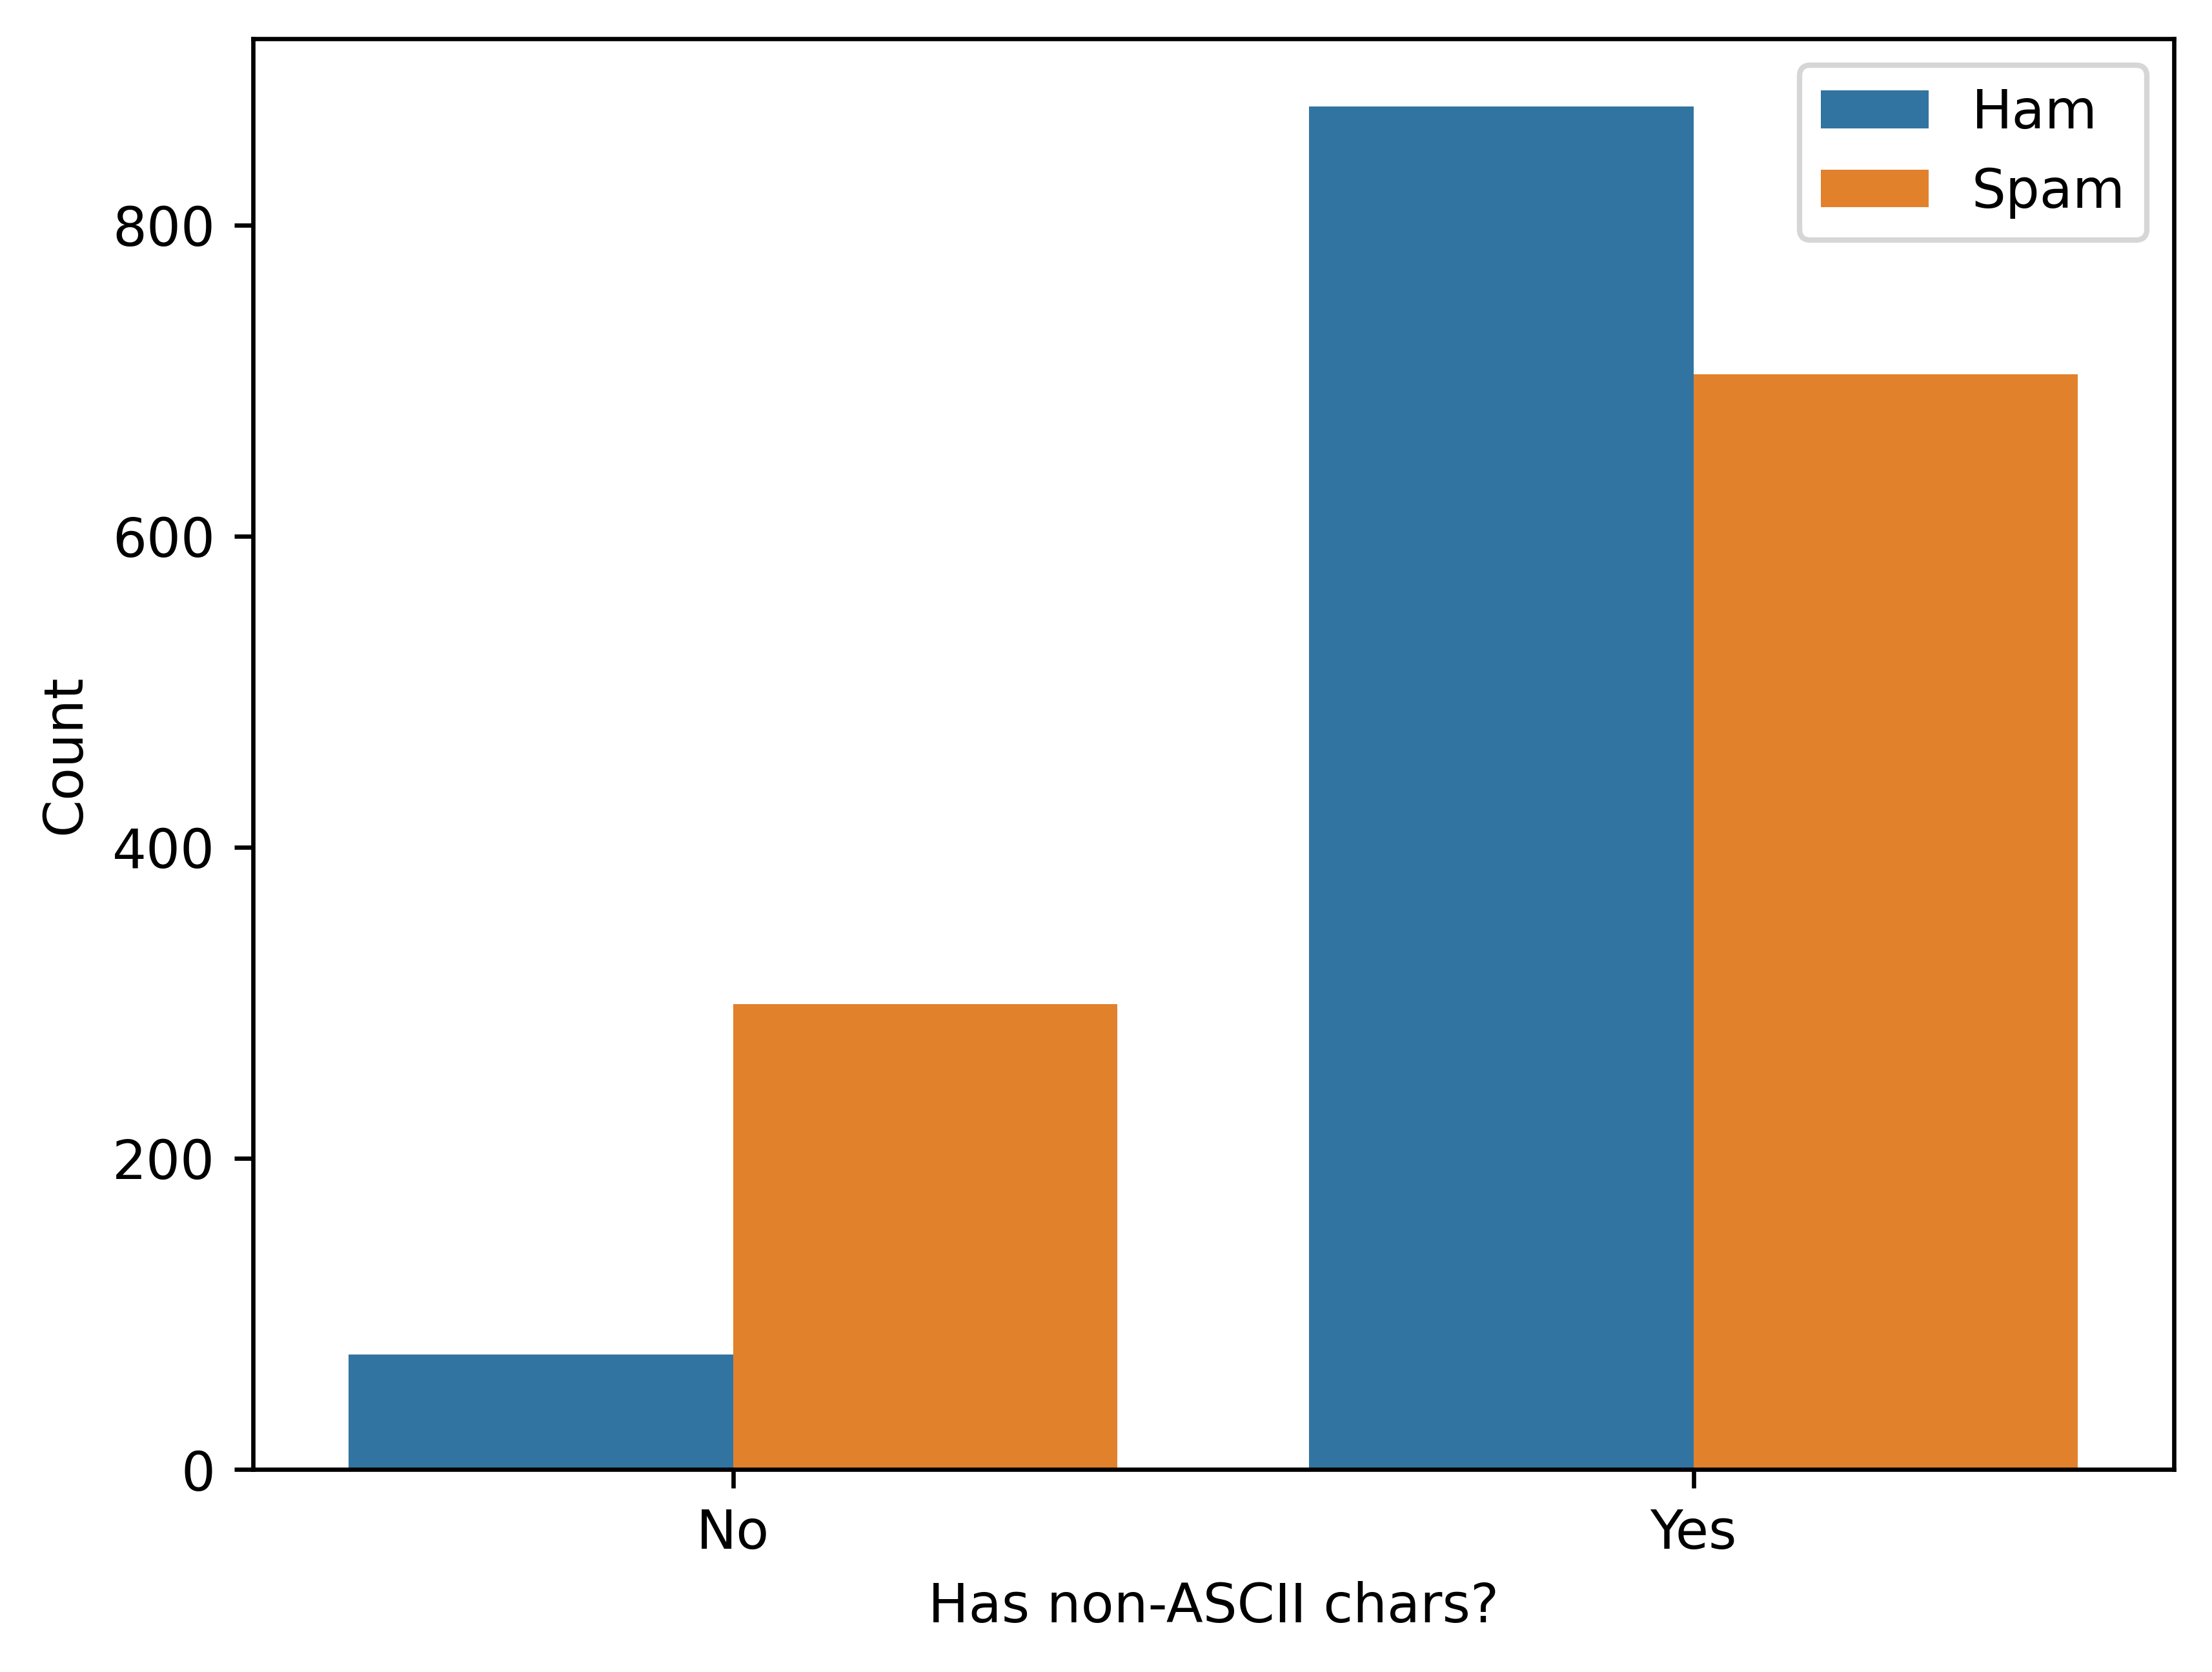

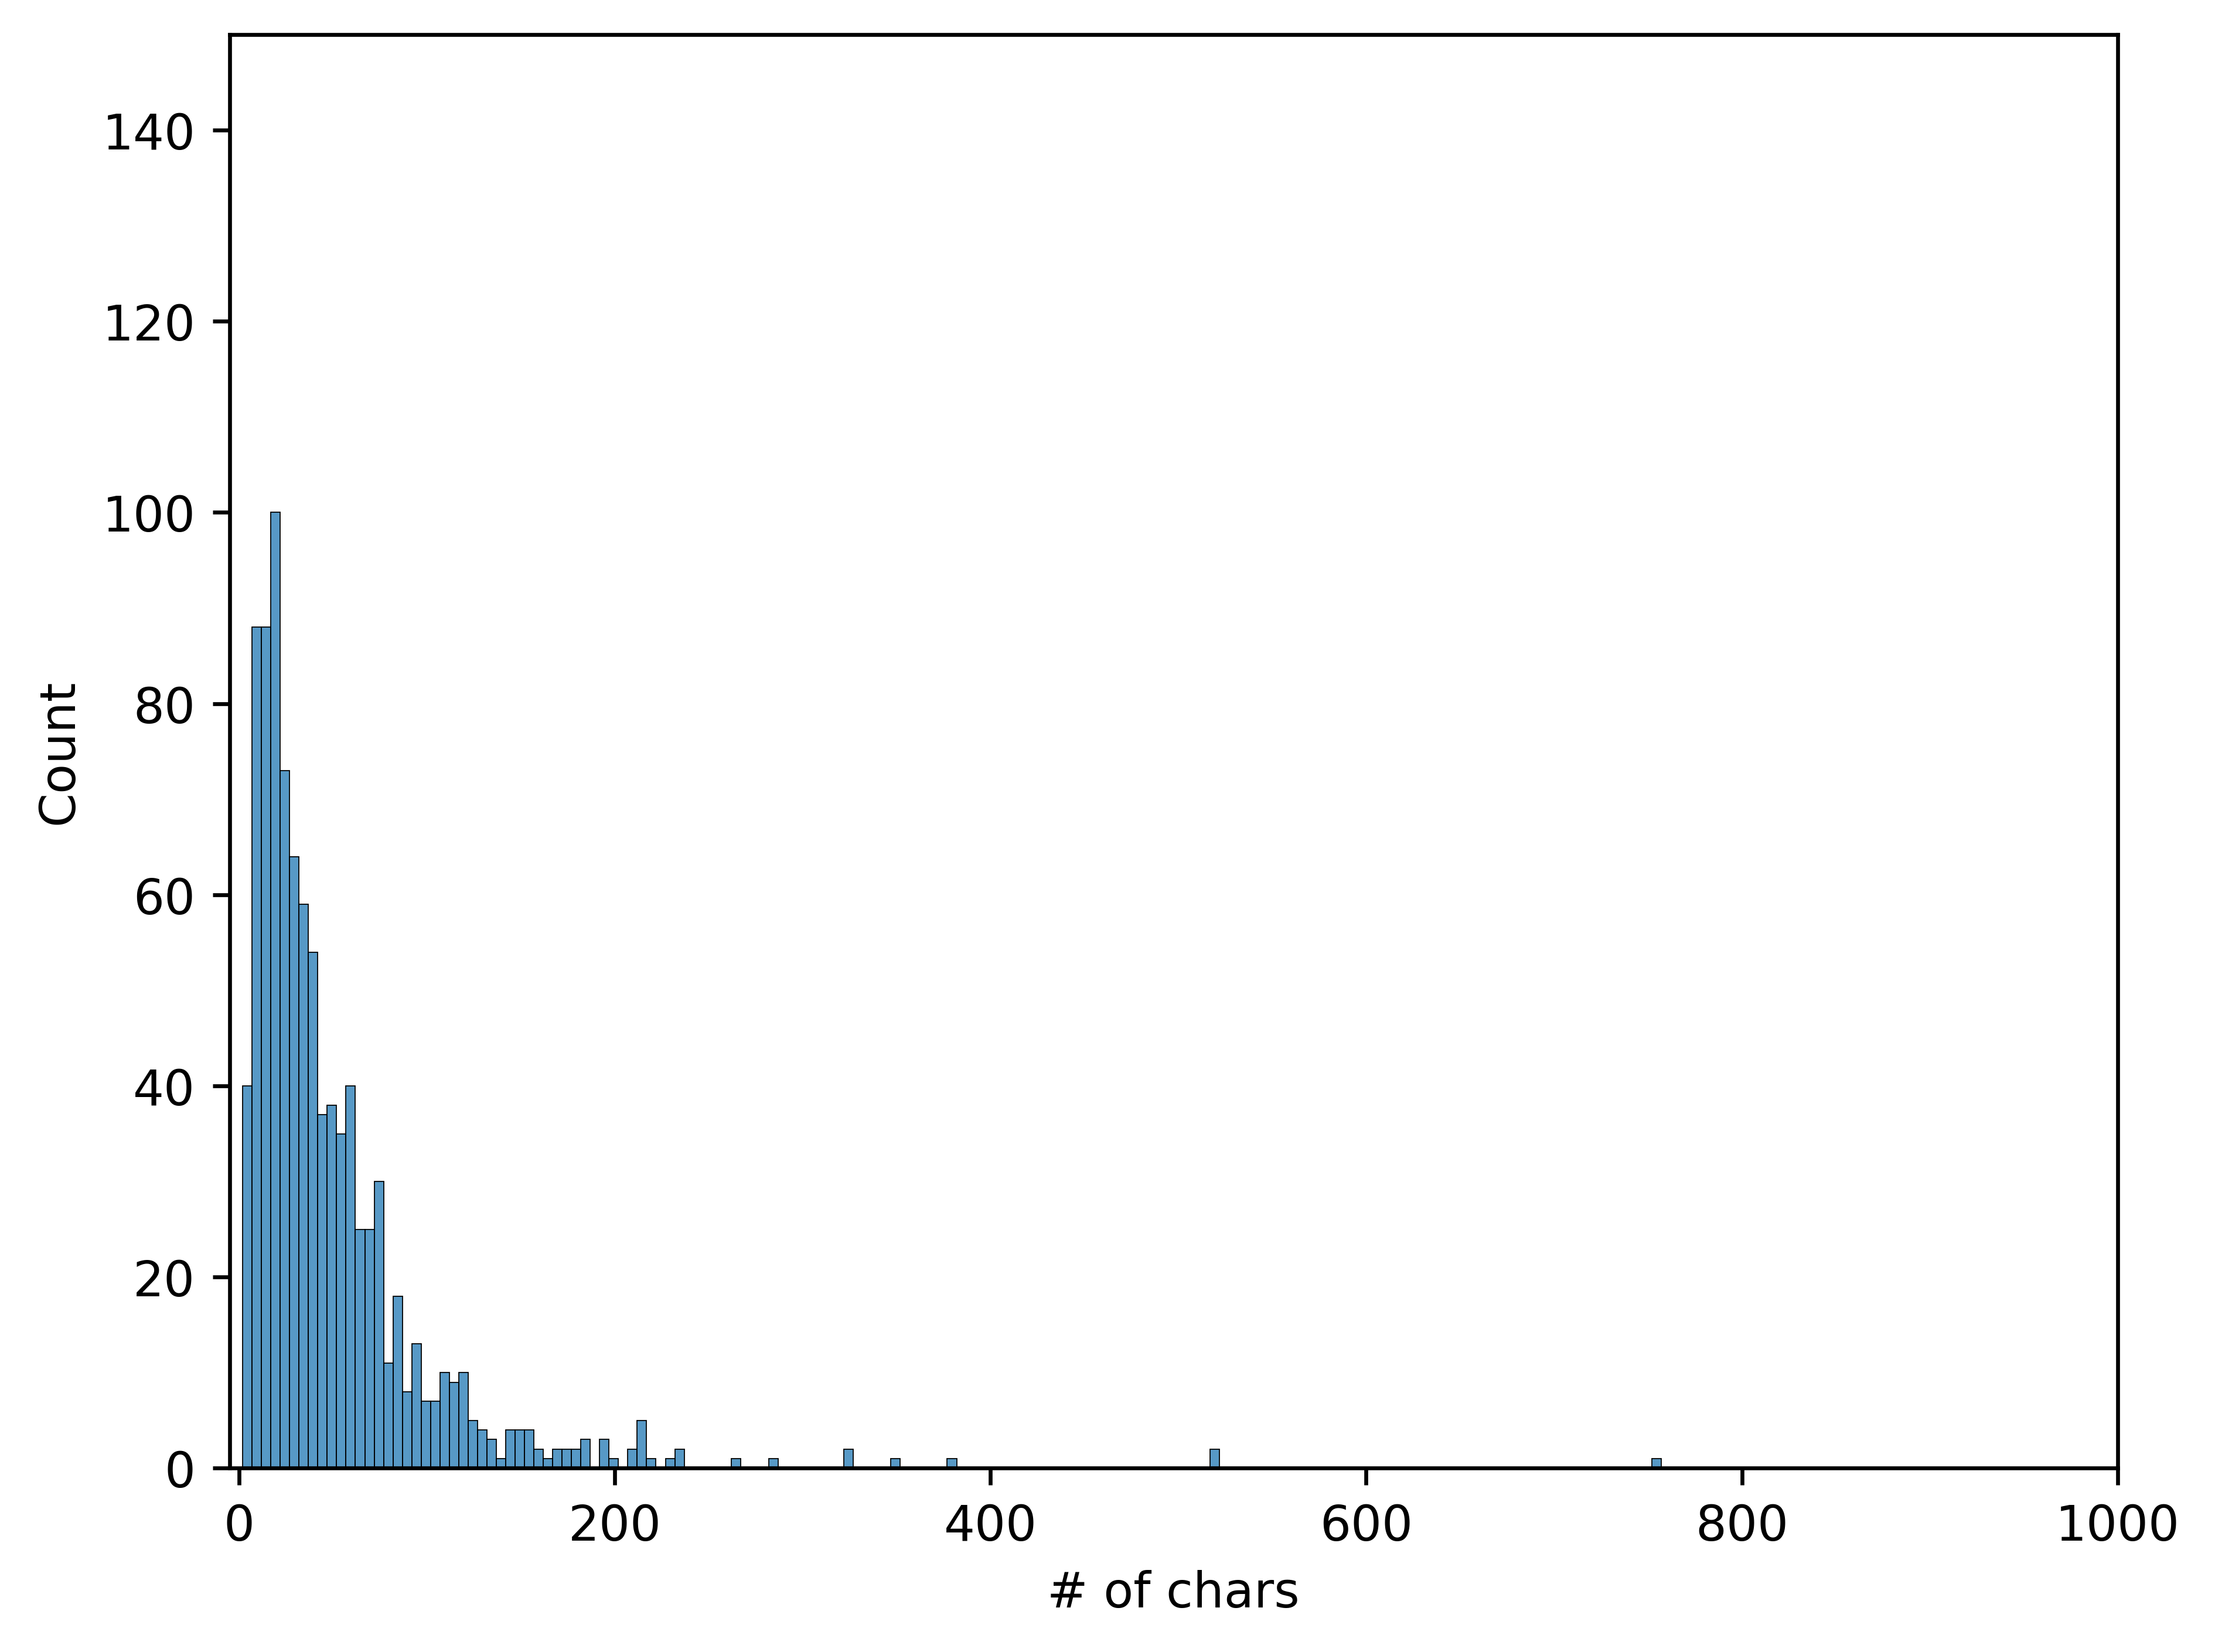

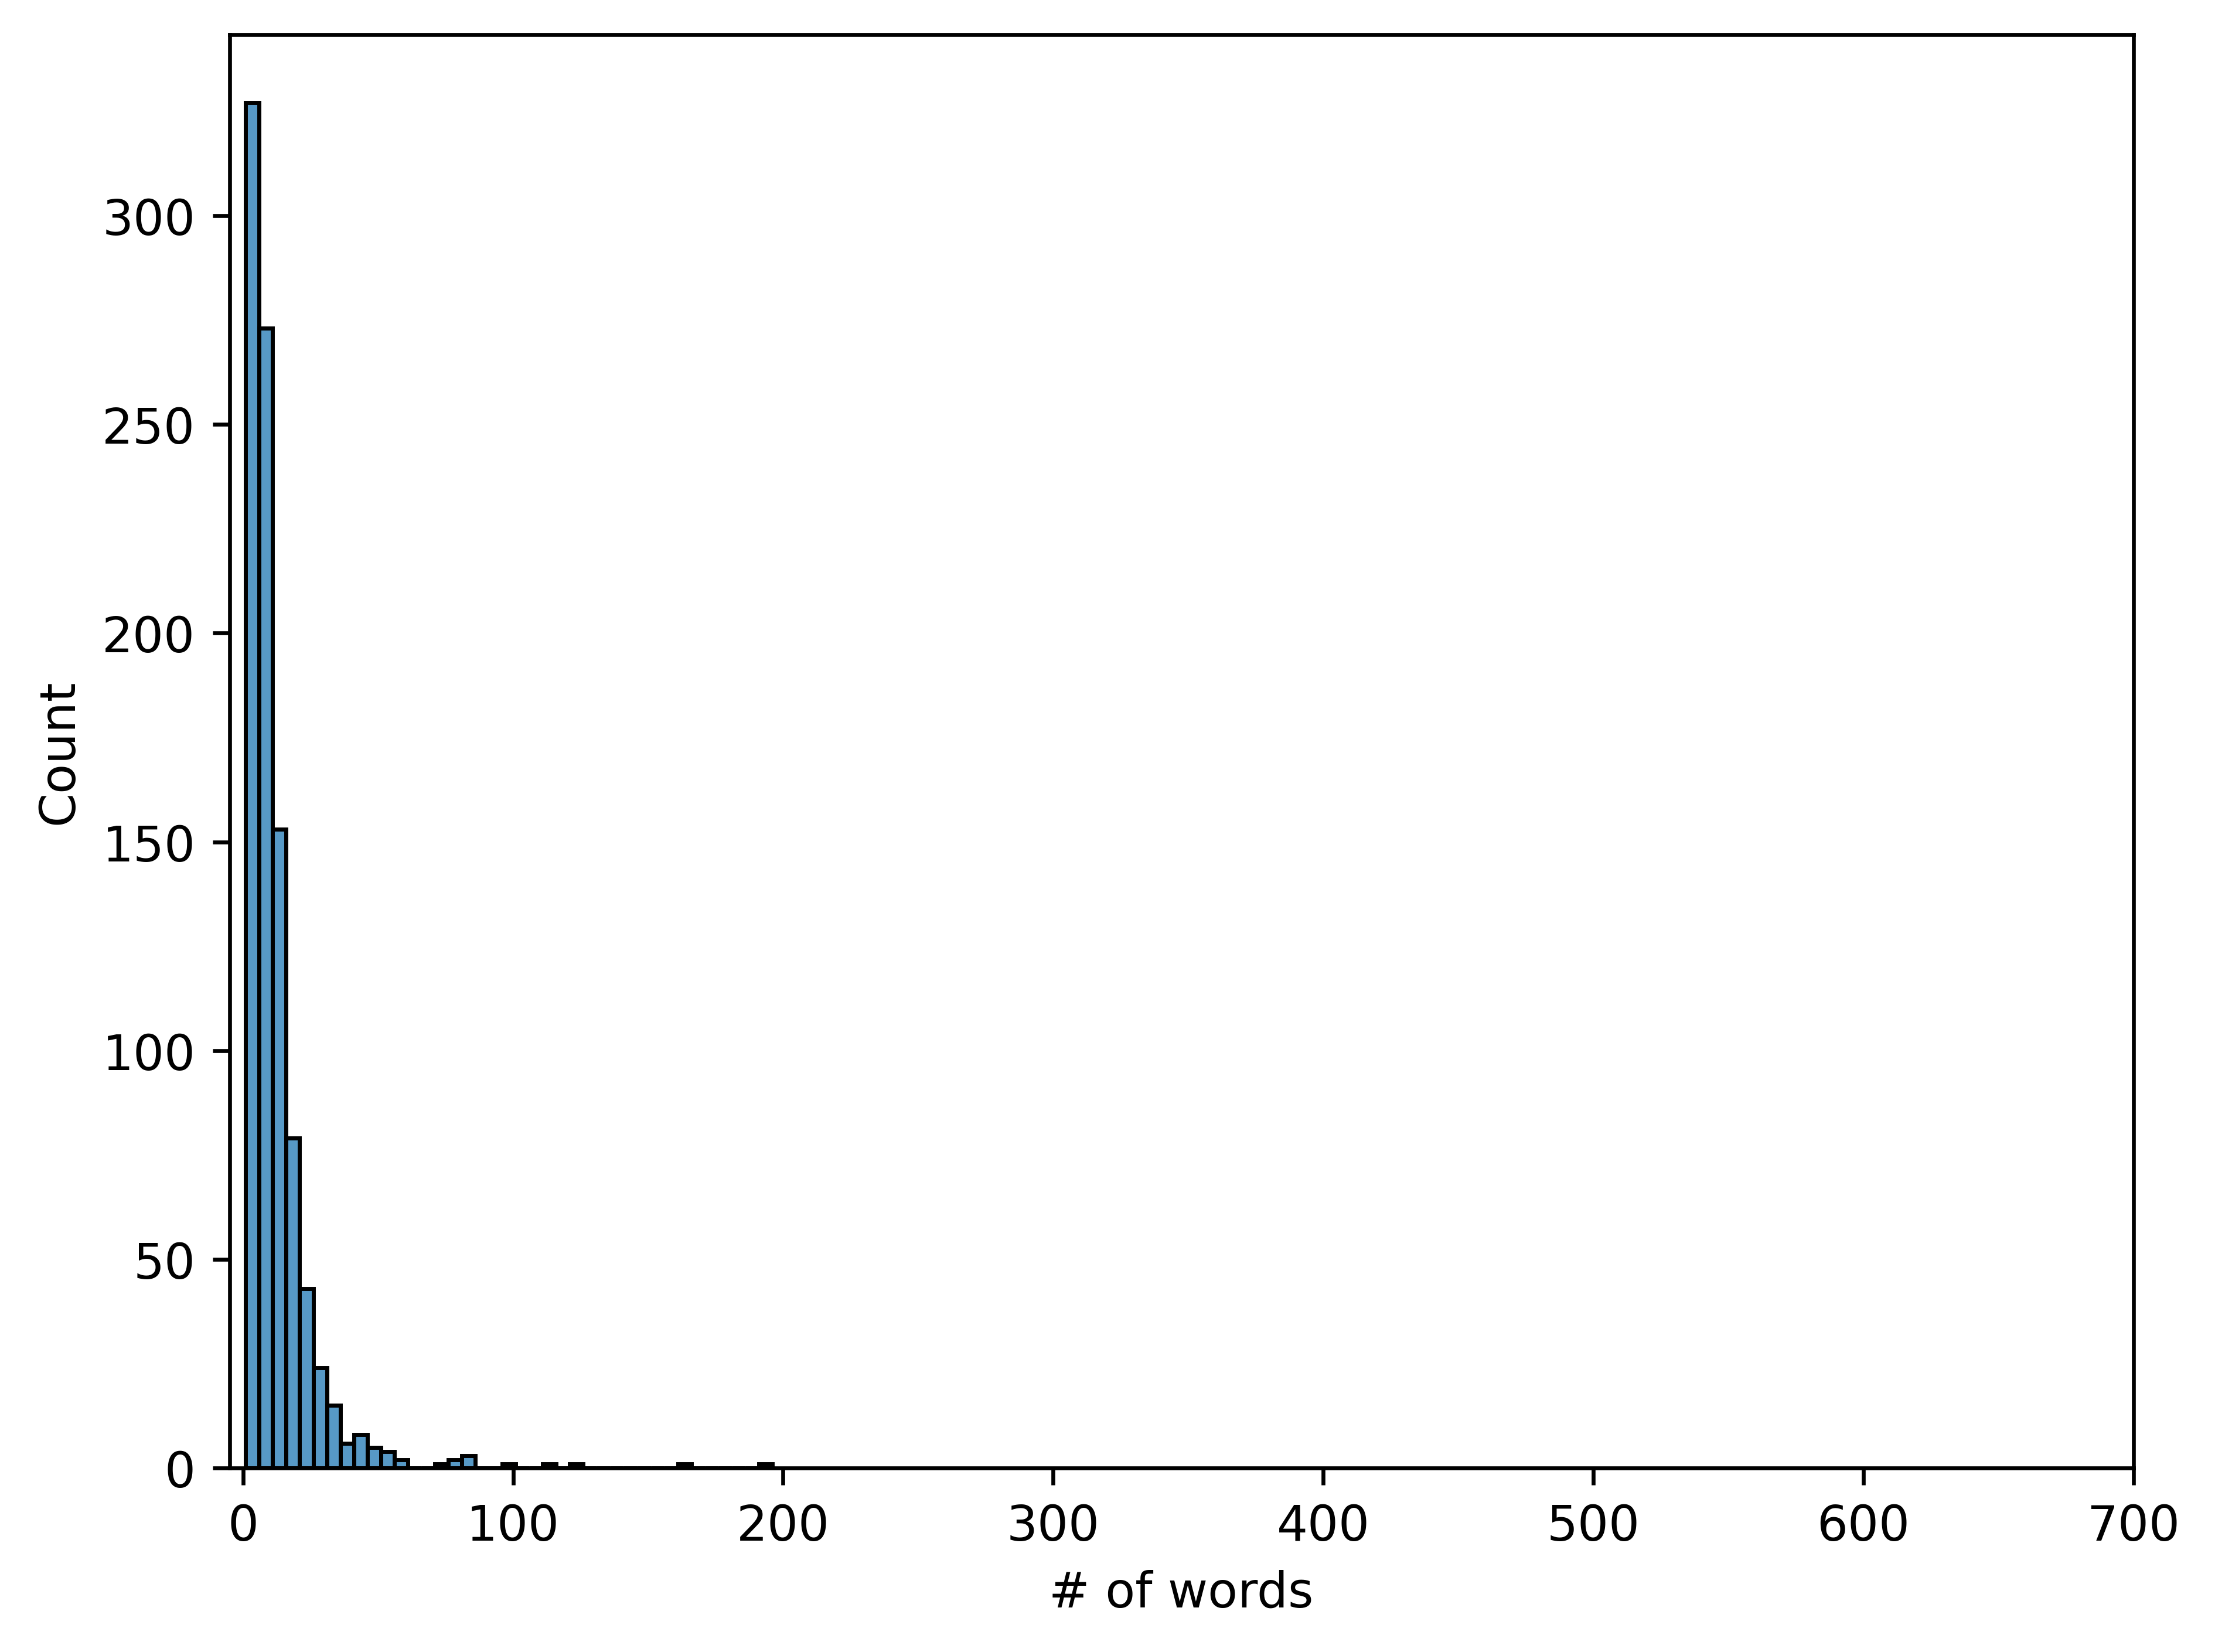

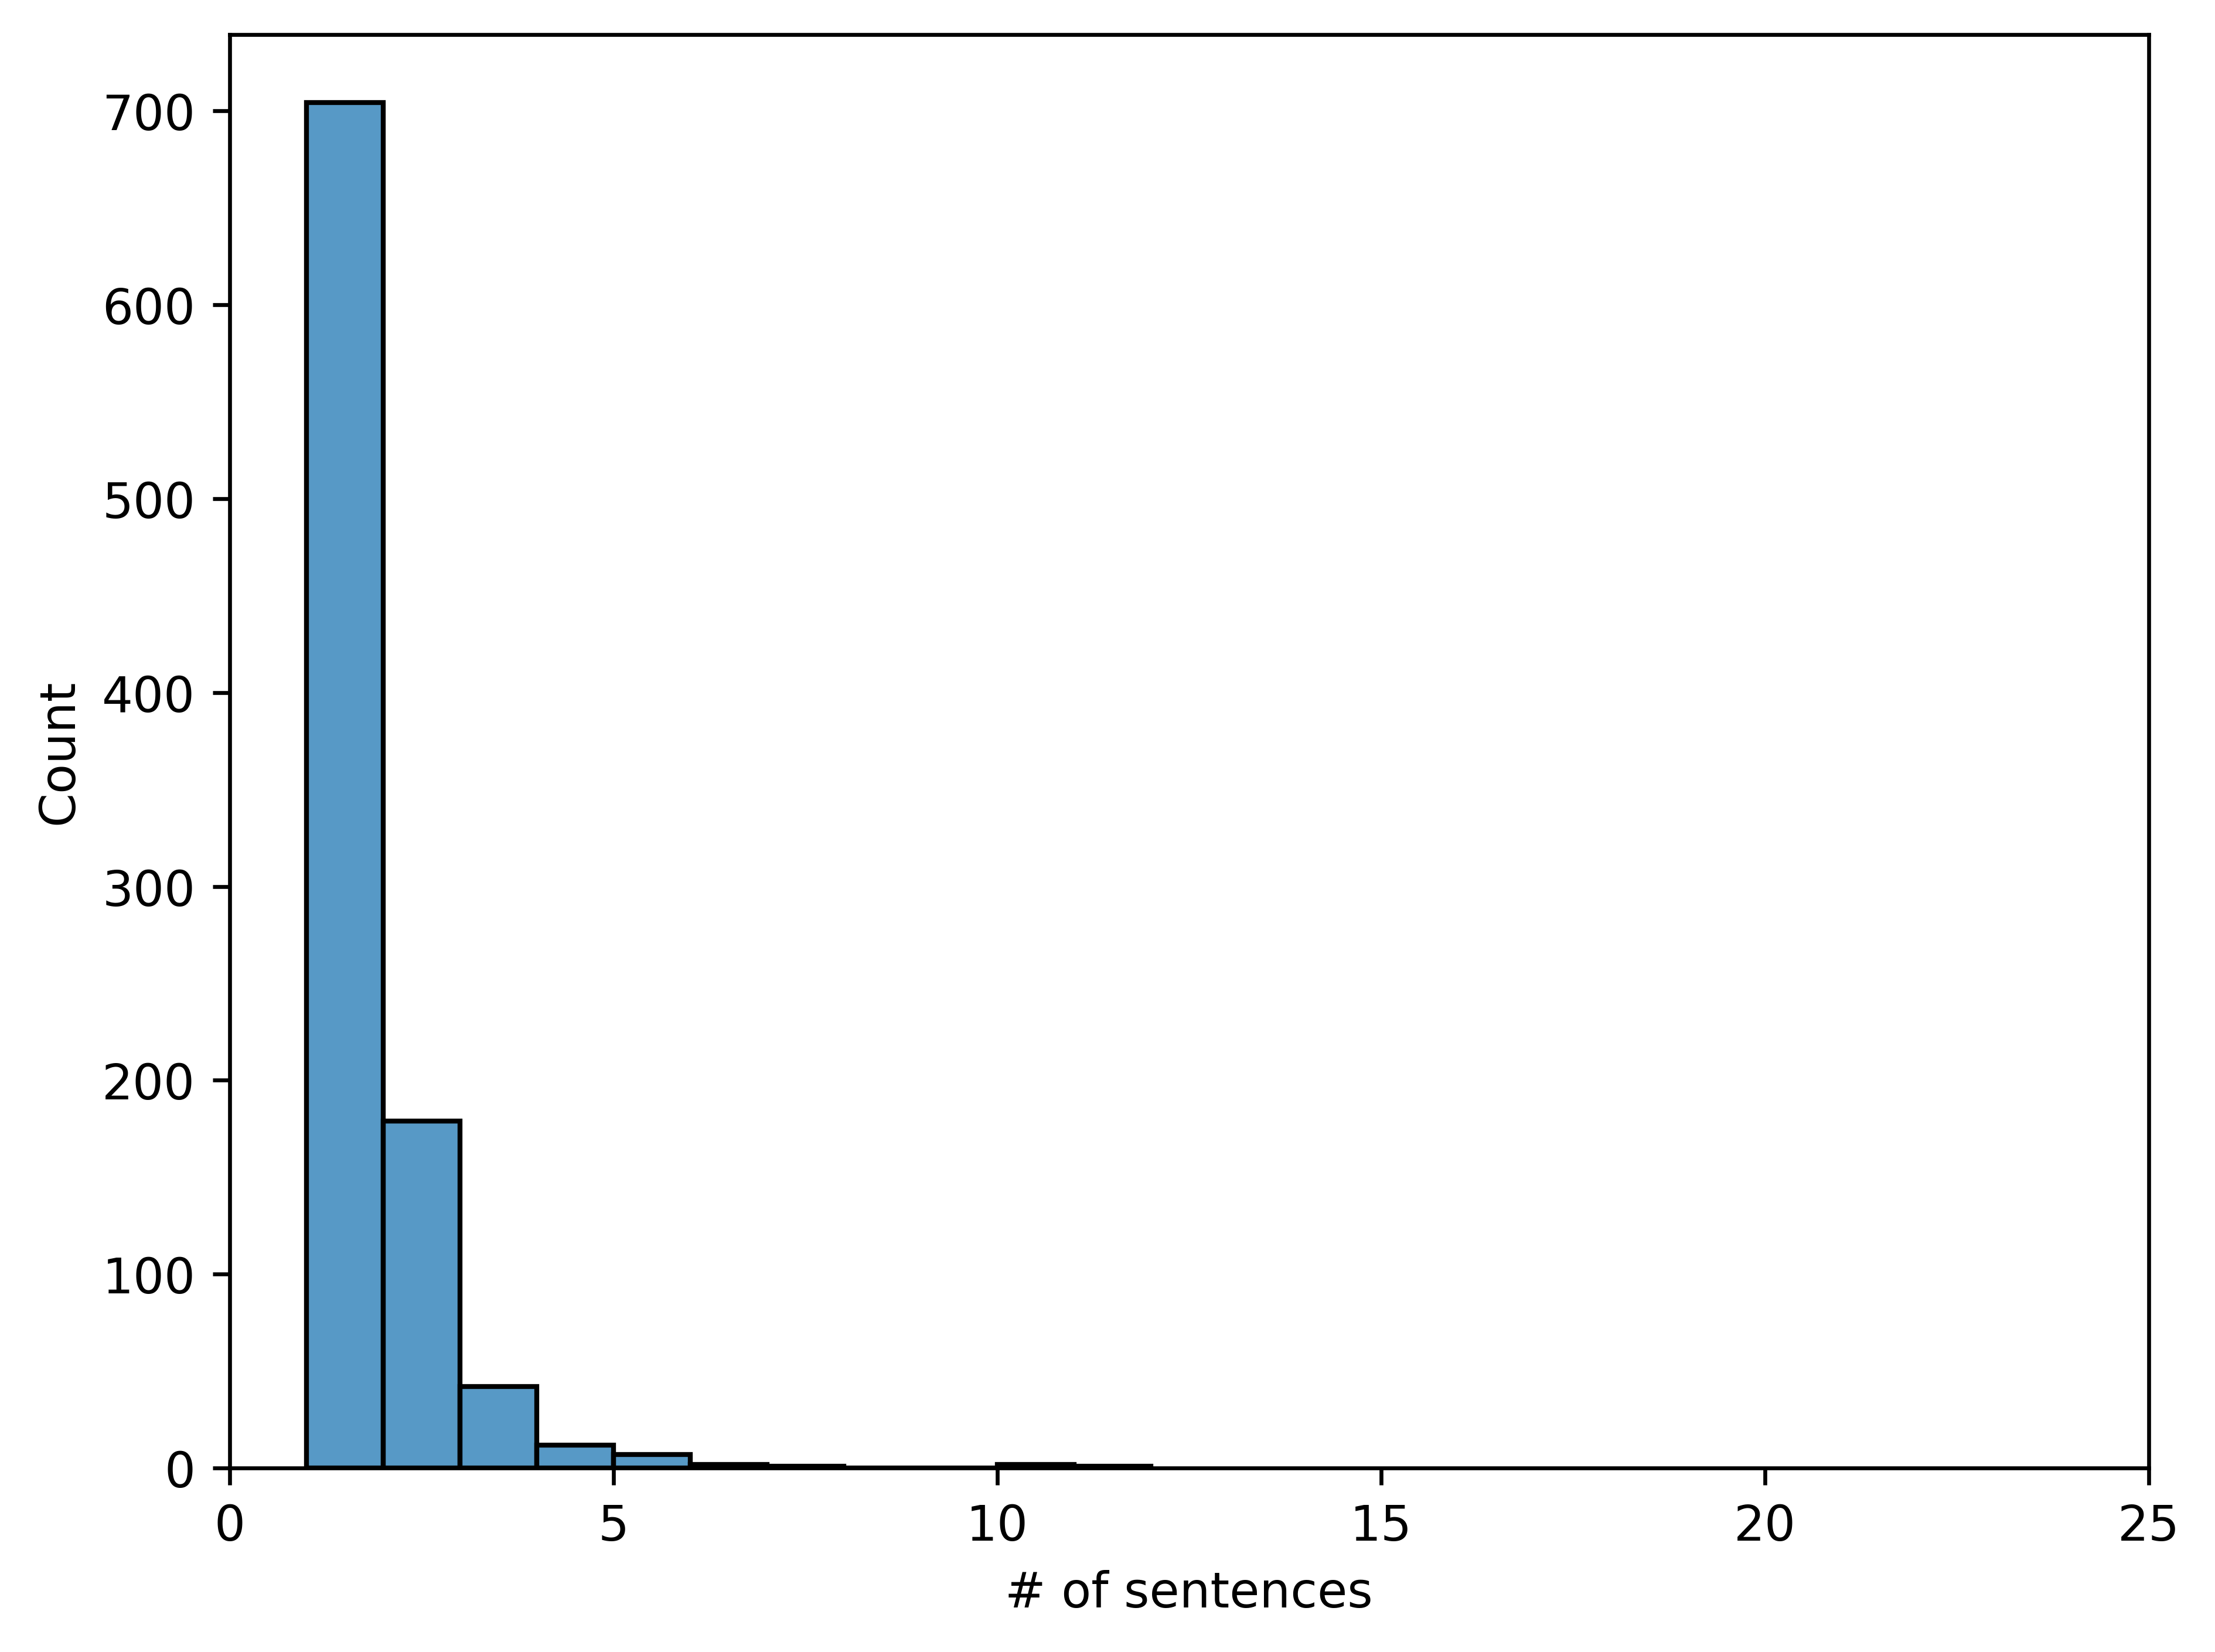

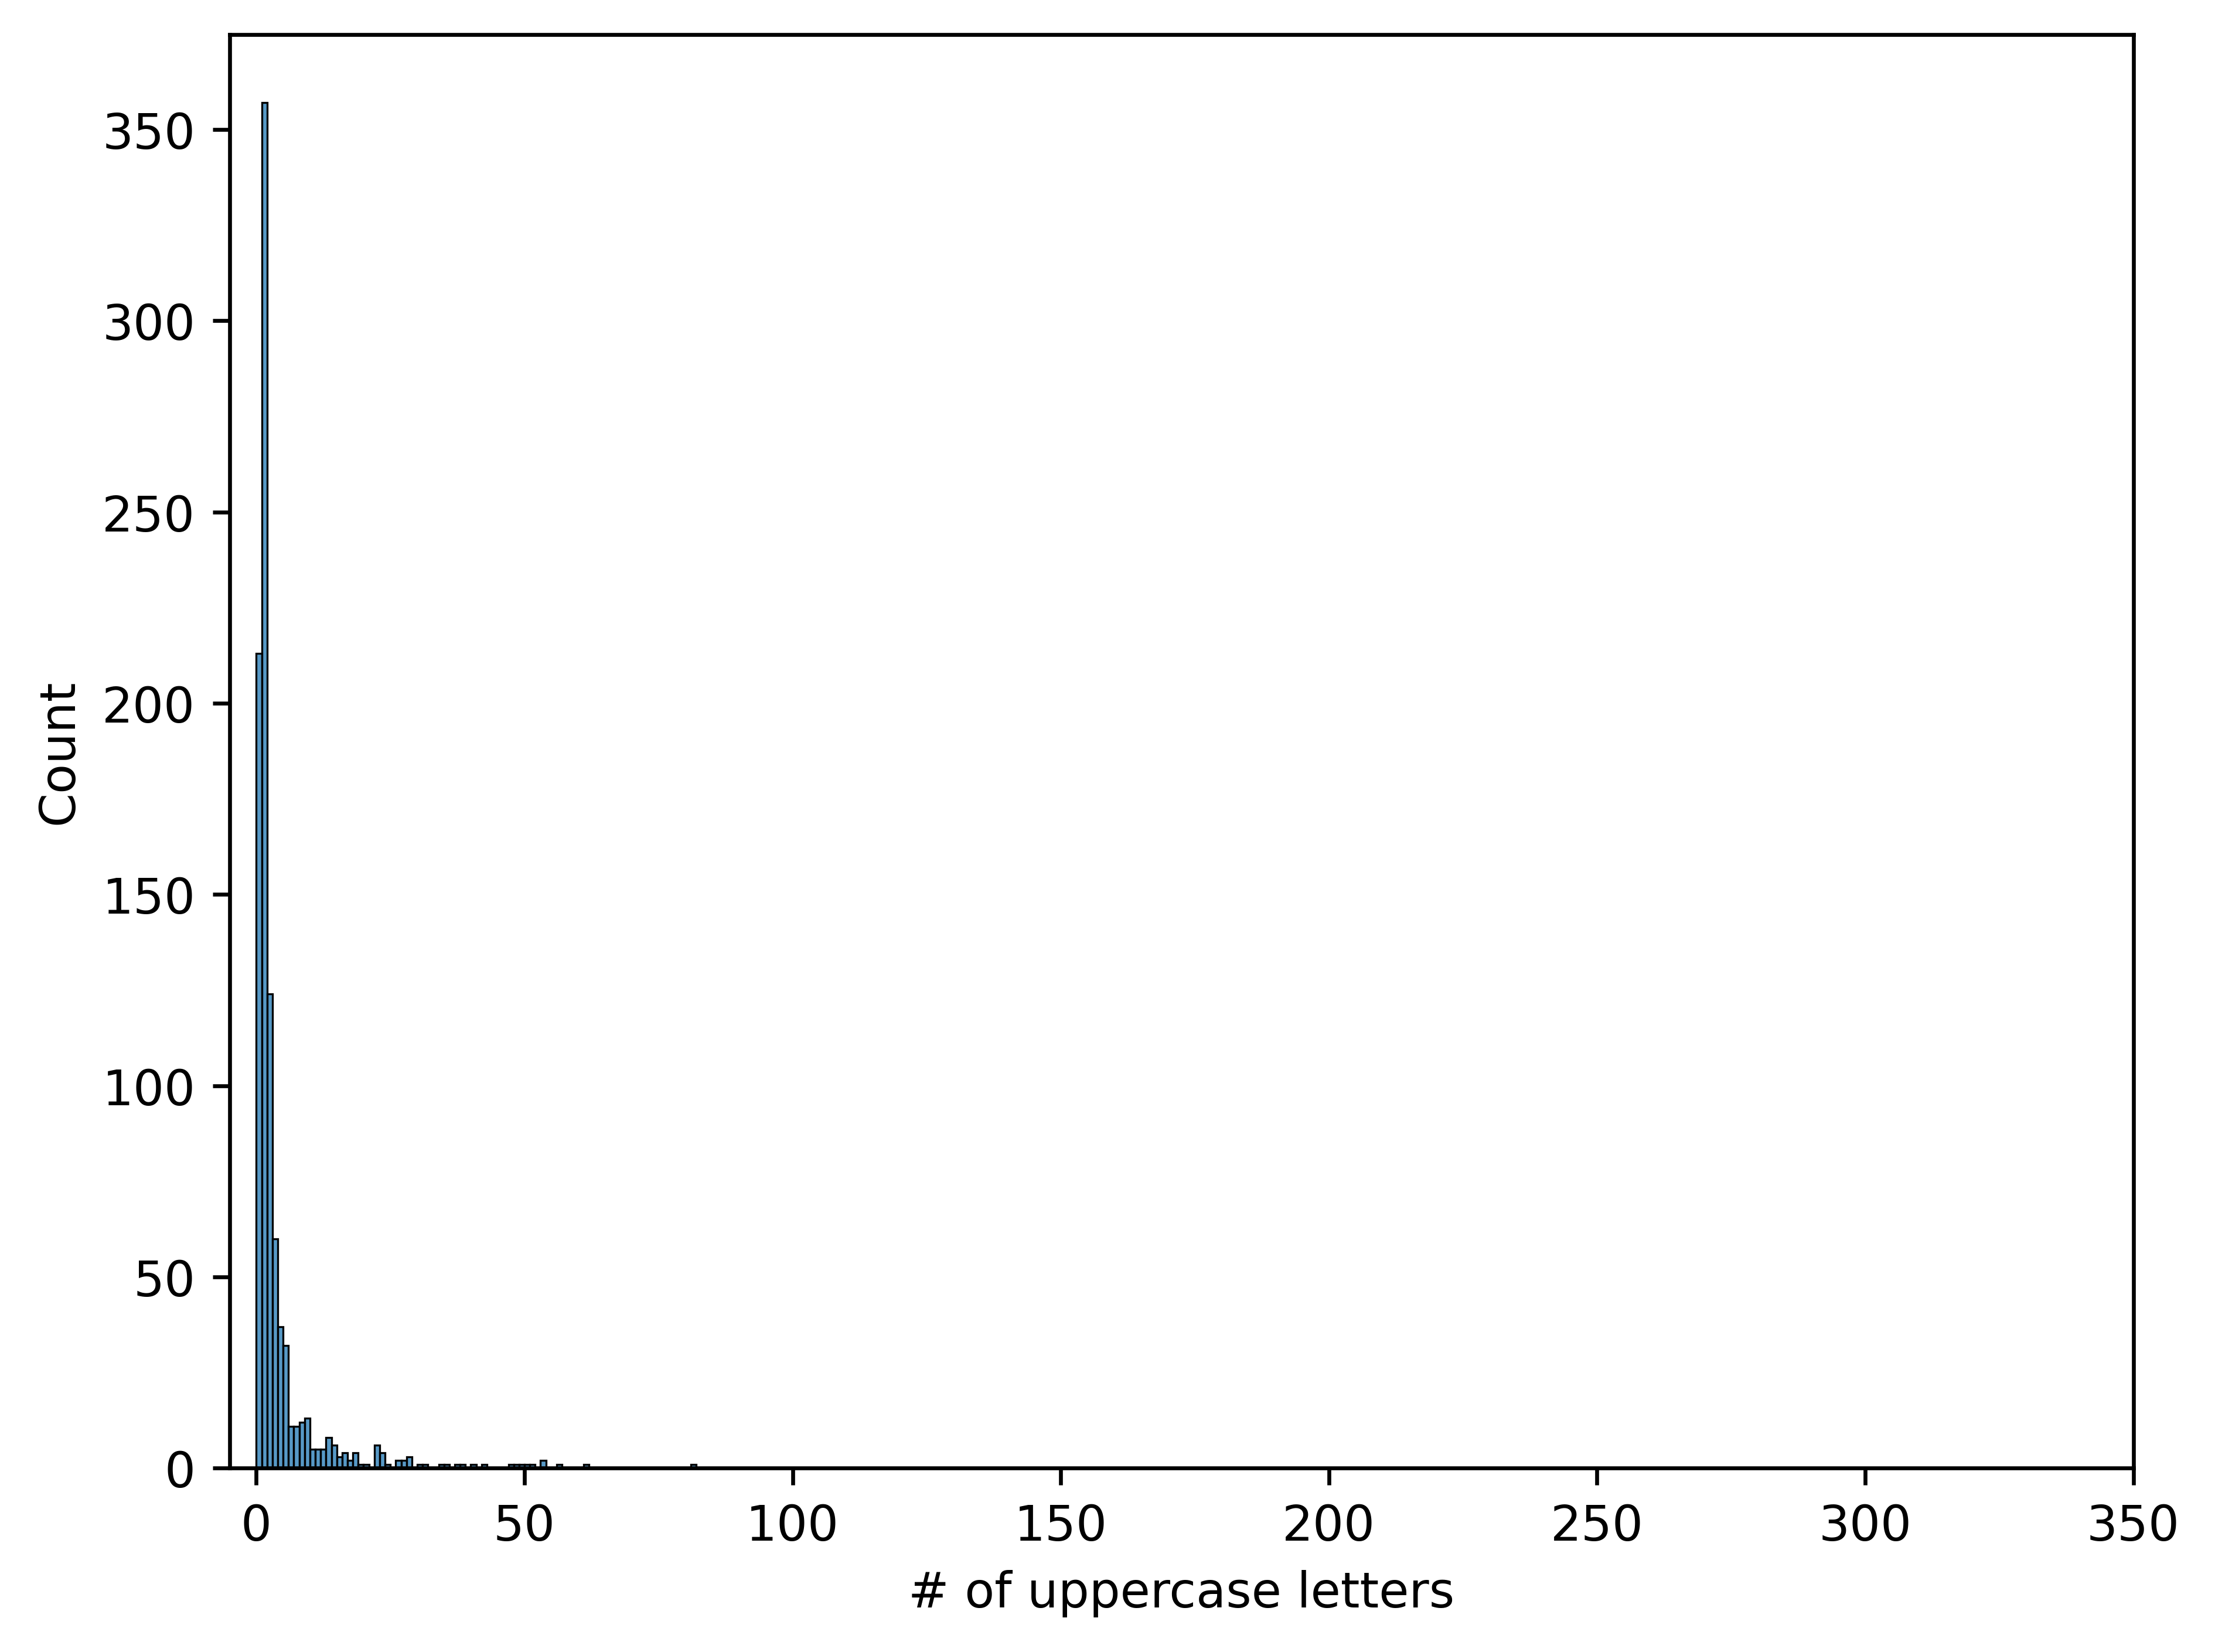

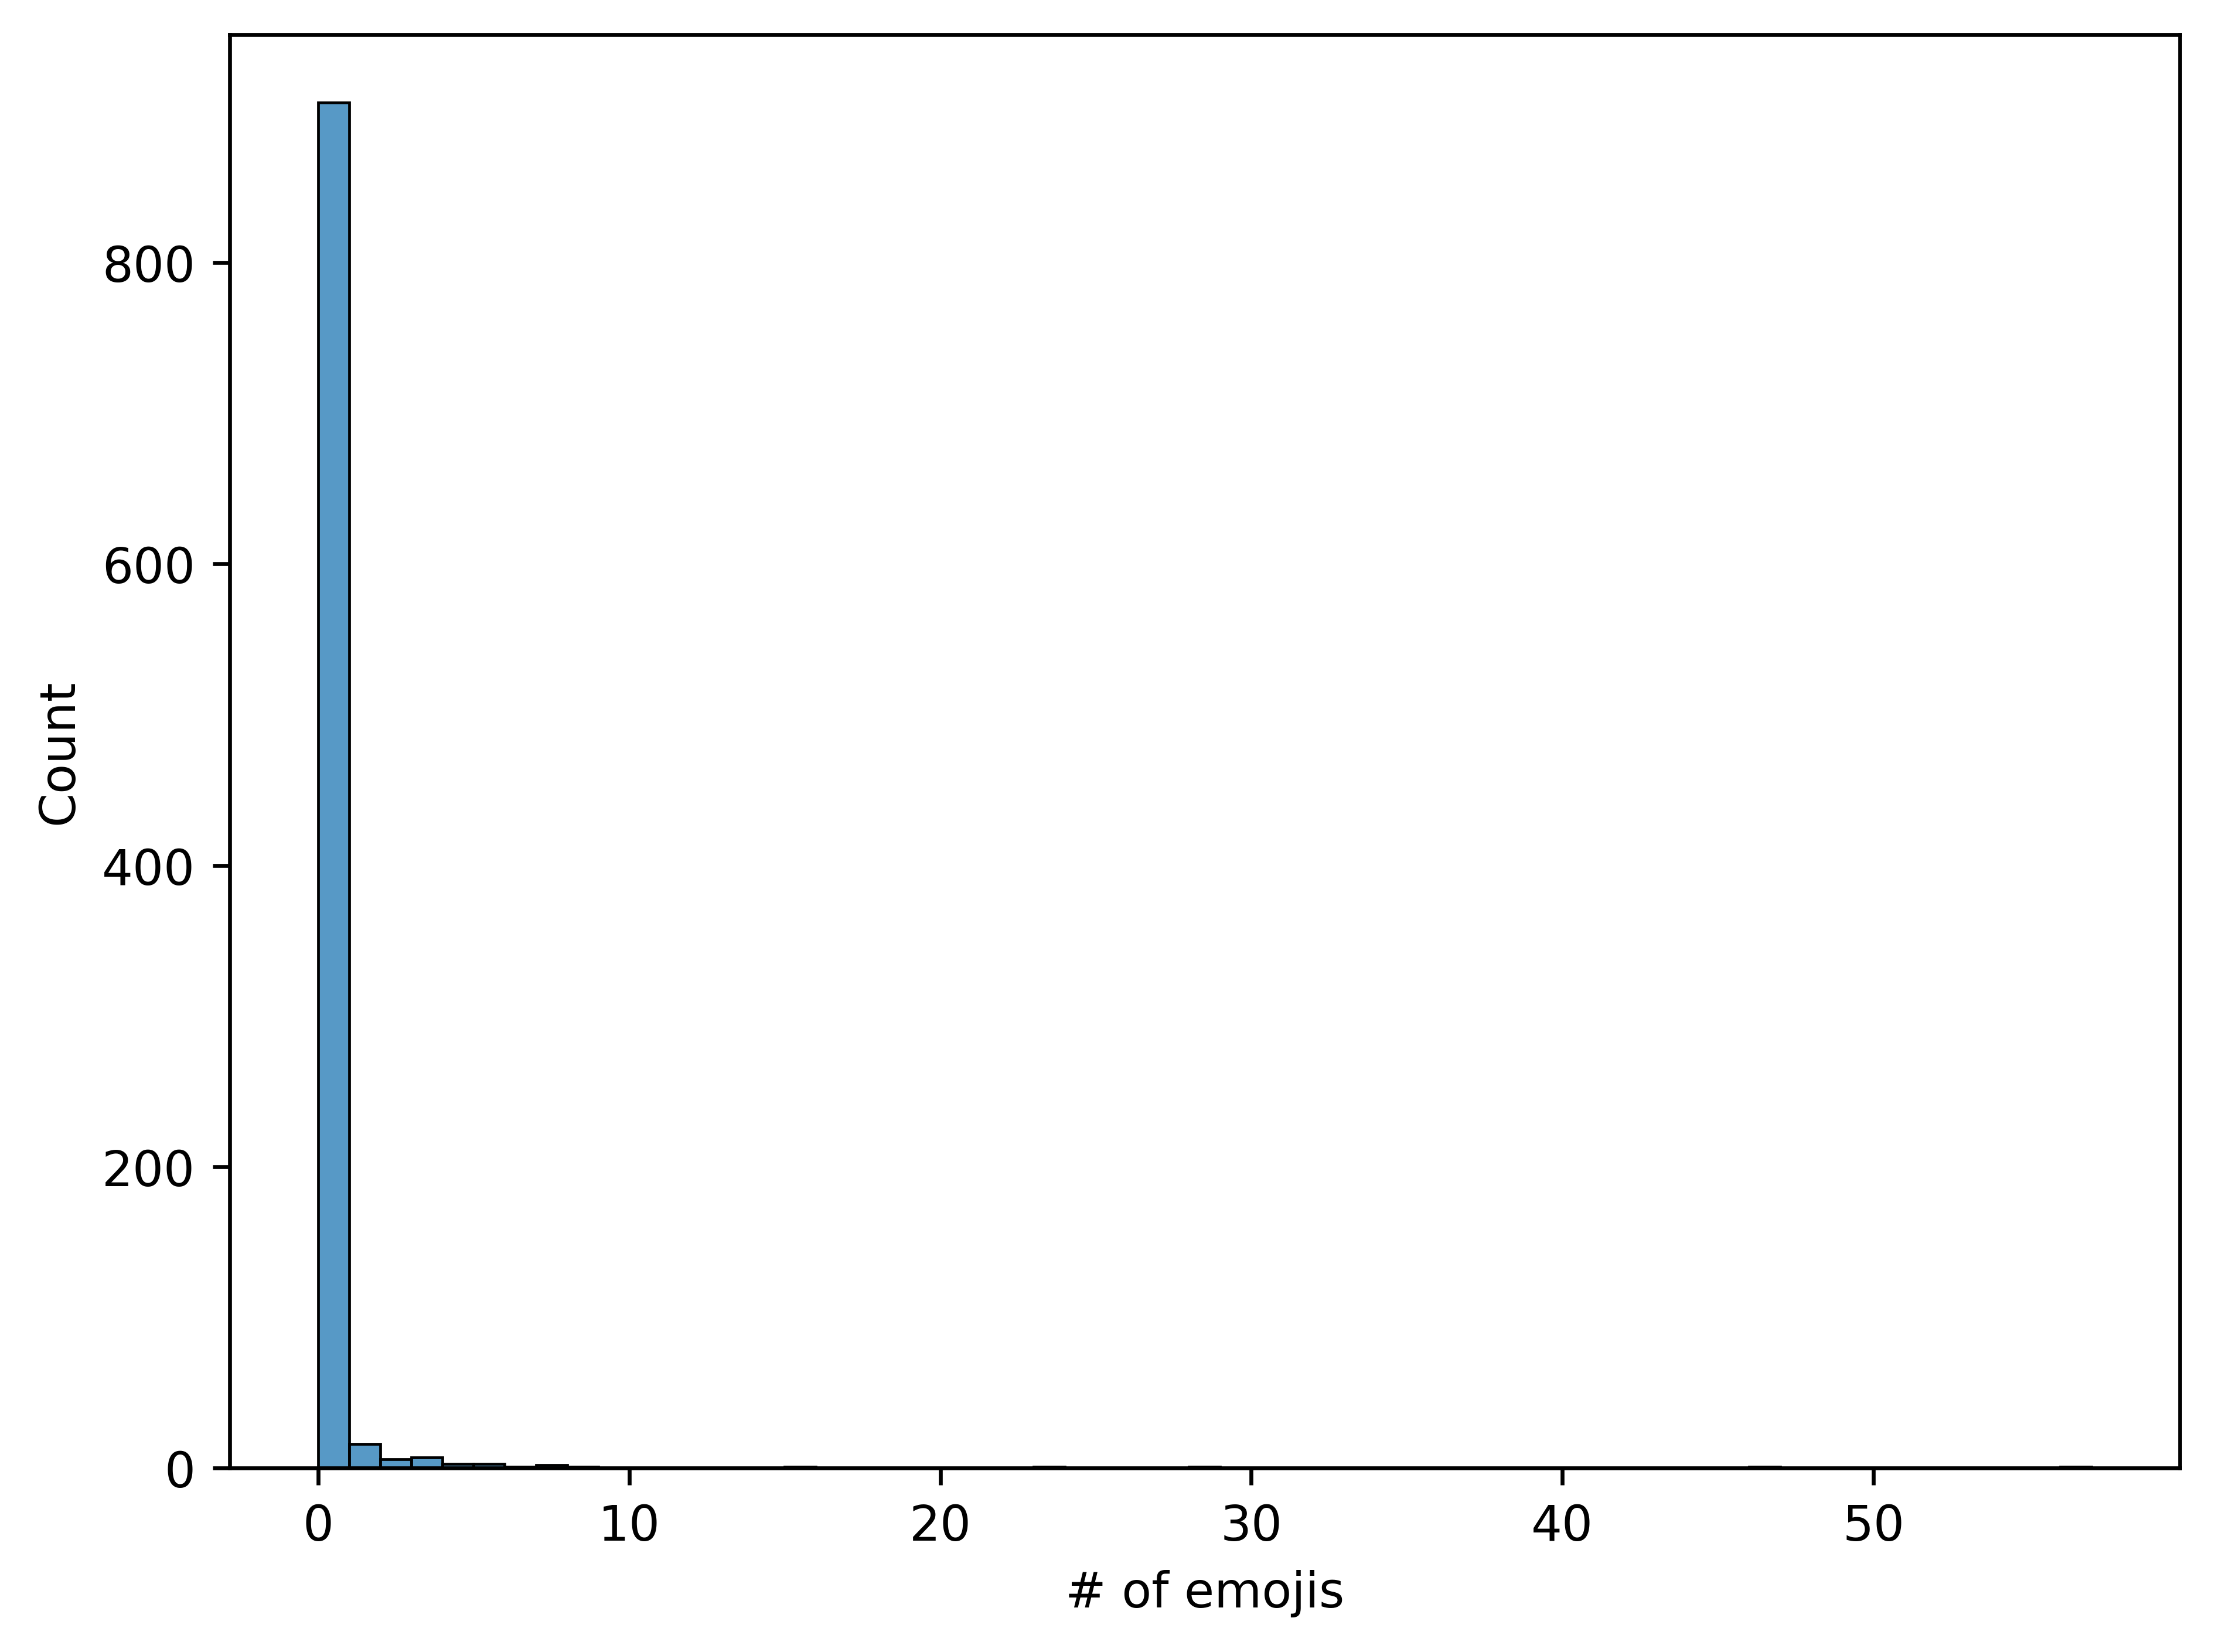

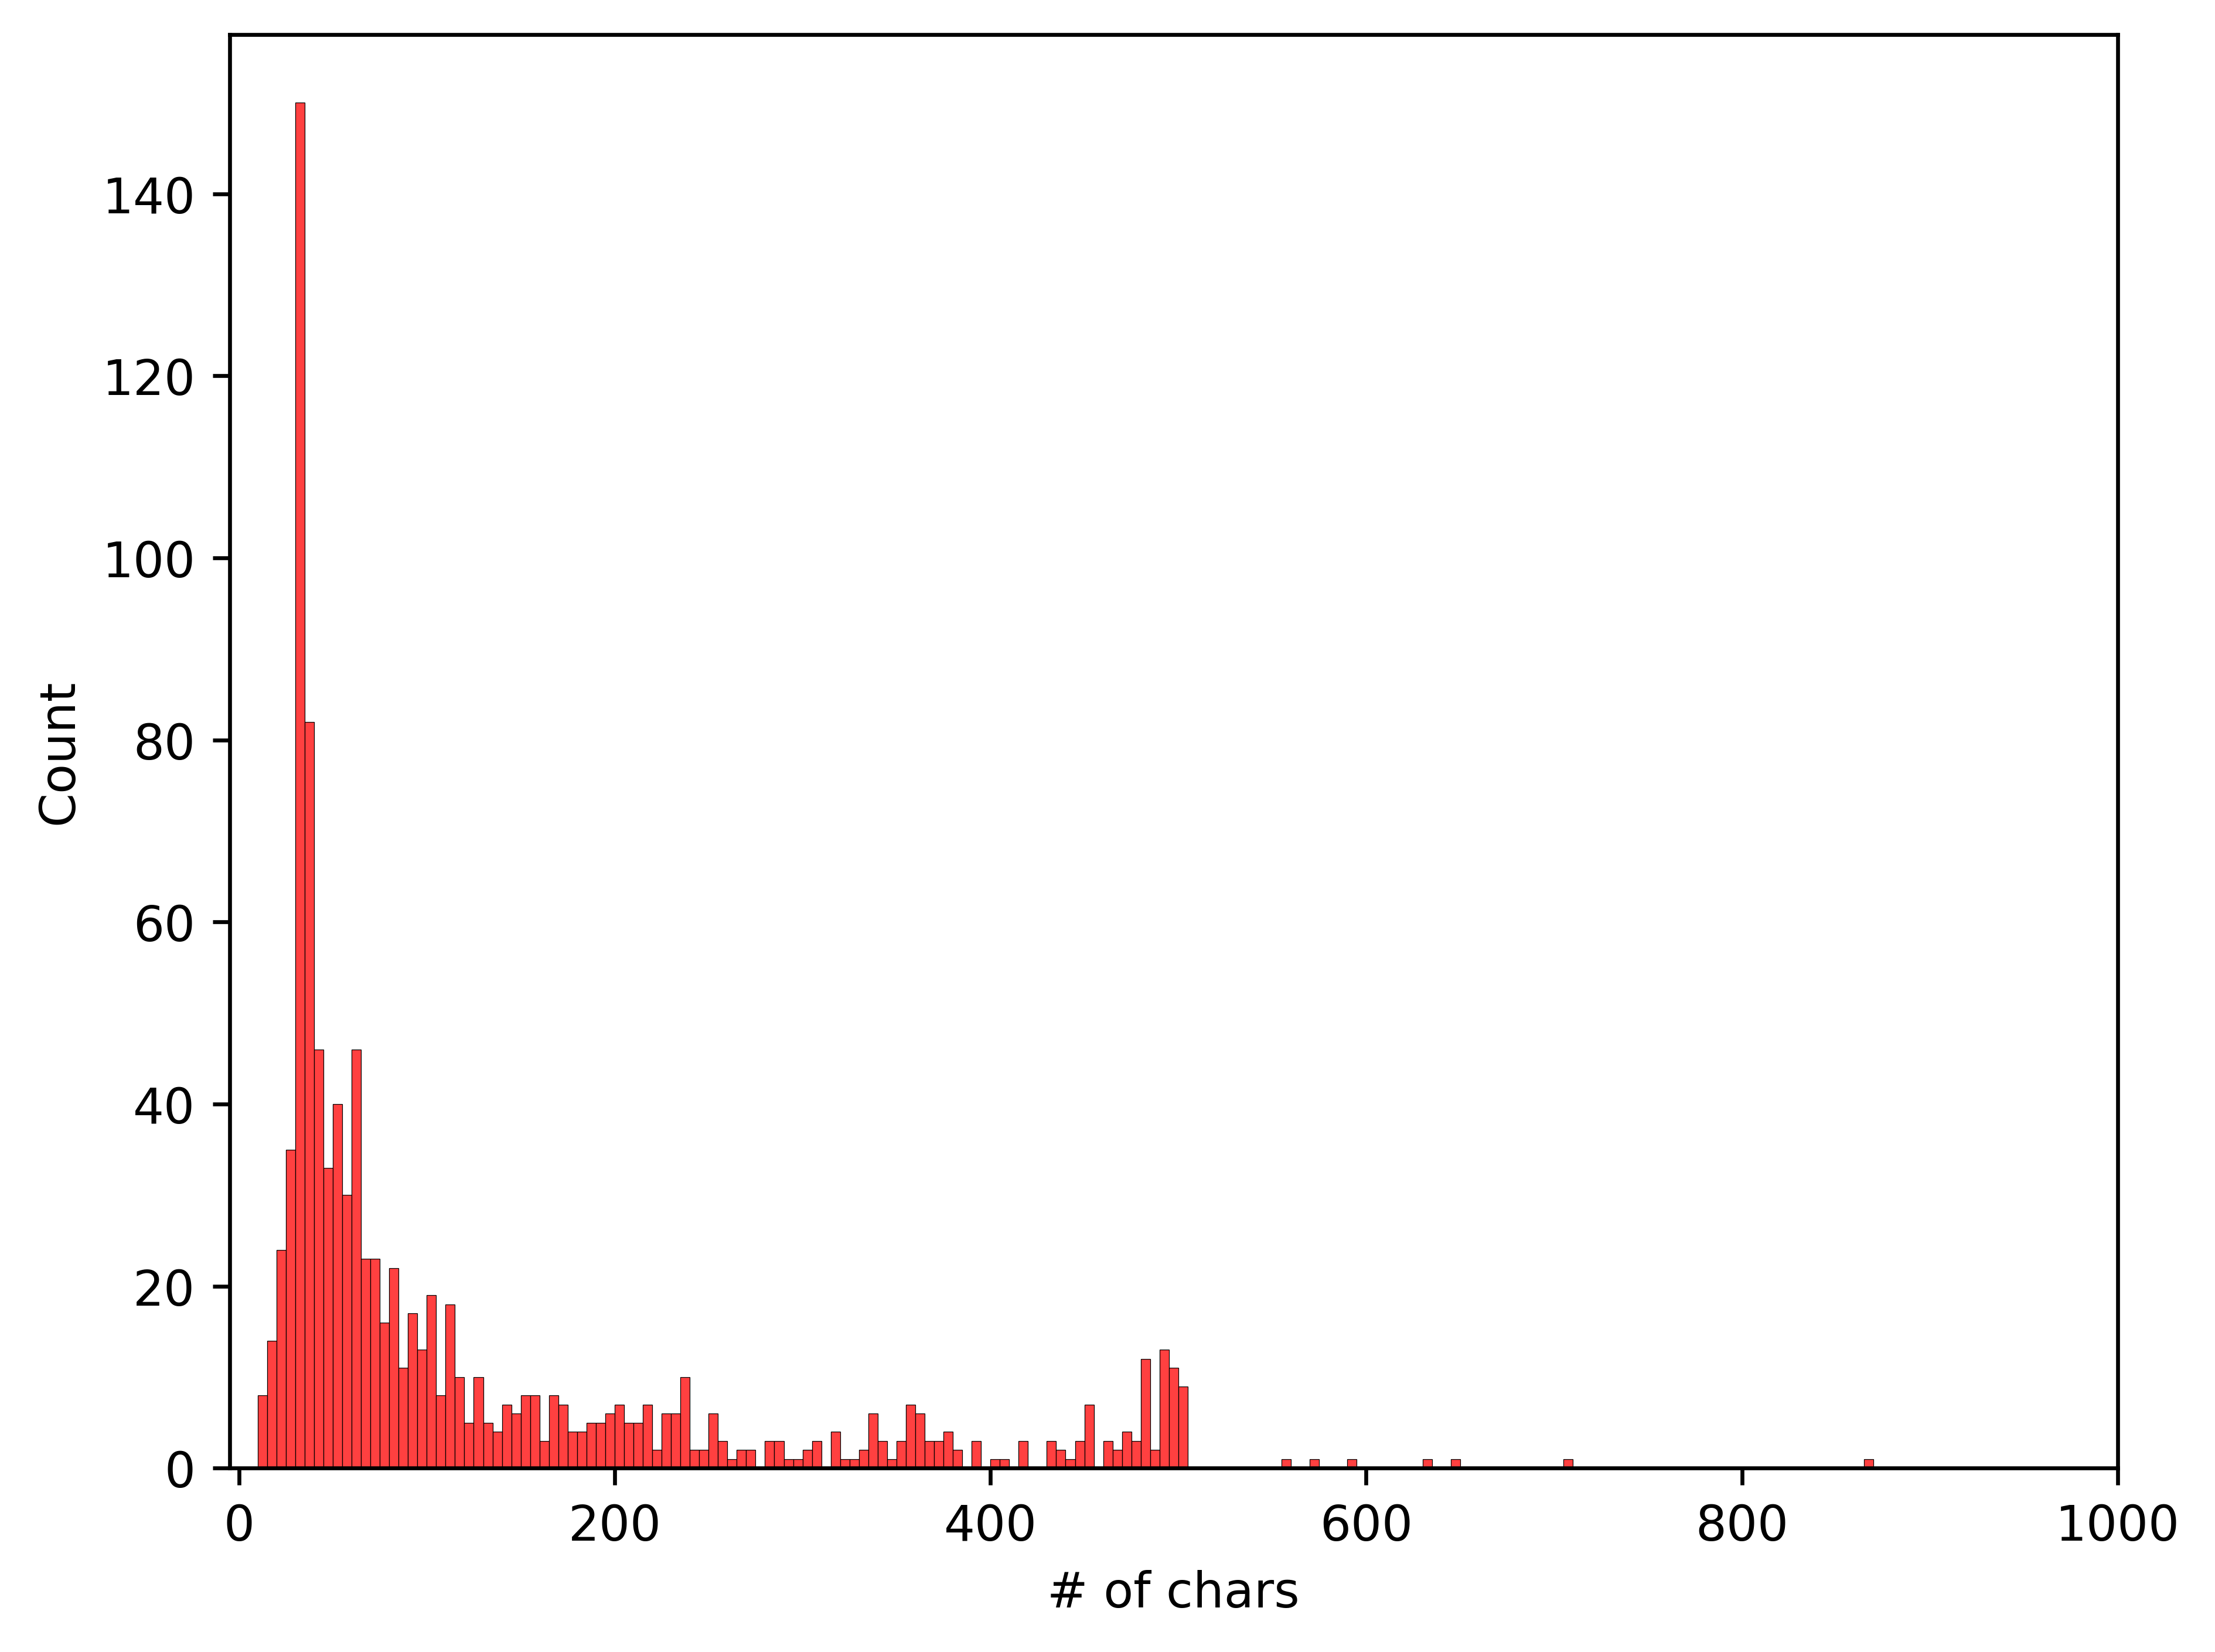

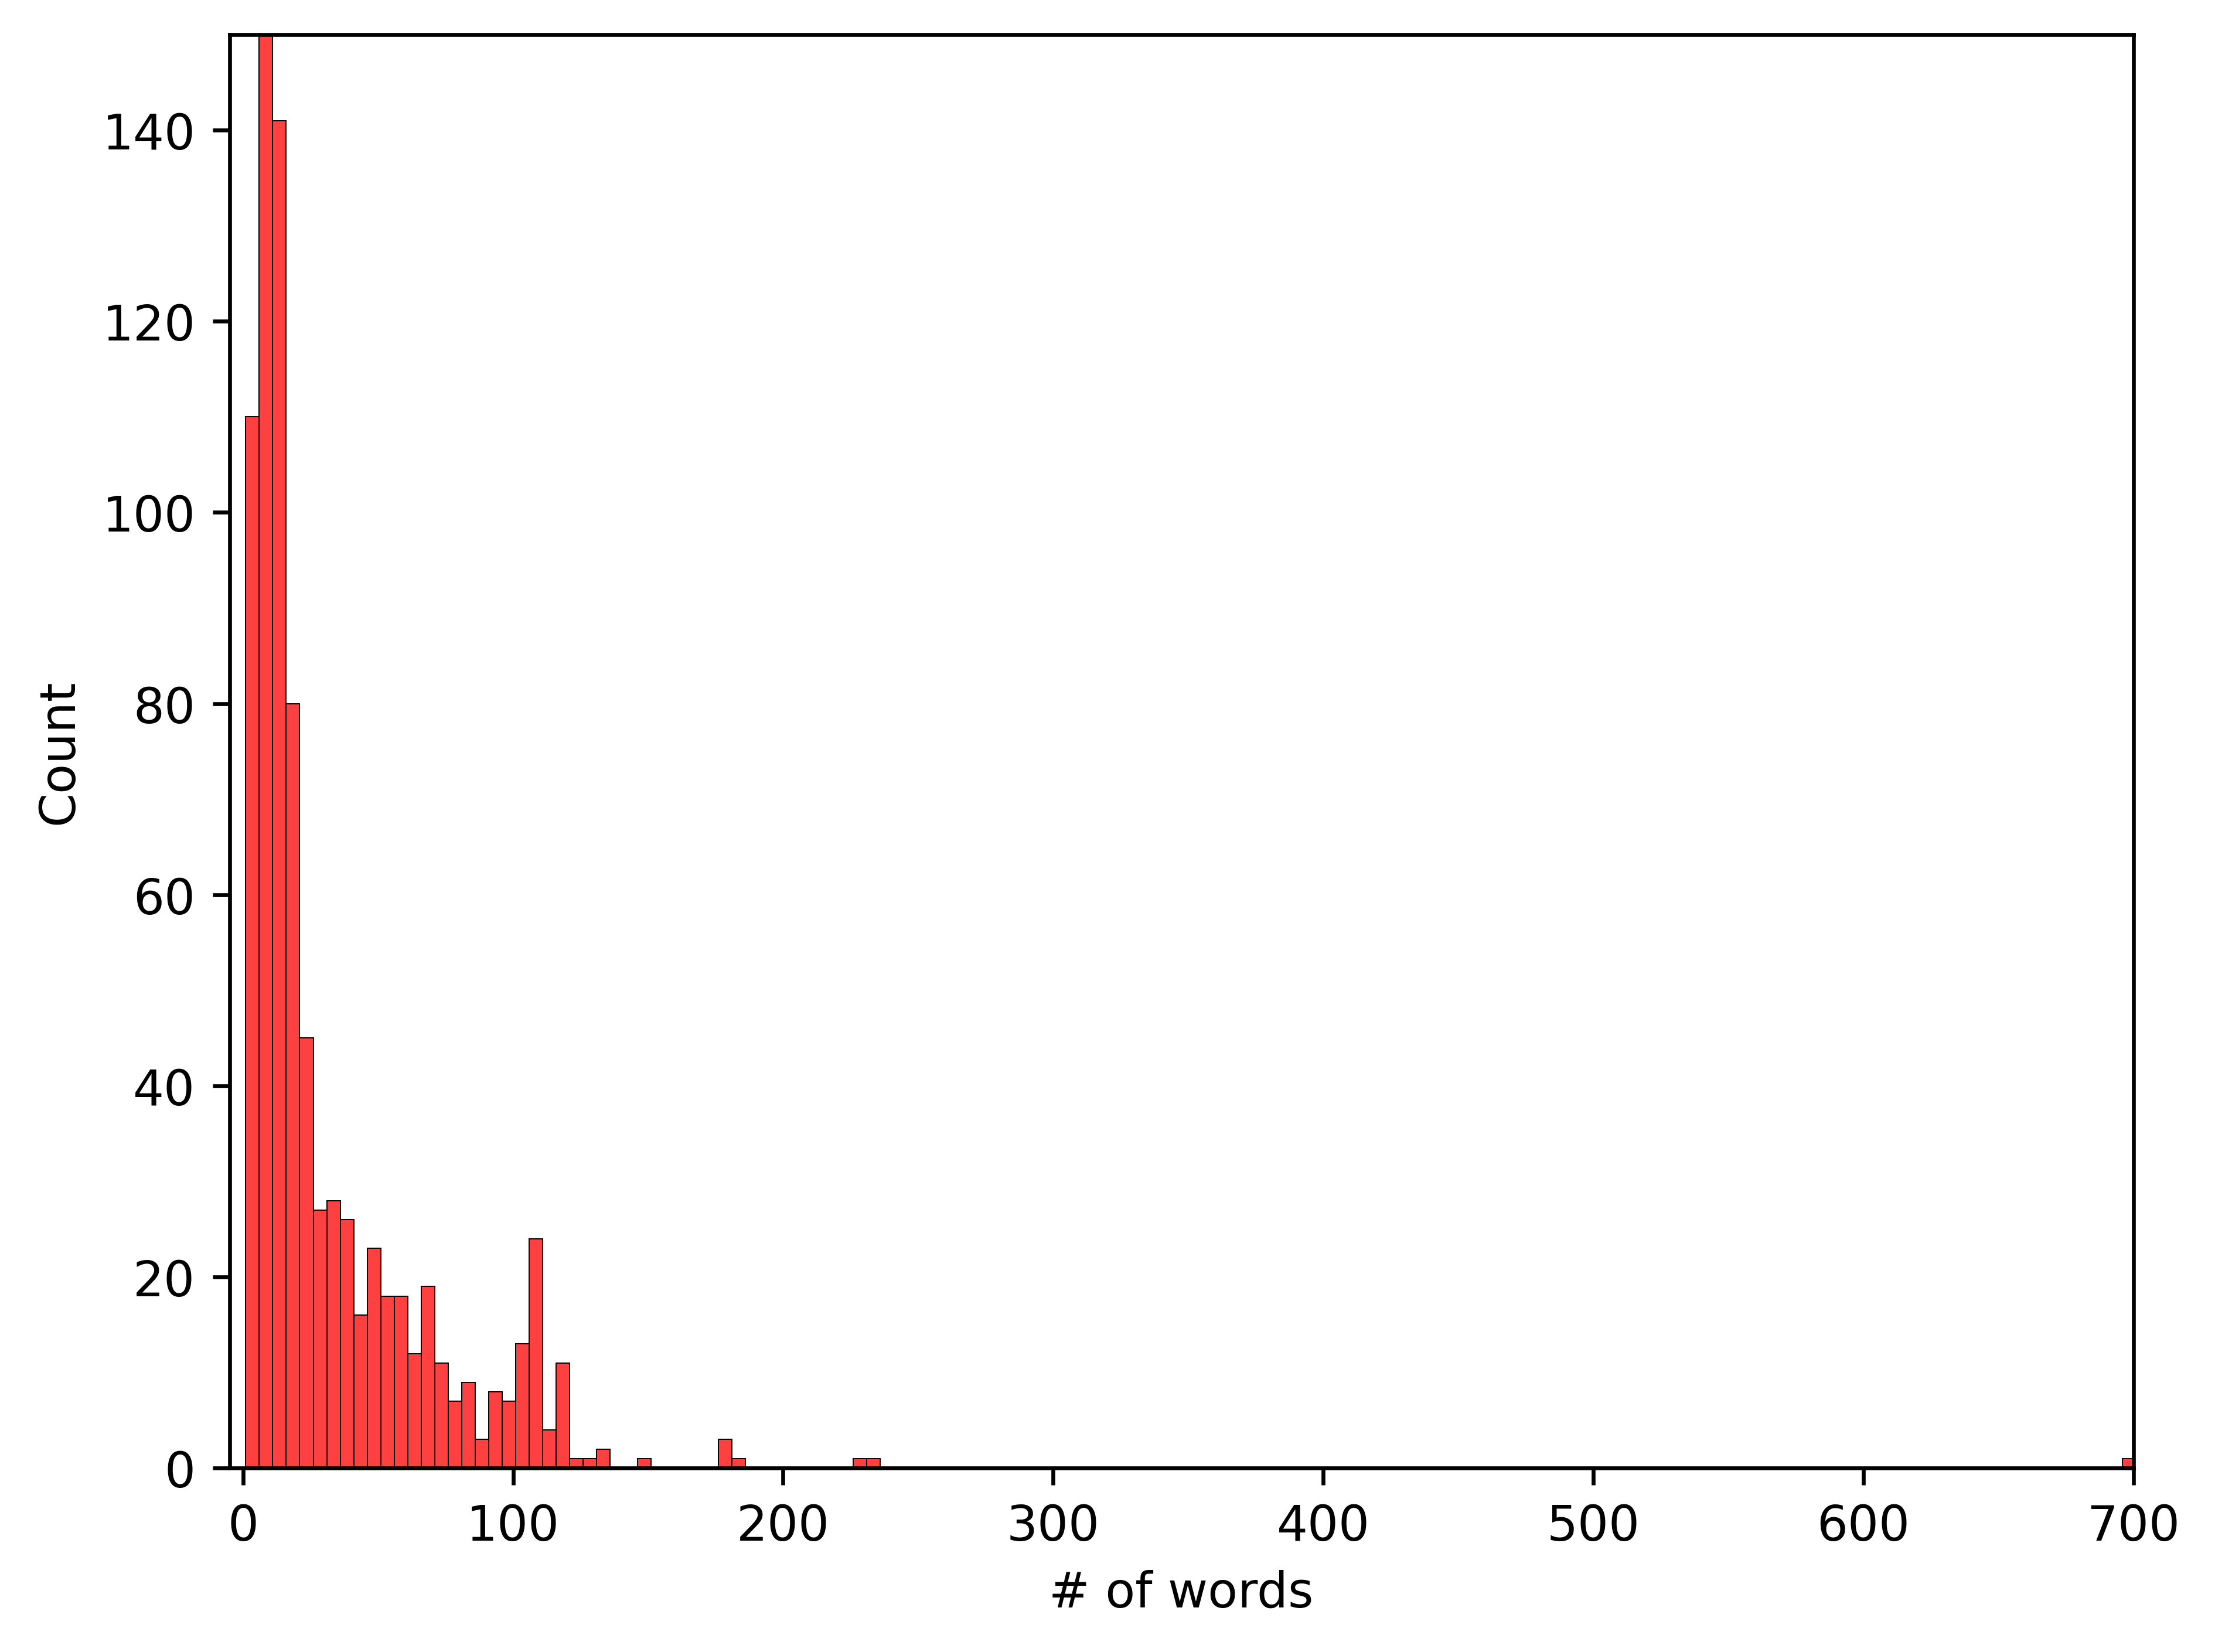

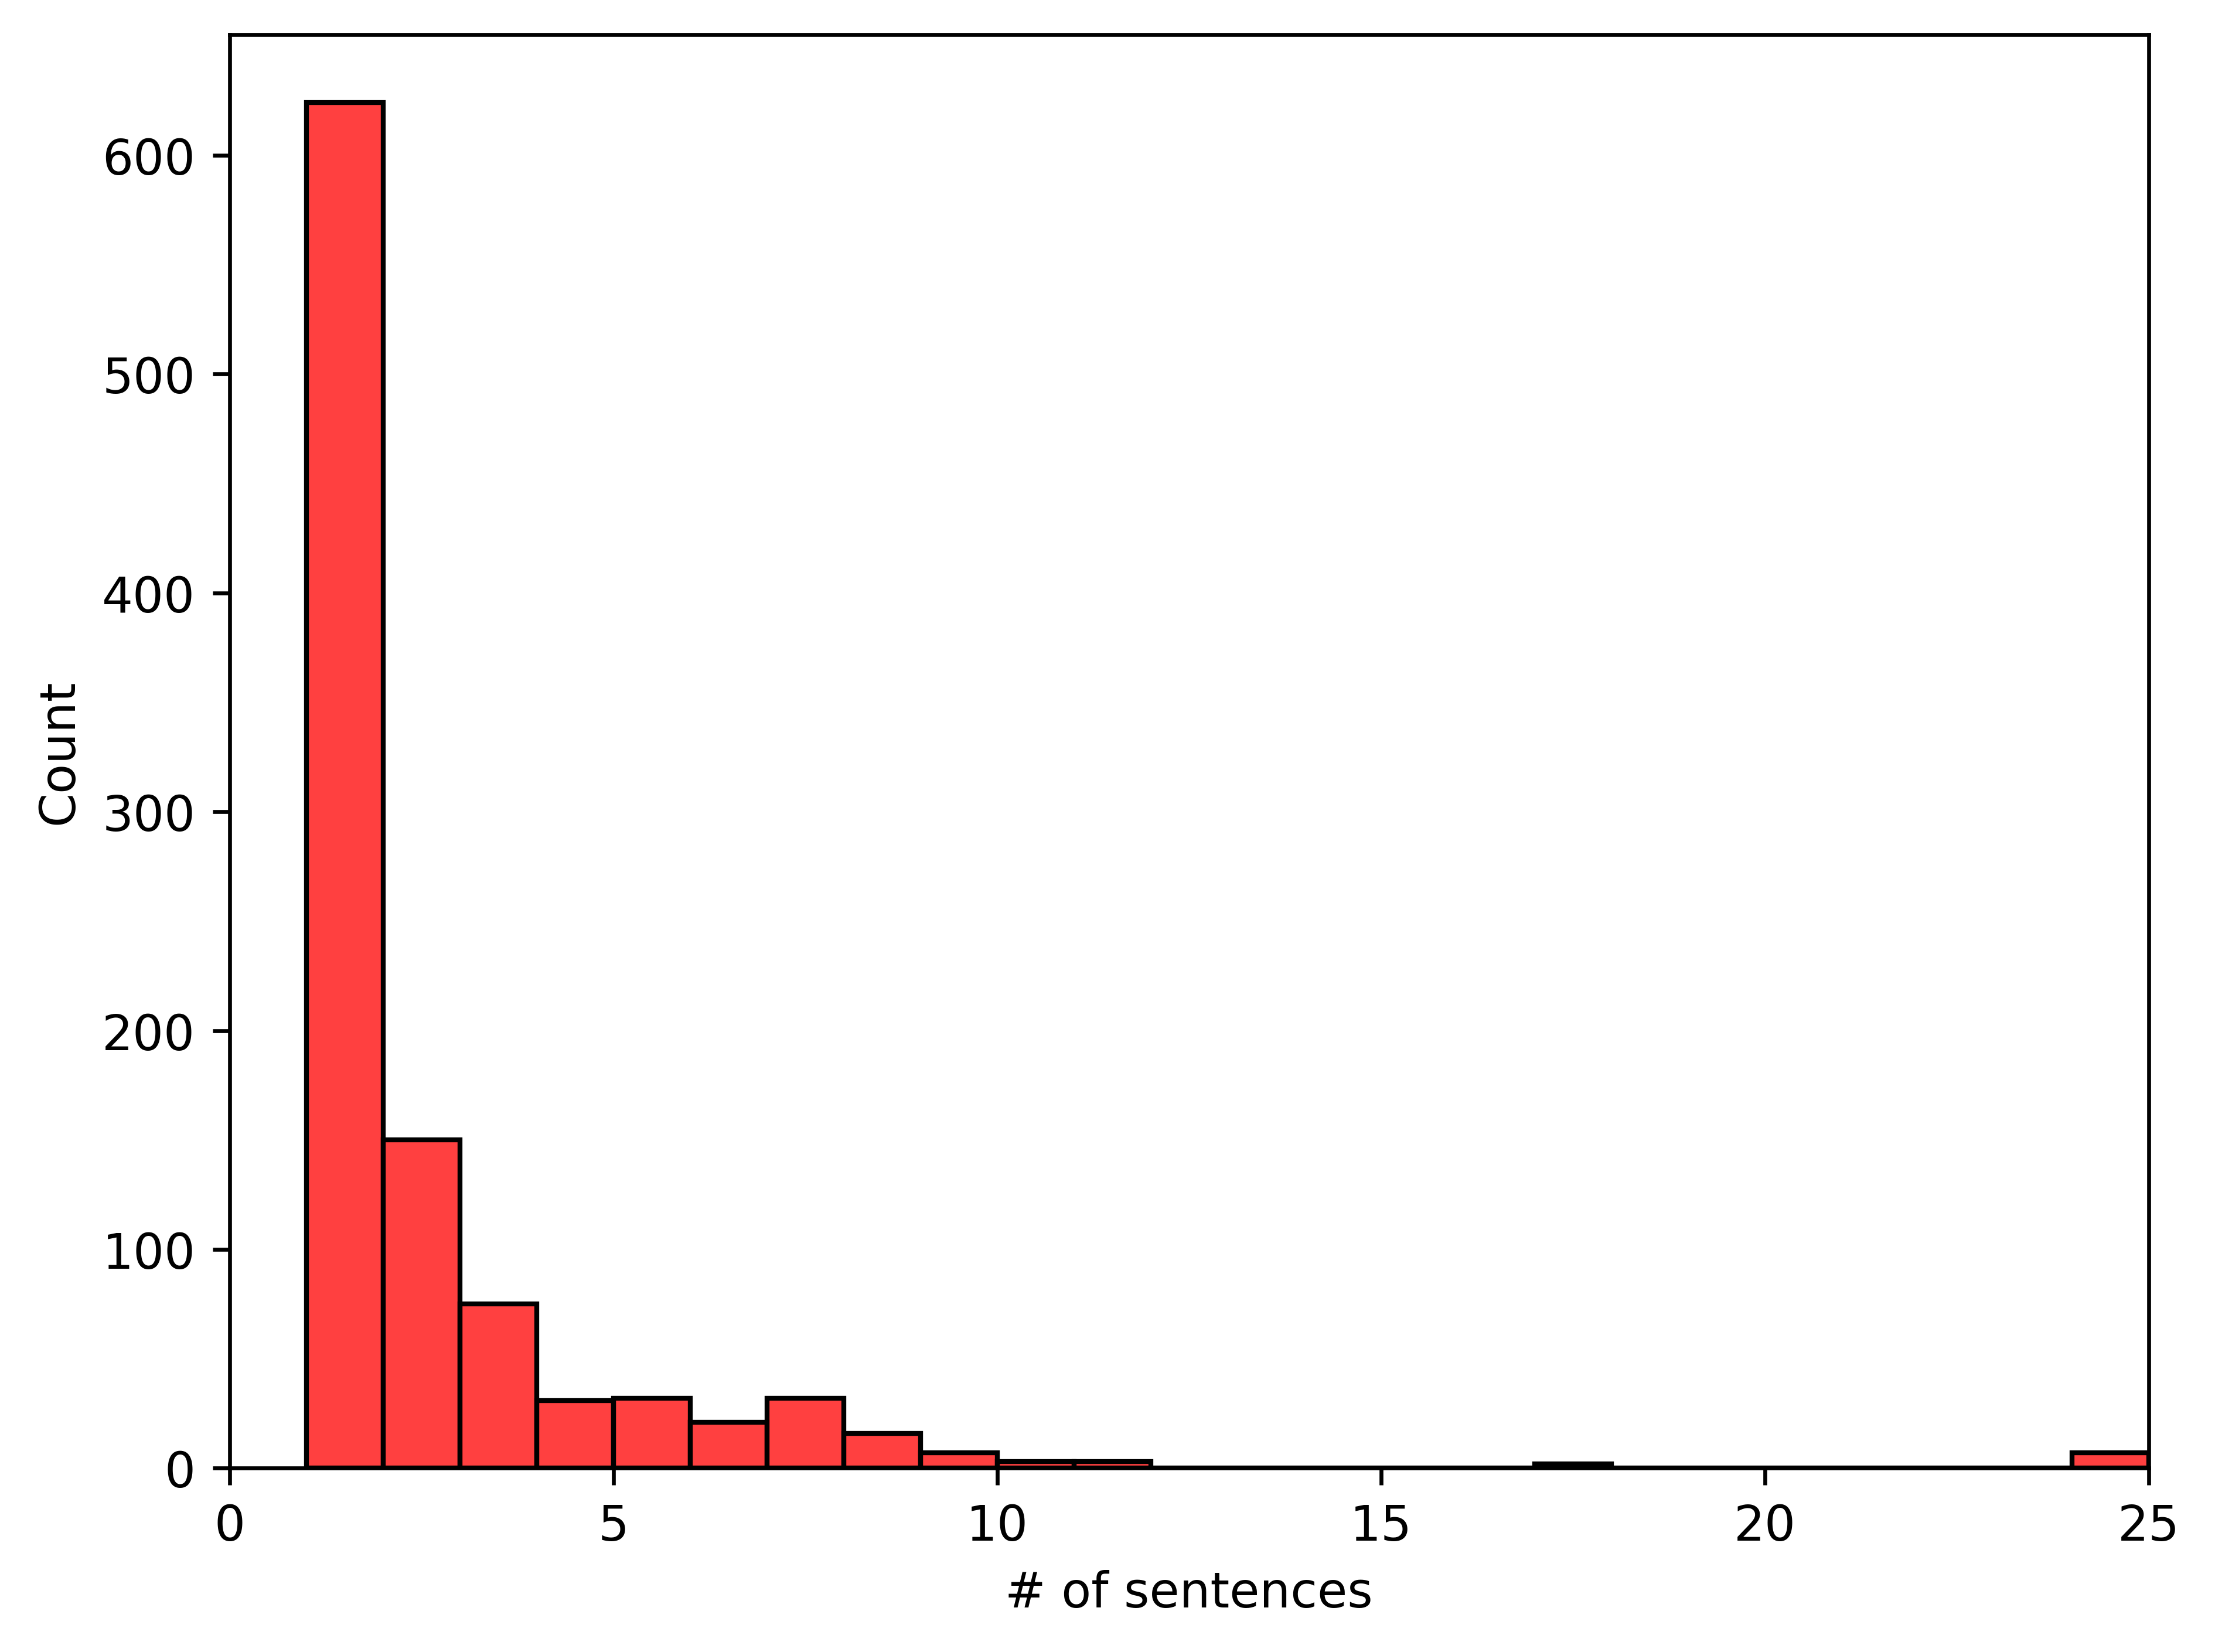

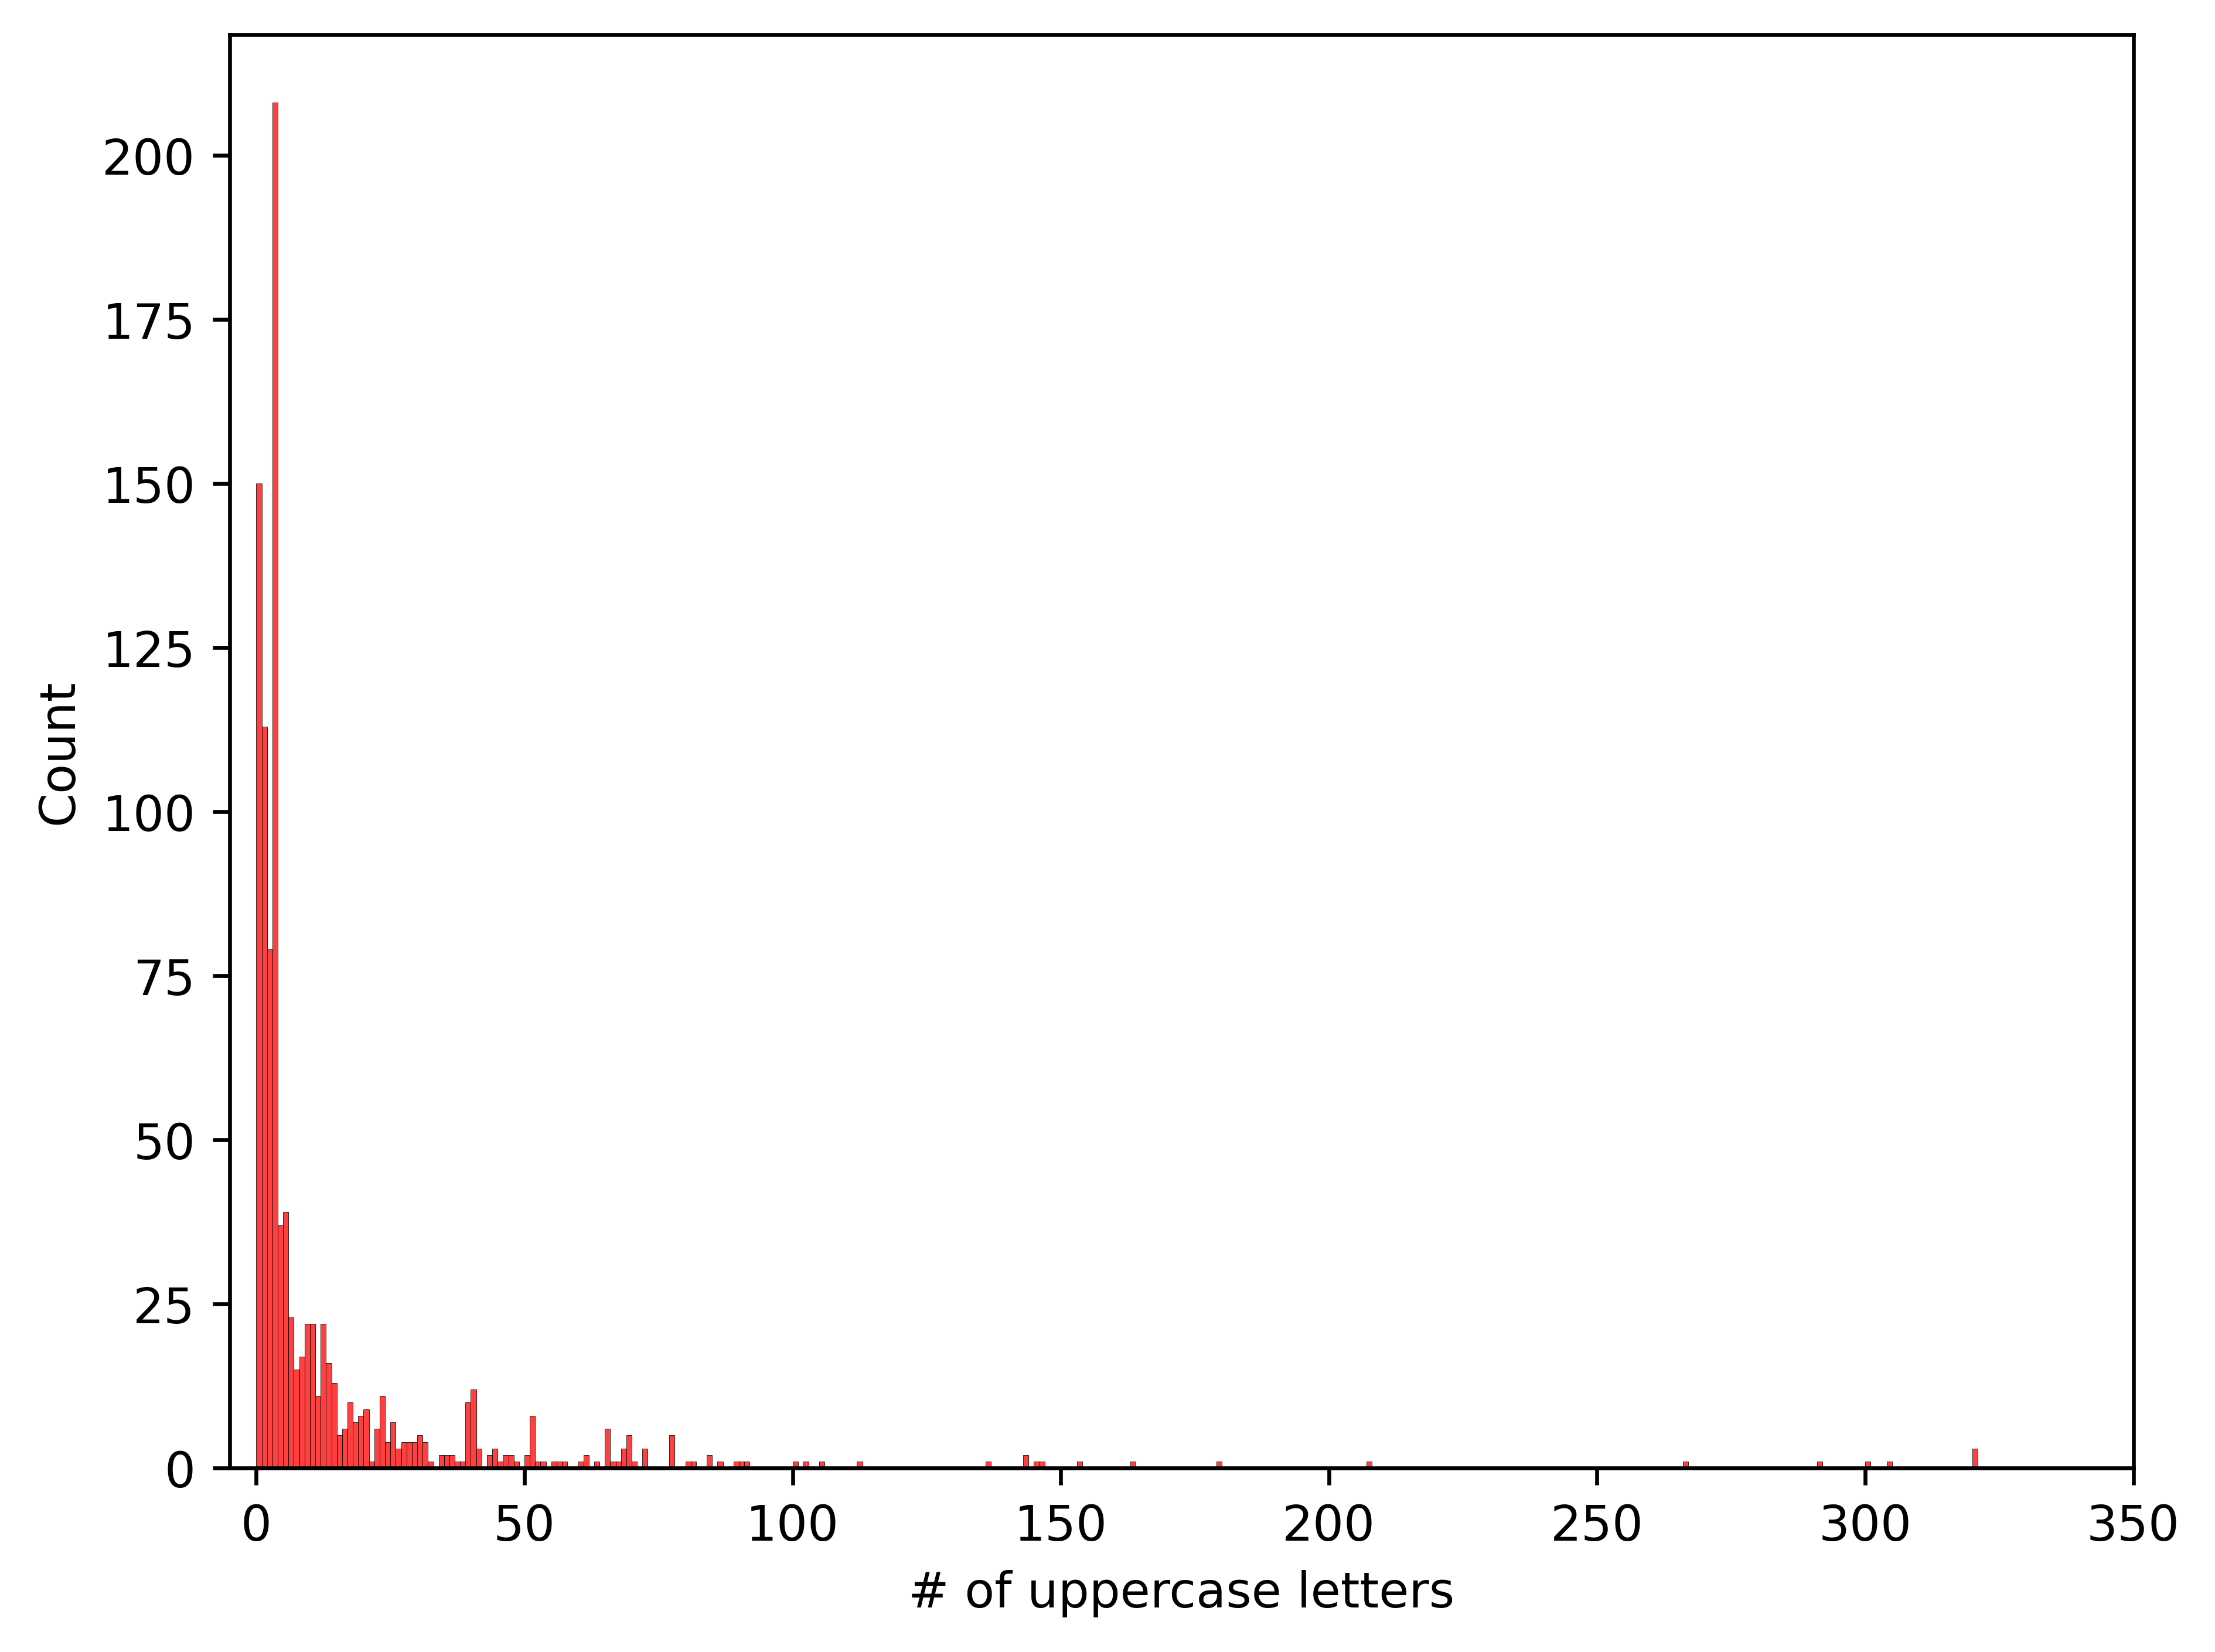

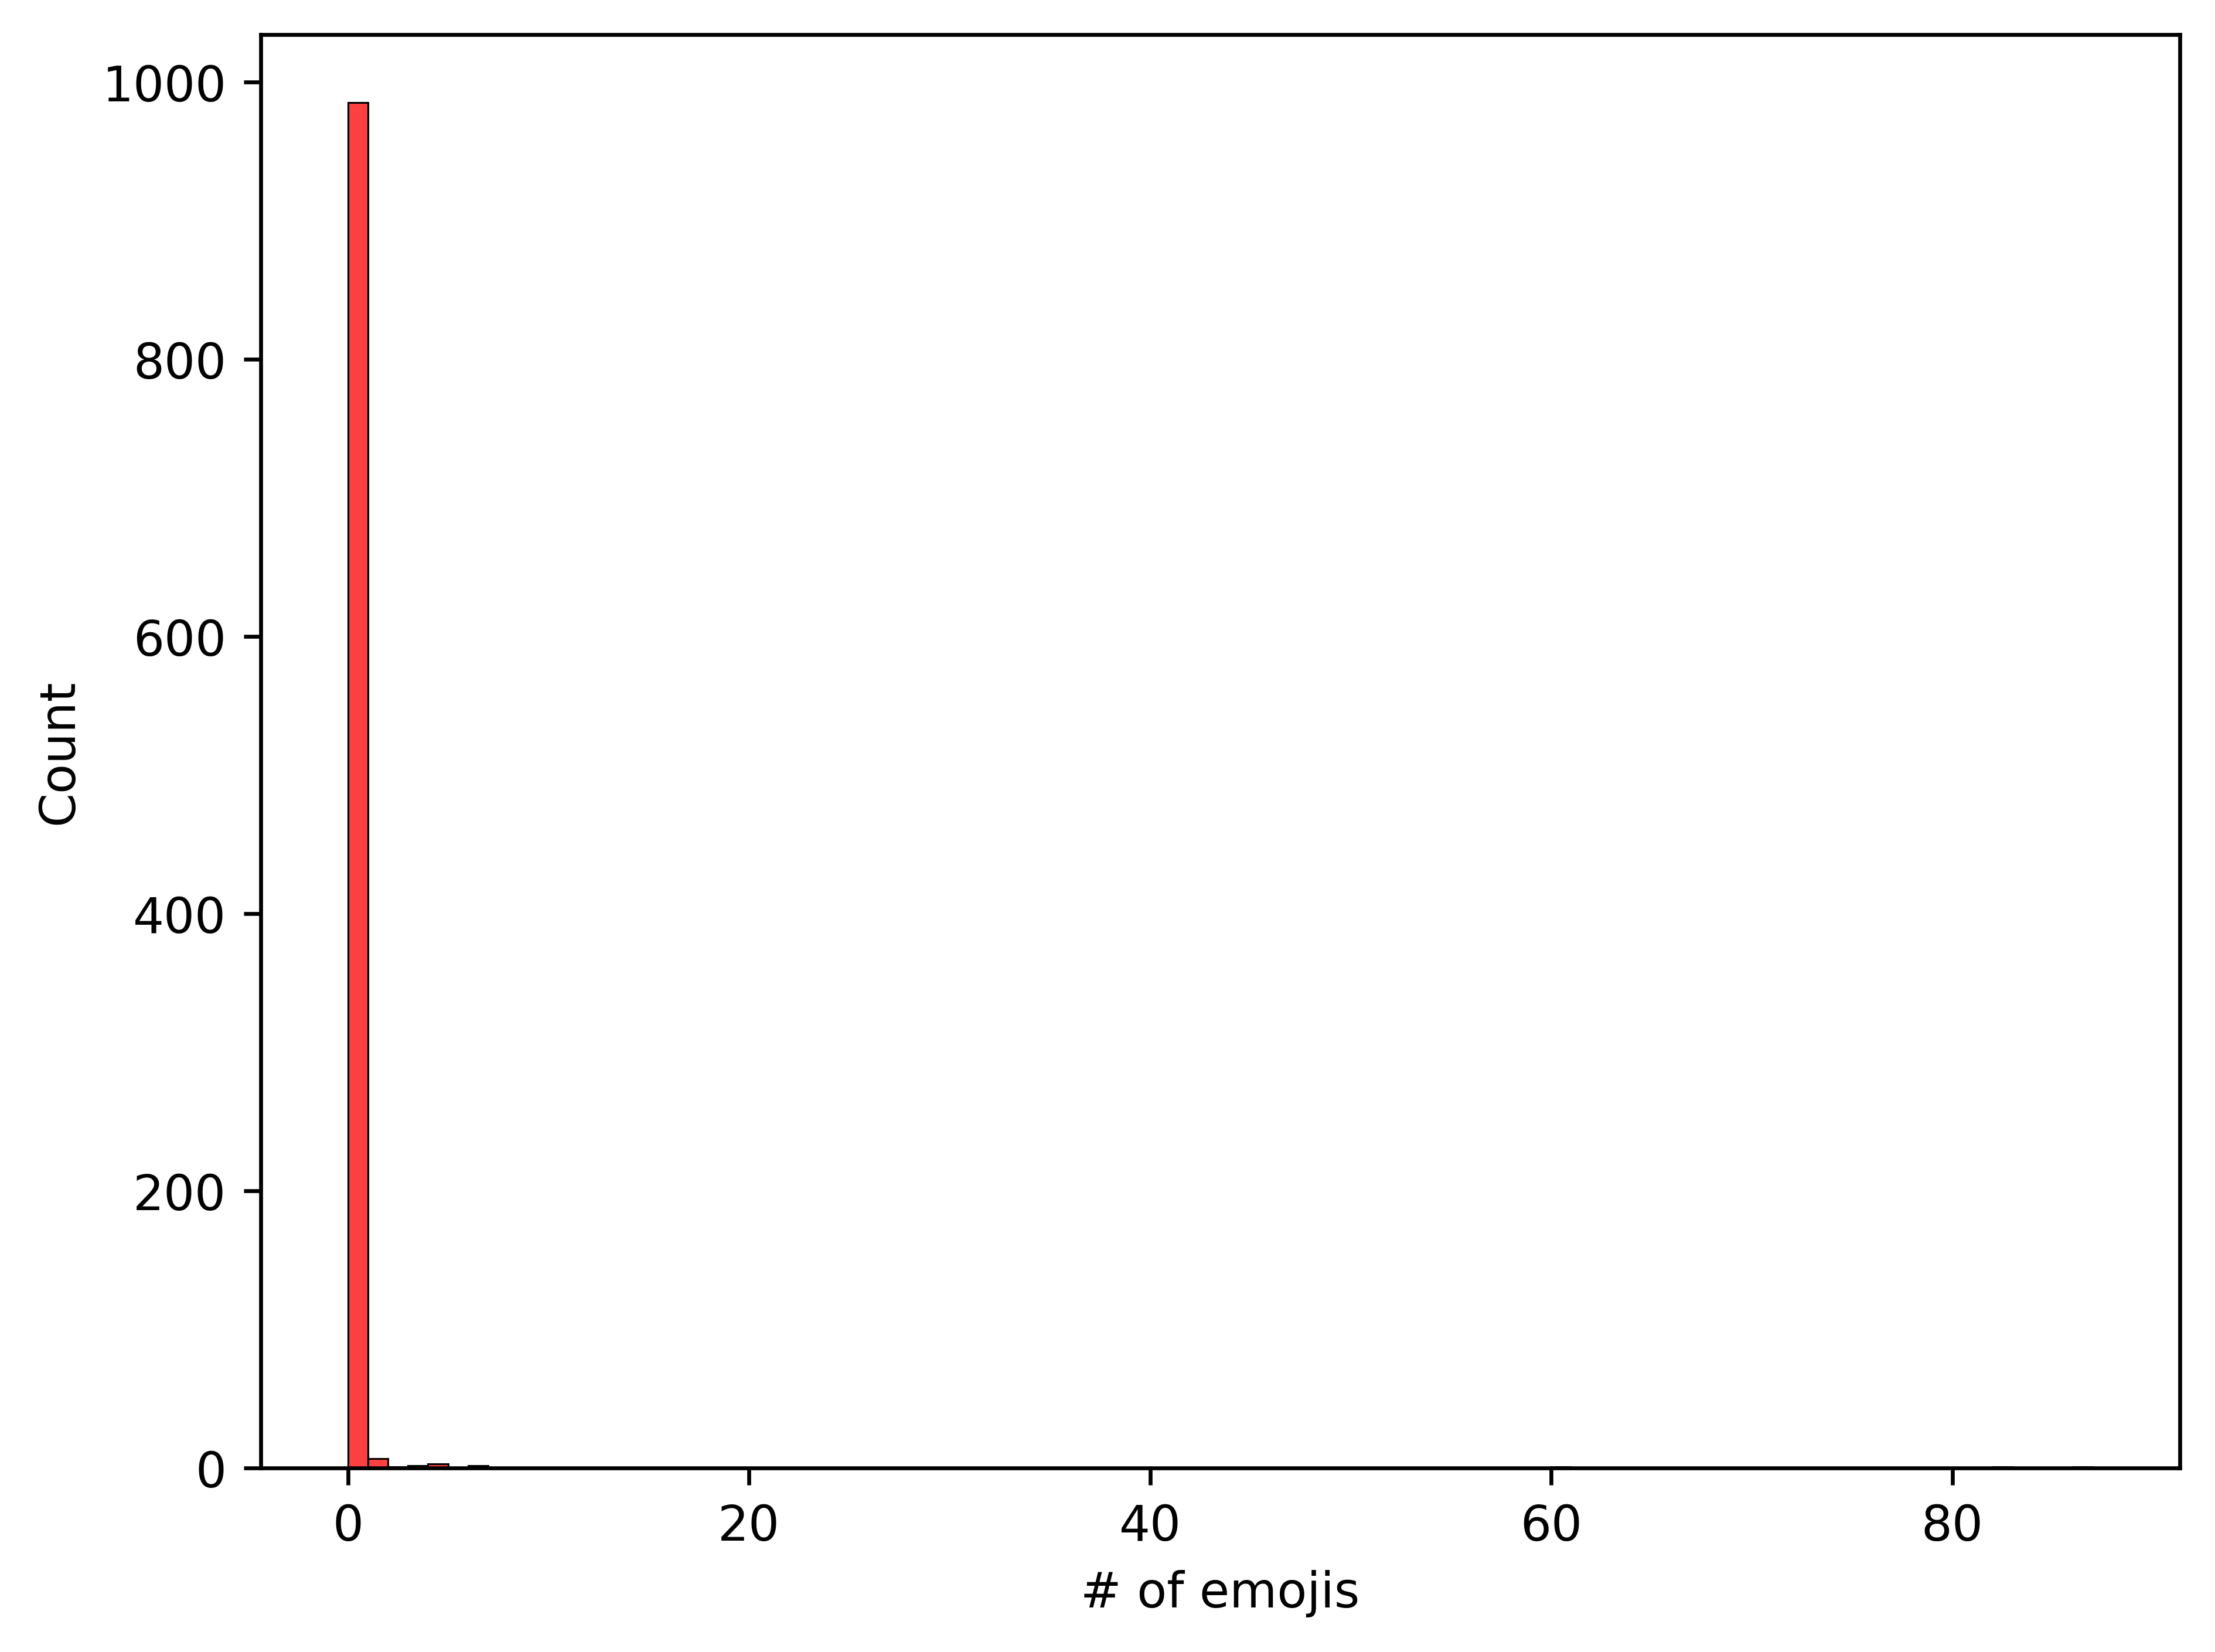

In [18]:
# Plot barplot/histogram of extracted features divided per class

copy = df.copy()

plt.figure(dpi=600)
g = sns.countplot(x=copy.HAS_LINKS, hue=copy.CLASS)
g.set_xticklabels(["No", "Yes"])
g.legend(labels=["Ham", "Spam"])
g.set_xlabel("Has links?")
g.set_ylabel("Count")
plt.savefig("figures/links_countplot_class", transparent=True)
plt.show()

plt.figure(dpi=600)
g = sns.countplot(x=copy.HAS_YT_LINKS, hue=copy.CLASS)
g.set_xticklabels(["No", "Yes"])
g.legend(labels=["Ham", "Spam"])
g.set_xlabel("Has YouTube links?")
g.set_ylabel("Count")
plt.savefig("figures/yt_links_countplot_class", transparent=True)
plt.show()

plt.figure(dpi=600)
g = sns.countplot(x=copy.HAS_NON_ASCII_CHARS, hue=copy.CLASS)
g.set_xticklabels(["No", "Yes"])
g.legend(labels=["Ham", "Spam"])
g.set_xlabel("Has non-ASCII chars?")
g.set_ylabel("Count")
plt.savefig("figures/non_ascii_countplot_class", transparent=True)
plt.show()

# Histplots (class == 0)

plt.figure(dpi=600)
g = sns.histplot(x=copy[copy.CLASS == 0].CHAR_COUNT, binwidth=5)
g.set_xlim(-5, 1000)
g.set_ylim(0, 150)
g.set_xlabel("# of chars")
g.set_ylabel("Count")
plt.tight_layout()
plt.savefig("figures/chars_histplot_class_0", transparent=True)
plt.show()

plt.figure(dpi=600)
g = sns.histplot(x=copy[copy.CLASS == 0].WORD_COUNT, binwidth=5)
g.set_xlim(-5, 700)
g.set_xlabel("# of words")
g.set_ylabel("Count")
plt.tight_layout()
plt.savefig("figures/words_histplot_class_0", transparent=True)
plt.show()

plt.figure(dpi=600)
g = sns.histplot(x=copy[copy.CLASS == 0].SENTENCE_COUNT, binwidth=1)
g.set_xlim(0, 25)
g.set_xlabel("# of sentences")
g.set_ylabel("Count")
plt.tight_layout()
plt.savefig("figures/sentences_histplot_class_0", transparent=True)
plt.show()

plt.figure(dpi=600)
g = sns.histplot(x=copy[copy.CLASS == 0].UPPERCASE_COUNT, binwidth=1)
g.set_xlim(-5, 350)
g.set_xlabel("# of uppercase letters")
g.set_ylabel("Count")
plt.tight_layout()
plt.savefig("figures/uppercases_histplot_class_0", transparent=True)
plt.show()

plt.figure(dpi=600)
g = sns.histplot(x=copy[copy.CLASS == 0].EMOJI_COUNT, binwidth=1)
g.set_xlabel("# of emojis")
g.set_ylabel("Count")
plt.tight_layout()
plt.savefig("figures/emojis_histplot_class_0", transparent=True)
plt.show()


# Histplots (class == 1)

plt.figure(dpi=600)
g = sns.histplot(x=copy[copy.CLASS == 1].CHAR_COUNT, binwidth=5, color="red")
g.set_xlim(-5, 1000)
g.set_xlabel("# of chars")
g.set_ylabel("Count")
plt.tight_layout()
plt.savefig("figures/chars_histplot_class_1", transparent=True)
plt.show()

plt.figure(dpi=600)
g = sns.histplot(x=copy[copy.CLASS == 1].WORD_COUNT, binwidth=5, color="red")
g.set_ylim(0, 150)
g.set_xlim(-5, 700)
g.set_xlabel("# of words")
g.set_ylabel("Count")
plt.tight_layout()
plt.savefig("figures/words_histplot_class_1", transparent=True)
plt.show()

plt.figure(dpi=600)
g = sns.histplot(x=copy[copy.CLASS == 1].SENTENCE_COUNT, binwidth=1, color="red")
g.set_xlim(0, 25)
g.set_xlabel("# of sentences")
g.set_ylabel("Count")
plt.tight_layout()
plt.savefig("figures/sentences_histplot_class_1", transparent=True)
plt.show()

plt.figure(dpi=600)
g = sns.histplot(x=copy[copy.CLASS == 1].UPPERCASE_COUNT, binwidth=1, color="red")
g.set_xlim(-5, 350)
g.set_xlabel("# of uppercase letters")
g.set_ylabel("Count")
plt.tight_layout()
plt.savefig("figures/uppercases_histplot_class_1", transparent=True)
plt.show()

plt.figure(dpi=600)
g = sns.histplot(x=copy[copy.CLASS == 1].EMOJI_COUNT, binwidth=1, color="red")
g.set_xlabel("# of emojis")
g.set_ylabel("Count")
plt.tight_layout()
plt.savefig("figures/emojis_histplot_class_1", transparent=True)
plt.show()

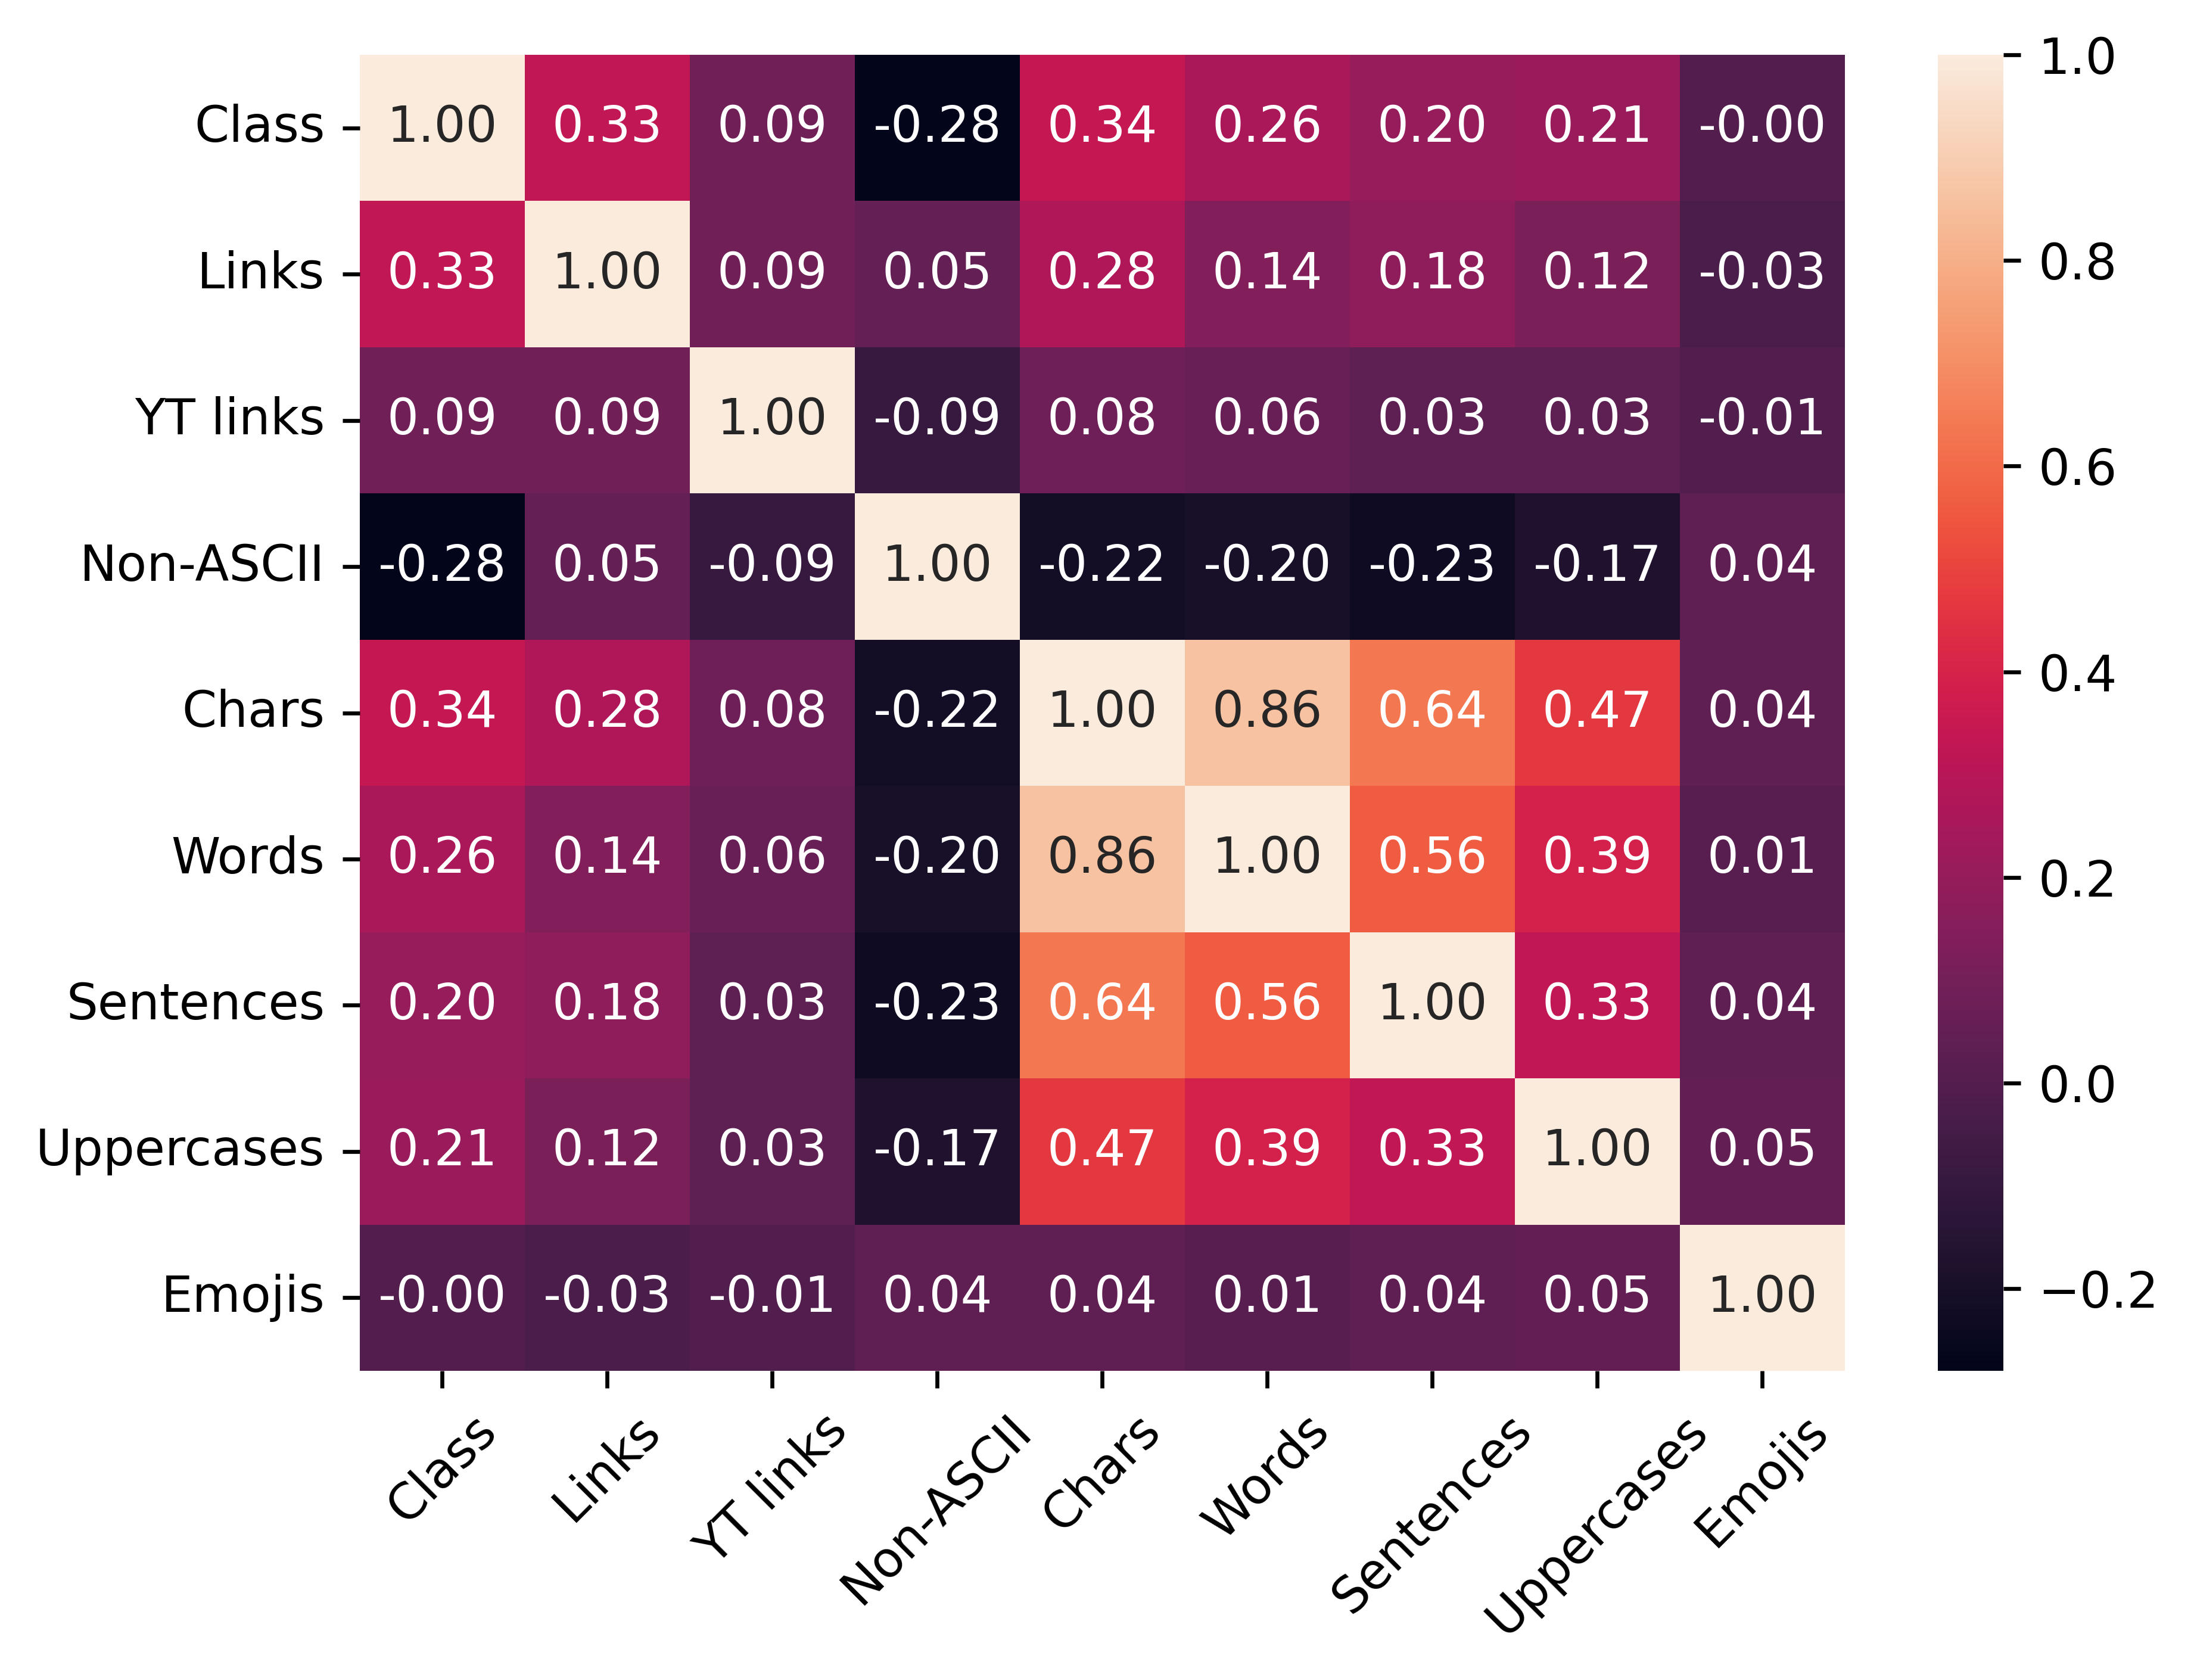

In [19]:
# See if there are correlated features (e.g. HAS_LINKS and CLASS)
# Of course, CHAR_COUNT, WORD_COUNT and SENTENCE_COUNT are (positively) correlated
copy = df.copy()
copy.rename(
    columns={
        "CLASS": "Class",
        "HAS_LINKS": "Links",
        "HAS_YT_LINKS": "YT links",
        "HAS_NON_ASCII_CHARS": "Non-ASCII",
        "CHAR_COUNT": "Chars",
        "WORD_COUNT": "Words",
        "SENTENCE_COUNT": "Sentences",
        "UPPERCASE_COUNT": "Uppercases",
        "EMOJI_COUNT": "Emojis",
    },
    inplace=True,
)
corr = copy.corr(numeric_only=True)

plt.figure(dpi=600)
g = sns.heatmap(corr, annot=True, fmt=".2f")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("figures/heatmap", transparent=True)

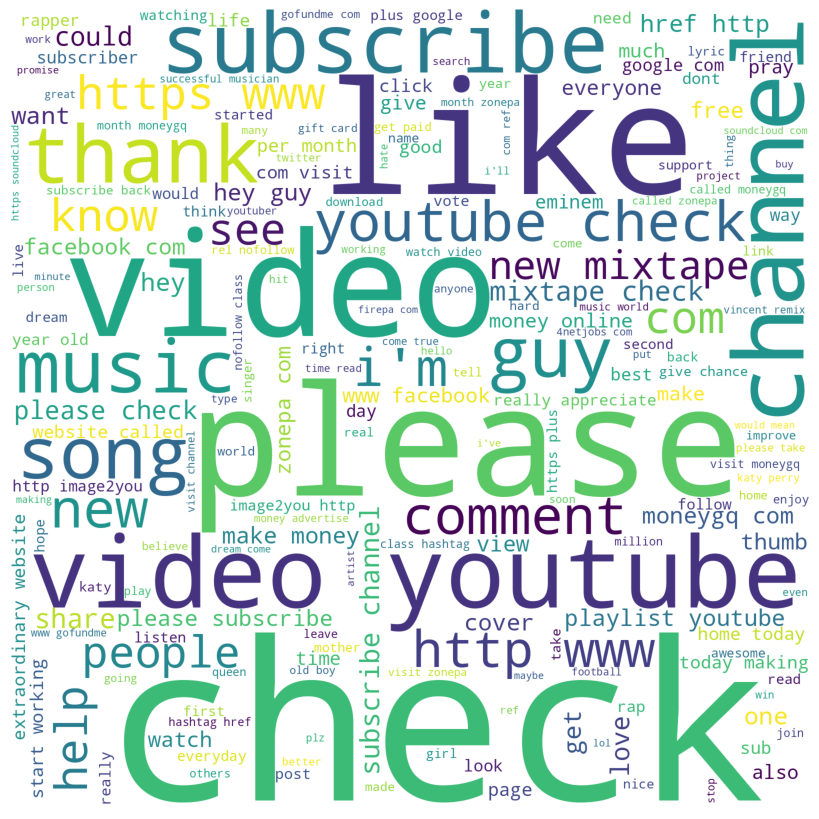

In [20]:
# Show the word cloud for both spam and ham messages
stopwords = nltk.corpus.stopwords.words("english")

spam_comments = " ".join(x.lower() for x in df[df.CLASS == 1].CONTENT)

wordcloud = WordCloud(
    width=1600,
    height=1600,
    normalize_plurals=True,
    min_word_length=3,
    stopwords=stopwords,
    background_color="white",
).generate(spam_comments)
plt.figure(figsize=(8, 8))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.savefig("figures/spam_wordcloud", transparent=True)

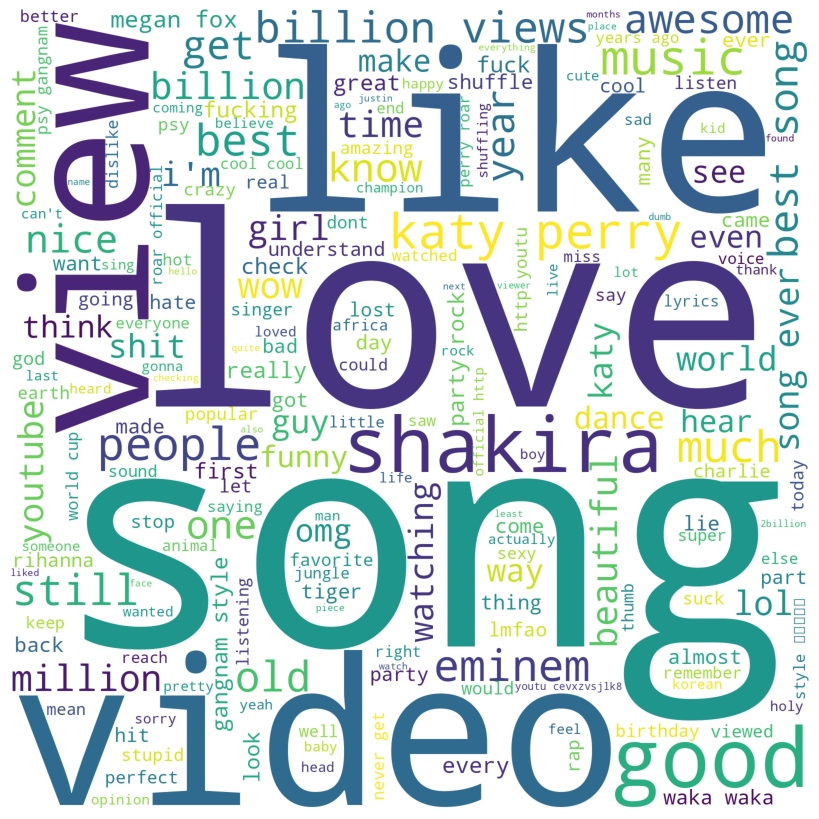

In [21]:
# Show the word cloud for both spam and ham messages
stopwords = nltk.corpus.stopwords.words("english")

ham_comments = " ".join(x.lower() for x in df[df.CLASS == 0].CONTENT)

wordcloud = WordCloud(
    width=1600,
    height=1600,
    normalize_plurals=True,
    min_word_length=3,
    stopwords=stopwords,
    background_color="white",
).generate(ham_comments)
plt.figure(figsize=(8, 8))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.savefig("figures/ham_wordcloud", transparent=True)

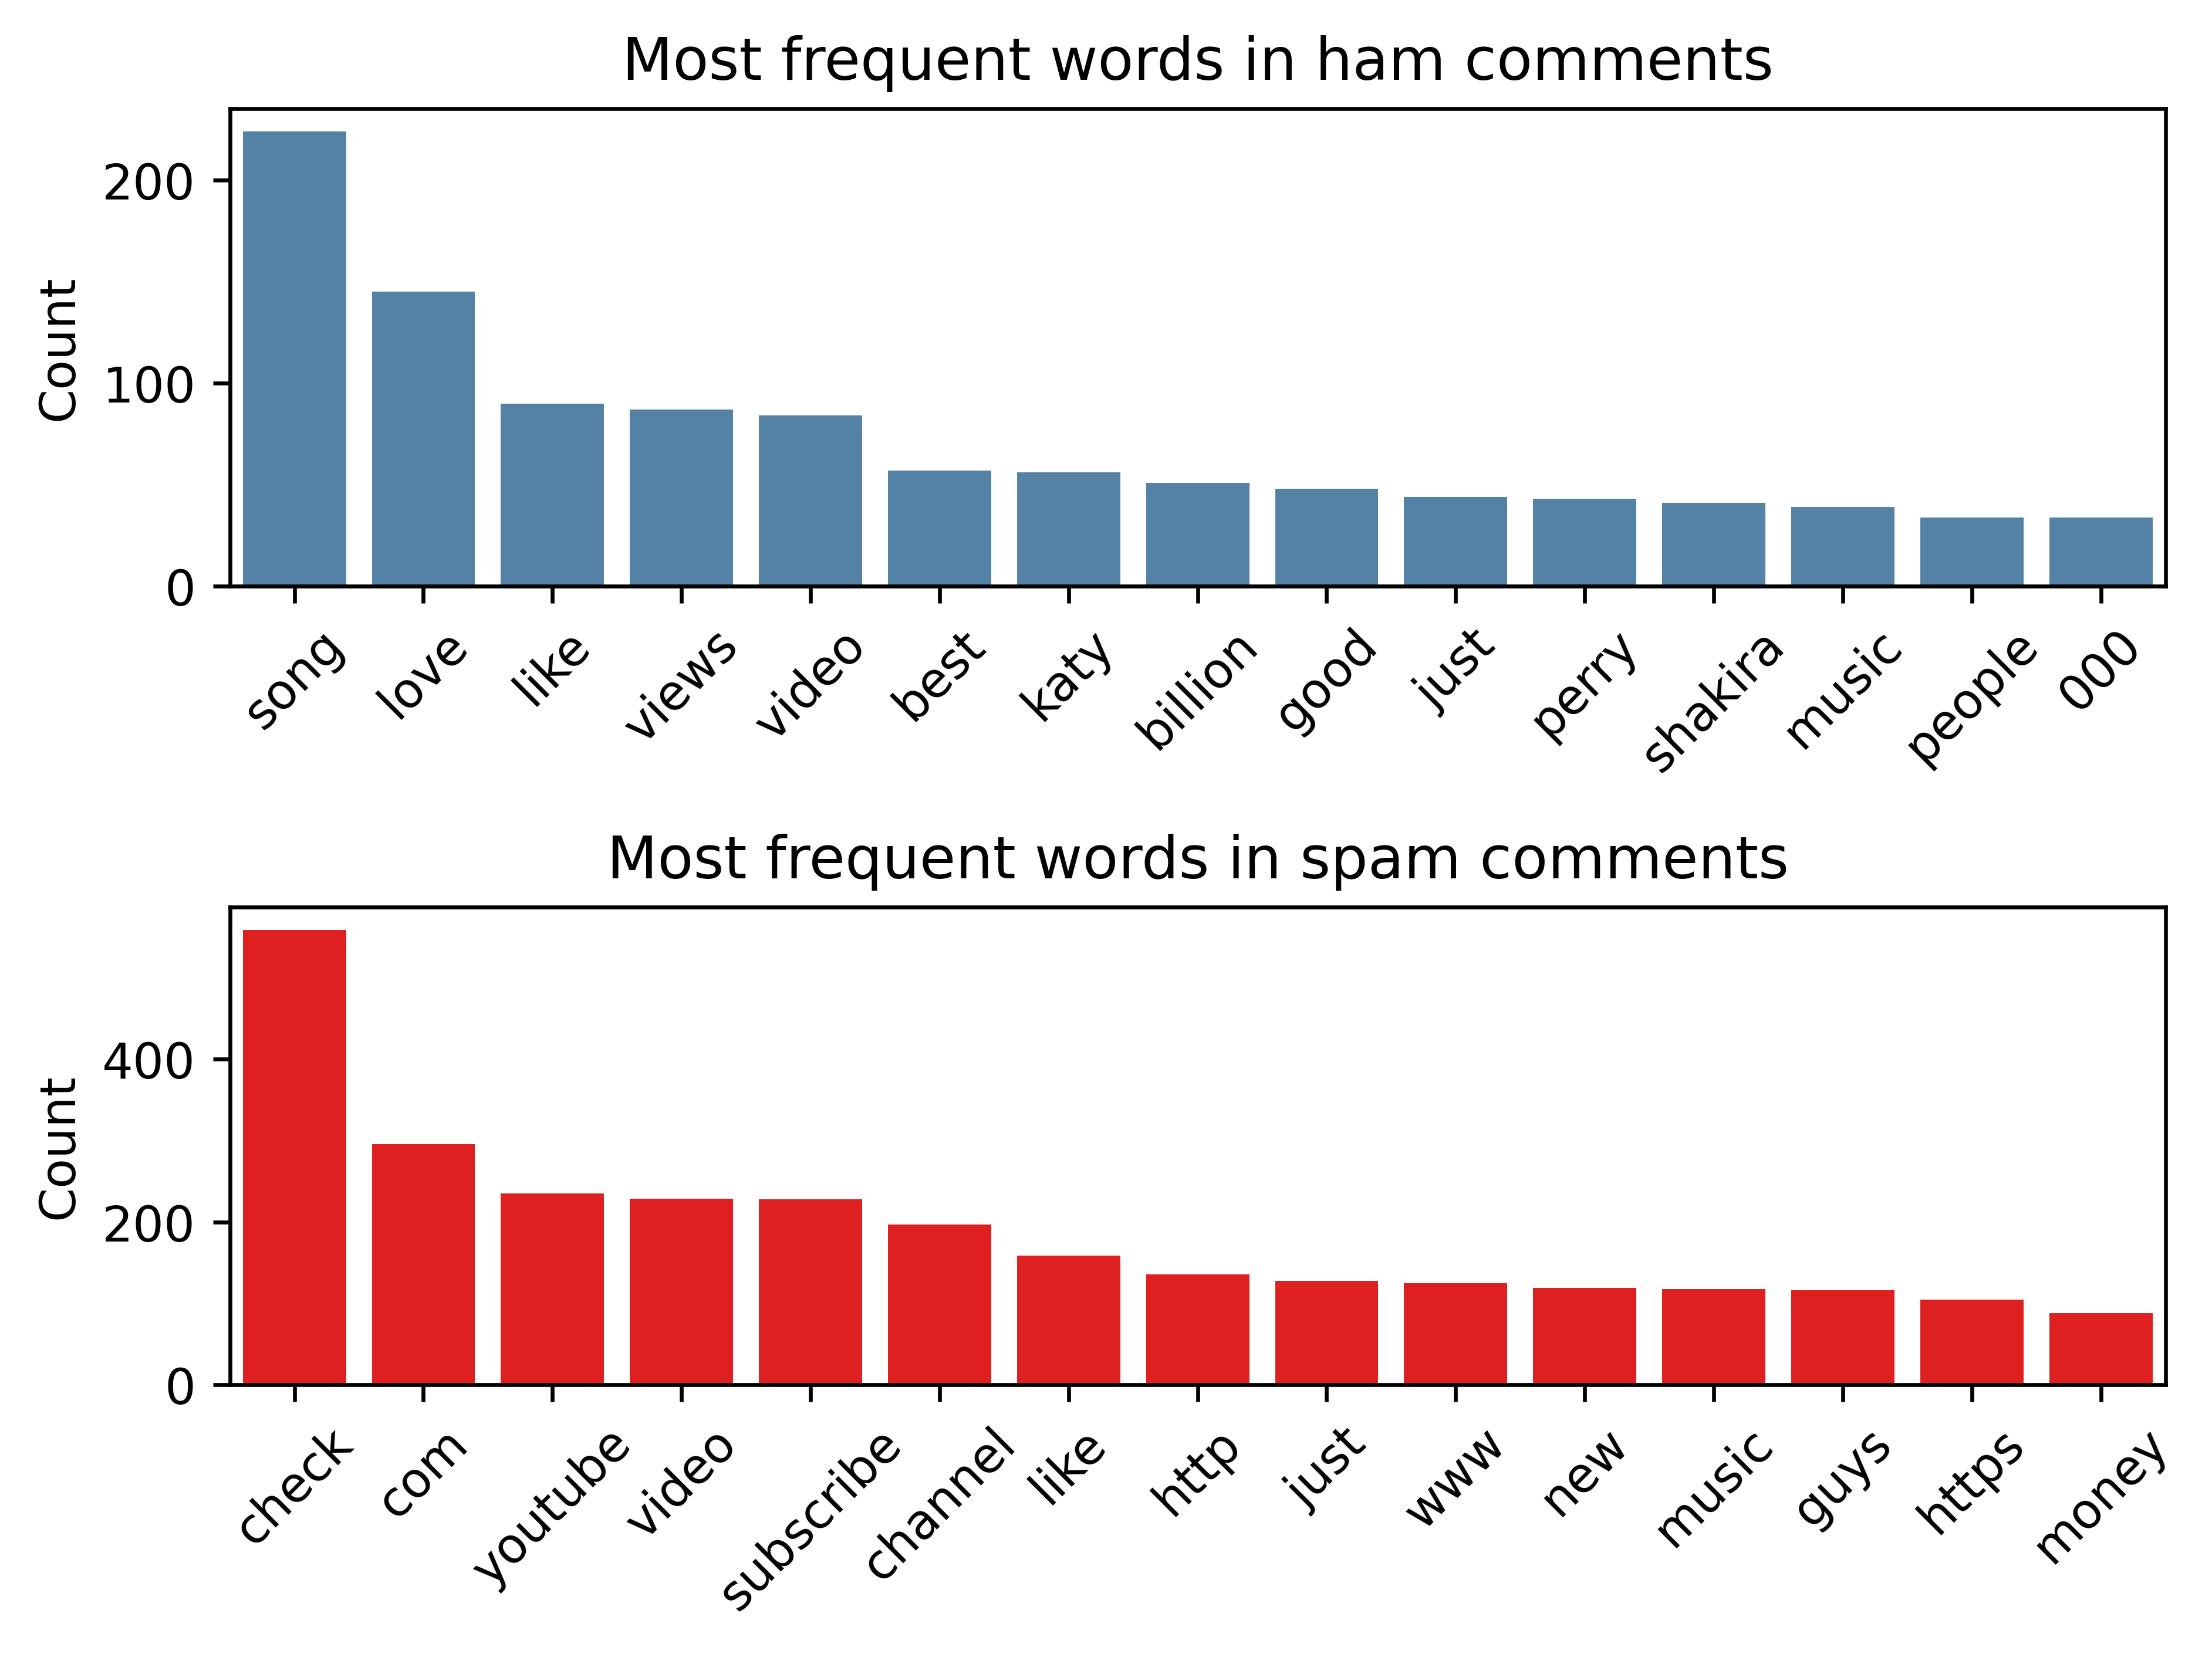

In [22]:
def compute_freq(comments):
    cv = CountVectorizer(stop_words="english").fit(comments)
    bag_of_words = cv.transform(comments)
    words_sum = bag_of_words.sum(axis=0)
    words_freq = sorted(
        ((word, words_sum[0, x]) for word, x in cv.vocabulary_.items()),
        key=lambda y: y[1],
        reverse=True,
    )
    return words_freq


ham_df = pd.DataFrame(
    compute_freq(df[df.CLASS == 0].CONTENT)[:15], columns=["word", "count"]
)
spam_df = pd.DataFrame(
    compute_freq(df[df.CLASS == 1].CONTENT)[:15], columns=["word", "count"]
)

fig, ax = plt.subplots(2, 1, dpi=600)
g = sns.barplot(x="word", y="count", data=ham_df, ax=ax[0], color="steelblue")
g.set_title("Most frequent words in ham comments")
g.set_xticklabels(g.get_xticklabels(), rotation=45)
g.set_xlabel("")
g.set_ylabel("Count")

g = sns.barplot(x="word", y="count", data=spam_df, ax=ax[1], color="red")
g.set_title("Most frequent words in spam comments")
g.set_xticklabels(g.get_xticklabels(), rotation=45)
g.set_xlabel("")
g.set_ylabel("Count")

plt.tight_layout()
plt.savefig("figures/word_frequencies", transparent=True)

# Classification

In [23]:
vect = TfidfVectorizer(stop_words=stopwords)
analyzer = vect.build_analyzer()

snowball_stemmer = nltk.SnowballStemmer("english")
porter_stemmer = nltk.PorterStemmer()
lemmatizer = nltk.WordNetLemmatizer()


def snowball(x):
    return [" ".join([snowball_stemmer.stem(w) for w in analyzer(doc)]) for doc in x]


def porter(x):
    return [" ".join([porter_stemmer.stem(w) for w in analyzer(doc)]) for doc in x]


def lemmatisation(x):
    return [" ".join([lemmatizer.lemmatize(w) for w in analyzer(doc)]) for doc in x]


print(df.CONTENT[1])
print(snowball(df.CONTENT))
print(porter(df.CONTENT))
print(lemmatisation(df.CONTENT))

Hey guys check out my new channel and our first vid THIS IS US THE  MONKEYS!!! I'm the monkey in the white shirt,please leave a like comment  and please subscribe!!!!
['huh anyway check tube channel kobyoshi02', 'hey guy check new channel first vid us monkey monkey white shirt pleas leav like comment pleas subscrib', 'test say murdev com', 'shake sexi ass channel enjoy', 'watch vtarggvgtwq check', 'hey check new websit site kid stuff kidsmediausa com', 'subscrib channel', 'turn mute soon came want check view', 'check channel funni video', 'check channel tell next', 'hey subscrib', 'start read stop subscrib within one day entir famili die want stay aliv subscrib right', 'https twitter com gbphotographygb', 'subscrib like comment', 'pleas like https premium easypromosapp com votem 19924 616375350', 'hello like game art video scientif experi tutori lyric video much much pleas check channel subscrib start soon hope abl cover expect also check got far', 'check view', 'http www ebay com itm 

In [24]:
classifiers = [
    ("SVC", SVC()),
    ("Multinomial NB", MultinomialNB()),
    ("Decision tree", DecisionTreeClassifier()),
    ("Random forest", RandomForestClassifier()),
]

preprocessors = [
    ("Snowball", snowball),
    ("Porter", porter),
    ("Lemmatization", lemmatisation),
]

folds = 10


def classify(data, preprocessors, classifiers):
    table = [
        ["Preprocessor"],
        ["Classifier"],
        ["Confusion matrix"],
        ["Accuracy"],
        ["Precision"],
        ["Recall"],
        ["F1 score"],
    ]
    results = []

    for pname, preprocessor in preprocessors:
        for name, classifier in classifiers:
            x = preprocessor(data.copy().CONTENT)
            y = data.CLASS
            pipe = Pipeline(
                [
                    (
                        "count vectorizer",
                        CountVectorizer(lowercase=True, stop_words="english"),
                    ),
                    (name, classifier),
                ]
            )

            kfold = KFold(folds, shuffle=True, random_state=0x1337)

            predictions = cross_val_predict(pipe, x, y, cv=kfold)
            cmatrix = confusion_matrix(y, predictions)
            accuracy = cross_val_score(pipe, x, y, cv=kfold, scoring="accuracy")
            precision = cross_val_score(pipe, x, y, cv=kfold, scoring="precision_macro")
            recall = cross_val_score(pipe, x, y, cv=kfold, scoring="recall_macro")
            F1 = cross_val_score(pipe, x, y, cv=kfold, scoring="f1_macro")

            table[0] += [pname, ""]
            table[1] += [name, ""]
            table[2] += [str(cmatrix), ""]
            table[3] += [round(accuracy.mean(), 3), ""]
            table[4] += [round(precision.mean(), 3), ""]
            table[5] += [round(recall.mean(), 3), ""]
            table[6] += [round(F1.mean(), 3), ""]

            results.append((pname, name, accuracy, F1))

    print(tabulate(table))
    return results


results = classify(df.copy(), preprocessors, classifiers)

----------------  -----------    --------------    -------------    -------------    -----------    --------------    -------------    -------------    -------------    --------------    -------------    -------------
Preprocessor      Snowball       Snowball          Snowball         Snowball         Porter         Porter            Porter           Porter           Lemmatization    Lemmatization     Lemmatization    Lemmatization
Classifier        SVC            Multinomial NB    Decision tree    Random forest    SVC            Multinomial NB    Decision tree    Random forest    SVC              Multinomial NB    Decision tree    Random forest
Confusion matrix  [[917  33]     [[828 122]        [[922  28]       [[927  23]       [[918  32]     [[828 122]        [[919  31]       [[925  25]       [[919  31]       [[829 121]        [[913  37]       [[927  23]
                   [ 68 935]]     [ 57 946]]        [ 49 954]]       [ 47 956]]       [ 68 935]]     [ 59 944]]        [ 49 954]]  

Text(0.5, 1.0, 'F-measure score of preprocessing + classifier pairs')

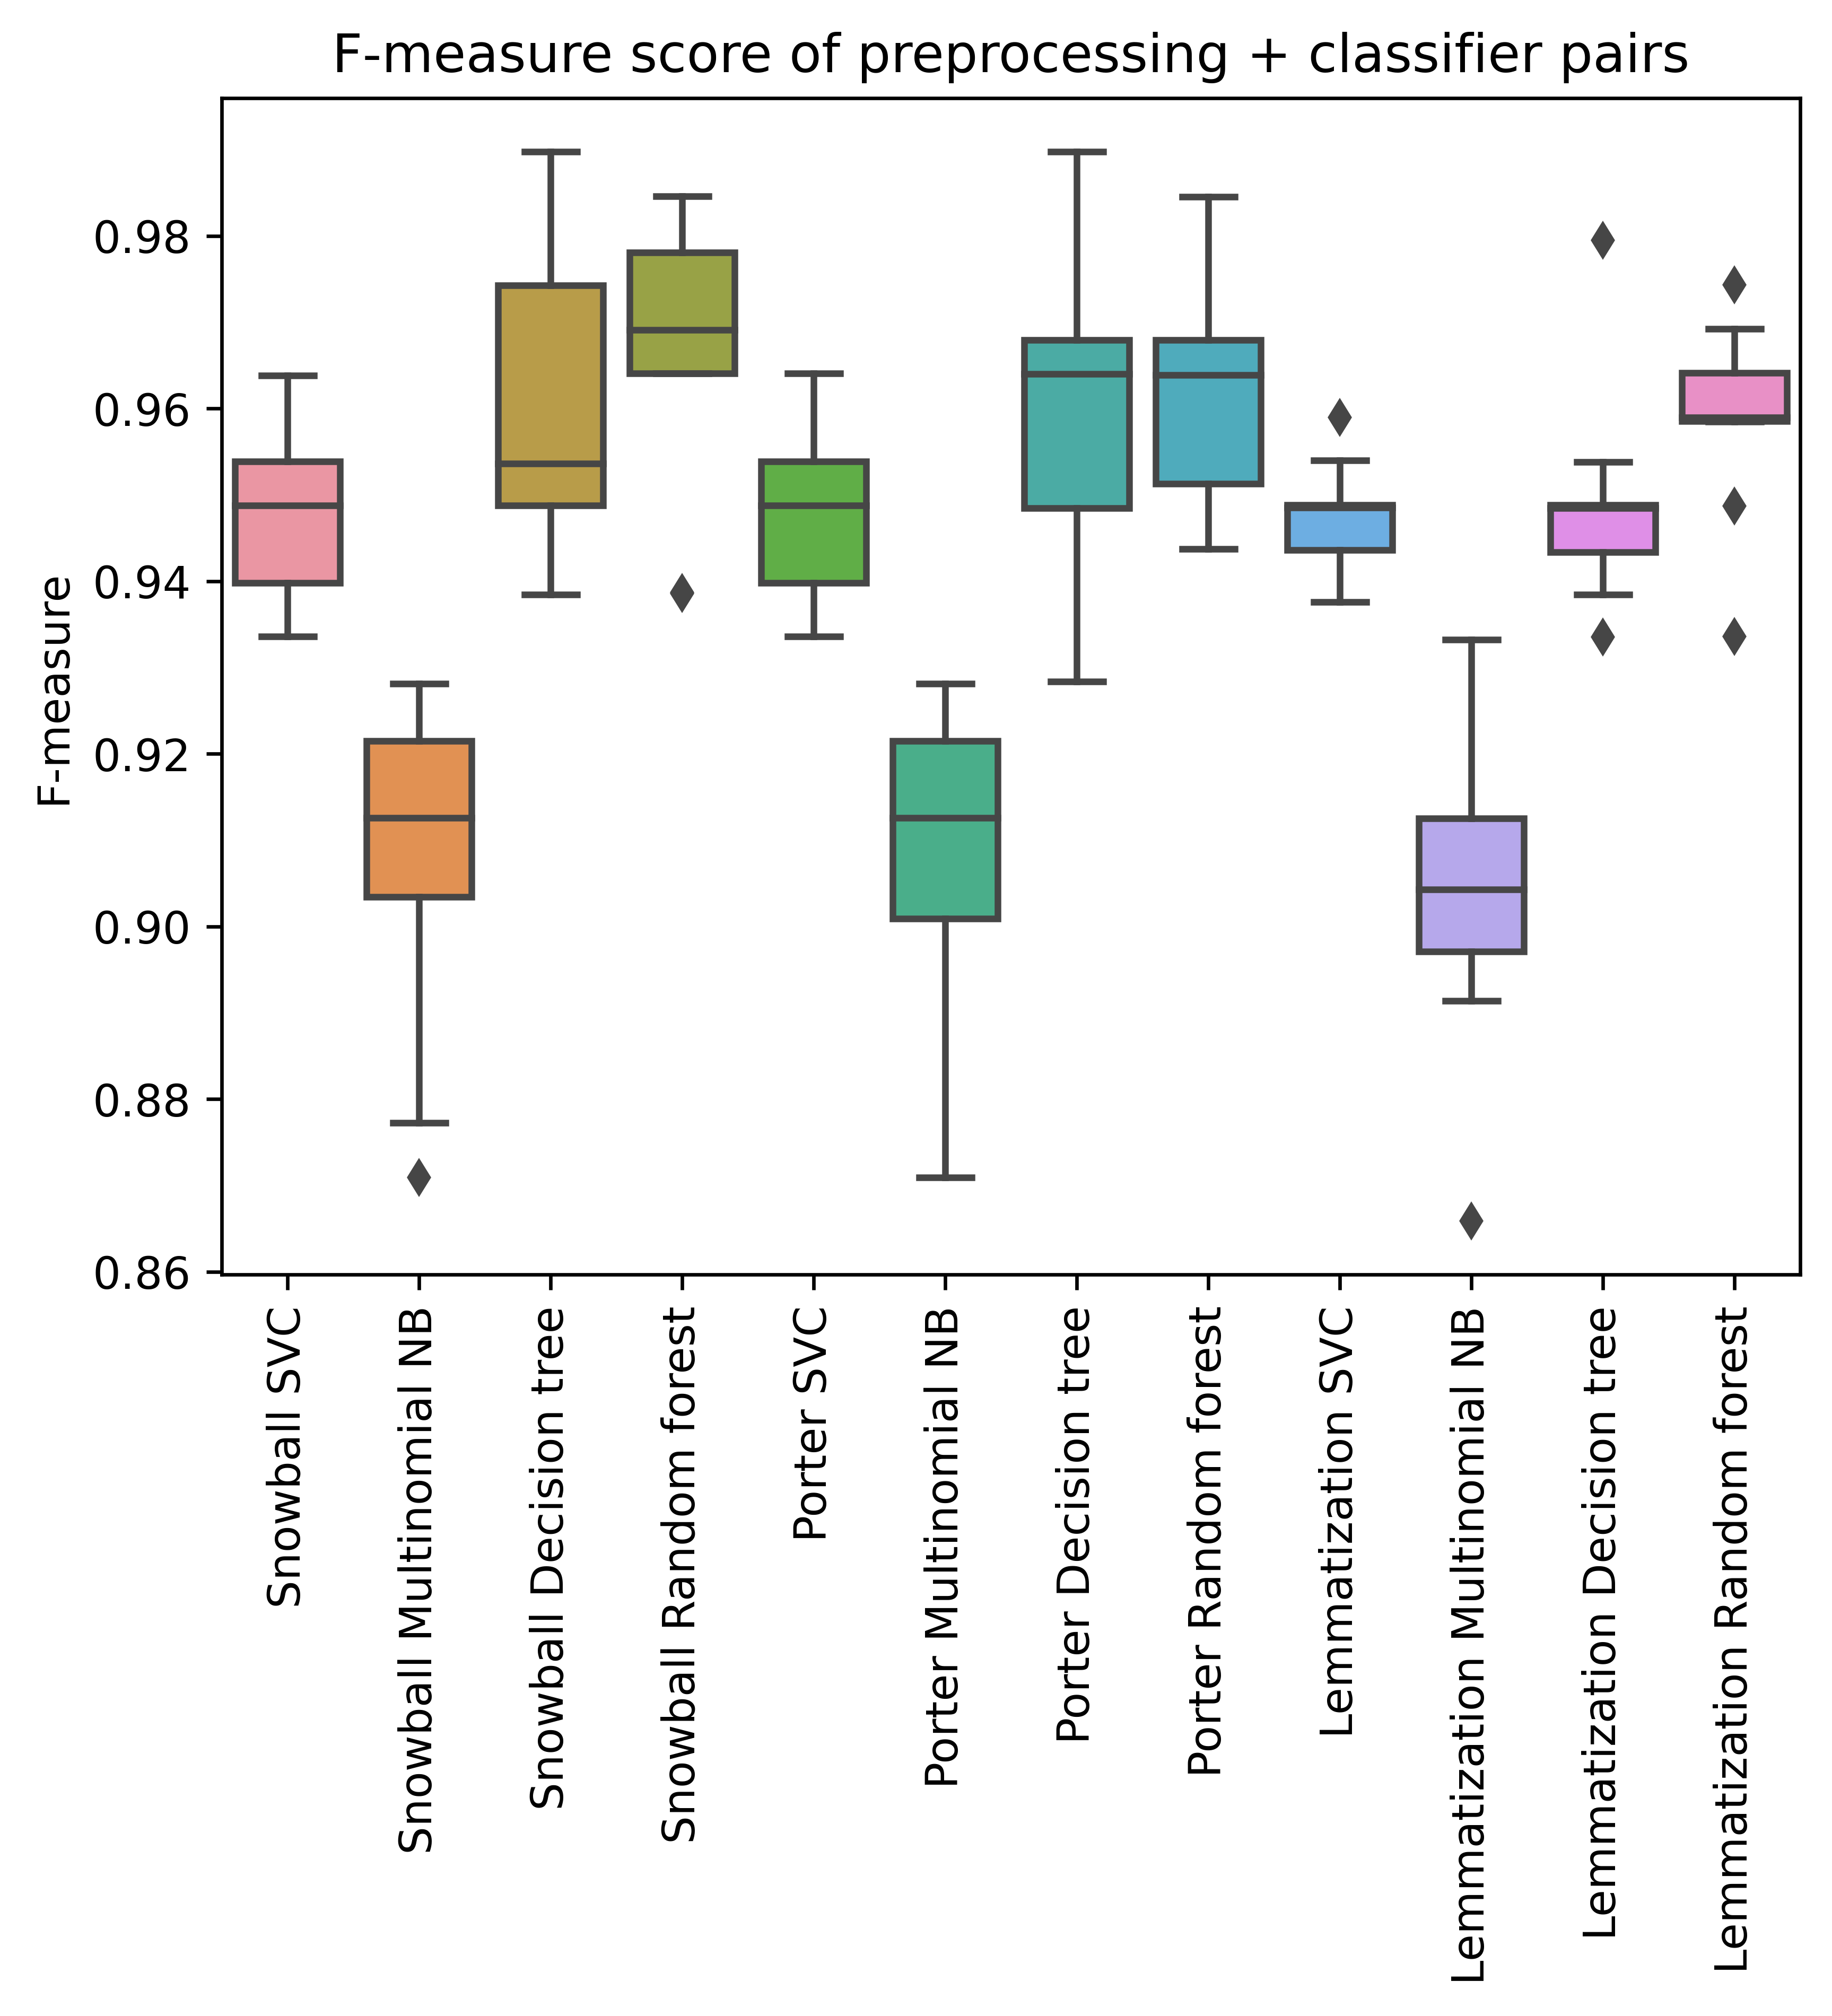

In [27]:
def flatten(_2d_list):
    flat_list = []
    # Iterate through the outer list
    for element in _2d_list:
        if type(element) is list:
            # If the element is of type list, iterate through the sublist
            for item in element:
                flat_list.append(item)
        else:
            flat_list.append(element)
    return flat_list


copy = results.copy()
copy = flatten([[[x[0] + " " + x[1], y] for y in x[3]] for x in copy])
copy = pd.DataFrame(copy, columns=["algo", "f1score"])

plt.figure(dpi=600)
g = sns.boxplot(copy, x="algo", y="f1score")
g.set_xlabel("")
g.set_ylabel("F-measure")
g.set_xticklabels(labels=g.get_xticklabels(), rotation=90)
g.set_title("F-measure score of preprocessing + classifier pairs")
# plt.savefig("figures/boxplot_results", transparent=True)

In [133]:
# print results as table
table = [["", "SVC", "Multinomial Naive Bayes", "Decision tree", "Random forest"]]

count = 0
nrows = len(classifiers)
for i in range(0, len(results), nrows):
    row = [results[i][0]]
    for res in results[i : i + nrows]:
        row.append(round(res[3].mean(), 3))
    table.append(row)

print("F1 score")
print(tabulate(table))


# print results as table
table = [["", "SVC", "Multinomial Naive Bayes", "Decision tree", "Random forest"]]

count = 0
nrows = len(classifiers)
for i in range(0, len(results), nrows):
    row = [results[i][0]]
    for res in results[i : i + nrows]:
        row.append(round(res[2].mean(), 3))
    table.append(row)

print()
print()
print("Accuracy")
print(tabulate(table))

F1 score
----------------  -----  -----------------------  -------------  -------------
                  SVC    Multinomial Naive Bayes  Decision tree  Random forest
Snowball stemmer  0.948  0.908                    0.957          0.964
Porter stemmer    0.949  0.907                    0.957          0.962
Lemmatisation     0.947  0.903                    0.949          0.958
----------------  -----  -----------------------  -------------  -------------


Accuracy
----------------  -----  -----------------------  -------------  -------------
                  SVC    Multinomial Naive Bayes  Decision tree  Random forest
Snowball stemmer  0.948  0.908                    0.958          0.964
Porter stemmer    0.949  0.907                    0.96           0.964
Lemmatisation     0.947  0.904                    0.949          0.961
----------------  -----  -----------------------  -------------  -------------


In [234]:
from itertools import combinations

for x in combinations(results, 2):
    test_res = wilcoxon(x[0][2], x[1][2]).pvalue
    end = "significant" if test_res <= 0.05 else ""
    print(
        f"{x[0][0]} {x[0][1]}".ljust(28, " ")
        + " vs "
        + f"{x[1][0]} {x[1][1]}:".ljust(30, " ")
        + f"pvalue={test_res}".ljust(30, " ")
        + end
    )

Snowball SVC                 vs Snowball Multinomial NB:      pvalue=0.001953125            significant
Snowball SVC                 vs Snowball Decision tree:       pvalue=0.02734375             significant
Snowball SVC                 vs Snowball Random forest:       pvalue=0.005859375            significant
Snowball SVC                 vs Porter SVC:                   pvalue=0.4142161782425252     
Snowball SVC                 vs Porter Multinomial NB:        pvalue=0.001953125            significant
Snowball SVC                 vs Porter Decision tree:         pvalue=0.03781375300840646    significant
Snowball SVC                 vs Porter Random forest:         pvalue=0.005859375            significant
Snowball SVC                 vs Lemmatization SVC:            pvalue=0.37341957891194966    
Snowball SVC                 vs Lemmatization Multinomial NB: pvalue=0.001953125            significant
Snowball SVC                 vs Lemmatization Decision tree:  pvalue=0.944114095577639

/usr/lib/python3.11/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/lib/python3.11/site-packages/scipy/stats/_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


In [235]:
for x in combinations(results, 2):
    if x[0][1] == x[1][1]:
        test_res = wilcoxon(x[0][2], x[1][2]).pvalue
        end = "significant" if test_res <= 0.05 else ""
        print(
            f"{x[0][0]} {x[0][1]}".ljust(28, " ")
            + " vs "
            + f"{x[1][0]} {x[1][1]}:".ljust(30, " ")
            + f"pvalue={test_res}".ljust(30, " ")
            + end
        )

Snowball SVC                 vs Porter SVC:                   pvalue=0.4142161782425252     
Snowball SVC                 vs Lemmatization SVC:            pvalue=0.37341957891194966    
Snowball Multinomial NB      vs Porter Multinomial NB:        pvalue=0.31731050786291415    
Snowball Multinomial NB      vs Lemmatization Multinomial NB: pvalue=0.2930292591867747     
Snowball Decision tree       vs Porter Decision tree:         pvalue=0.4452427442174438     
Snowball Decision tree       vs Lemmatization Decision tree:  pvalue=0.03266254638630504    significant
Snowball Random forest       vs Porter Random forest:         pvalue=0.49624247444426295    
Snowball Random forest       vs Lemmatization Random forest:  pvalue=0.193359375            
Porter SVC                   vs Lemmatization SVC:            pvalue=0.48330324160257043    
Porter Multinomial NB        vs Lemmatization Multinomial NB: pvalue=0.2930292591867747     
Porter Decision tree         vs Lemmatization Decision tree

/usr/lib/python3.11/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/lib/python3.11/site-packages/scipy/stats/_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


In [236]:
for x in combinations(results, 2):
    if x[0][0] == x[1][0]:
        test_res = wilcoxon(x[0][2], x[1][2]).pvalue
        end = "significant" if test_res <= 0.05 else ""
        print(
            f"{x[0][0]} {x[0][1]}".ljust(28, " ")
            + " vs "
            + f"{x[1][0]} {x[1][1]}:".ljust(30, " ")
            + f"pvalue={test_res}".ljust(30, " ")
            + end
        )

Snowball SVC                 vs Snowball Multinomial NB:      pvalue=0.001953125            significant
Snowball SVC                 vs Snowball Decision tree:       pvalue=0.02734375             significant
Snowball SVC                 vs Snowball Random forest:       pvalue=0.005859375            significant
Snowball Multinomial NB      vs Snowball Decision tree:       pvalue=0.001953125            significant
Snowball Multinomial NB      vs Snowball Random forest:       pvalue=0.001953125            significant
Snowball Decision tree       vs Snowball Random forest:       pvalue=0.40023614435907173    
Porter SVC                   vs Porter Multinomial NB:        pvalue=0.001953125            significant
Porter SVC                   vs Porter Decision tree:         pvalue=0.028124450117384896   significant
Porter SVC                   vs Porter Random forest:         pvalue=0.00390625             significant
Porter Multinomial NB        vs Porter Decision tree:         pvalue=0.0019